In [7]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm

In [8]:
MACHINE = 'lassen' if 'lassen' in ROOT_DIR else 'ruby'
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

logsDir = ROOT_DIR+'/logs'

goMethods=['cma', 'pso', 'bo']
seeds = [1337, 3827, 9999, 4873]

hypers = {
	'cma':['popsize', 'sigma'],
	'pso':['popsize', 'w', 'c1', 'c2'],
	'bo':['utilFnct', ['kappa', 'kappa_decay', 'kappa_decay_delay'], ['xi']]
}

ruby /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations


In [9]:
def plotOneVariableSweep(df, colToPlot, goMethodText=None, epsilon=0.0):
	# x-axis = samples
	# y-axis = percent xtime
	# legend = colToPlot
	df = df.copy(deep=True).reset_index(drop=True)

	# progname, probsize, and method are all the same
	assert len(list(df['progname'].unique())) == 1
	assert len(list(df['probsize'].unique())) == 3
	assert len(list(df['method'].unique())) == 1

	progname = df.iloc[0]['progname']
	method = df.iloc[0]['method']

	# shrink what we're working with
	df = df.drop(['progname', 'method', 'optimXtime'], axis=1)

	if method == 'bo':
		numUtilFncts = len(list(df['utilFnct'].unique()))
		if numUtilFncts == 1:
			util = df.iloc[0]['utilFnct']
			df = df.drop(['utilFnct'], axis=1)
			if ('poi' in util) or ('ei' in util):
				df = df.drop(['kappa', 'kappa_decay', 'kappa_decay_delay'], axis=1)
			elif 'ucb' in util:
				df = df.drop(['xi'], axis=1)
		# need to ignore the first sample since it's random
		#df.loc[df['globalSample'] == 0.0, 'xtime'] = 0

	if goMethodText:
		method += f' ({goMethodText})'

	# if the globalSample < popsize, 
	# set the xtime to 0 so we don't count the point
	if ('pso' in method) or ('cma' in method):
		#df = df.apply(lambda row: (row['xtime']=0.0) if row['globalIdx'] < row['popsize'] else pass)
		df.loc[df['globalSample'] < df['popsize'], 'xtime'] = 0


	# let's manually do the precedure
	if 'bo' in method:
		# zero-out the first samples
		#print('df columns', df.columns)
		df.loc[df['globalSample'] == 0.0, 'xtime'] = 0.0

		toSortBy = list(df.columns)
		toSortBy.remove('xtime')
		df = df.sort_values(by=toSortBy, ignore_index=True)

		df['reachedOptimal'] = (df['xtime'] >= 1-epsilon).astype(int)

		#print('before')
		#print(df.head(20))
		
		df = df.drop(['xtime'], axis=1)

		targetCols = list(df.columns)
		#print(targetCols)
		targetCols.remove('reachedOptimal')
		targetCols.remove('globalSample')
		#print('colToPlot', colToPlot, 'cumsumming over:', targetCols)



		#df['sumd'] = df.groupby(['probsize', 'xi', 'seed'])['optimIndic'].cumsum().reset_index(drop=True).apply(lambda x: 1 if x != 0 else 0)
		df['sumd'] = df.groupby(targetCols, sort=False, dropna=False)['reachedOptimal'].cumsum().reset_index(drop=True).apply(lambda x: 1 if x != 0 else 0)

		#print(df.head(20))

		newdf = df.groupby(['probsize', colToPlot, 'globalSample'], dropna=False)['sumd'].mean().reset_index(drop=False)#.apply(lambda x: 100.0*x['sumd'])
		newdf['percD'] = newdf['sumd']*100

		#print(newdf.head(20))

		g = sns.FacetGrid(newdf, col='probsize', col_order=probsizes, hue=colToPlot, palette='flare', legend_out=True, height=5, aspect=1.5)
		g.map_dataframe(sns.lineplot, x='globalSample', y='percD', drawstyle='steps-post')
		g.add_legend()
		g.set(ylim=(-0.05, 100.05))
		#g.set(xlim=(-1, 10))
		g.fig.subplots_adjust(top=0.85)
		g.fig.suptitle(f'{progname} -- {method.upper()} -- sweep "{colToPlot}" hyperparam')

		axes = g.axes.flatten()
		axes[0].set_ylabel('Percent of Executions that find the Database Optimal \n(higher is better)')
		for ax in axes:
			ax.set_xlabel('Sample Index')
			ax.axhline(y=100.0, zorder=0, ls='--')
			axTitle = ax.get_title()
			if 'lrgprob' in axTitle:
				ax.set_title('Large Input')
			elif 'medprob' in axTitle:
				ax.set_title('Medium Input')
			else:
				ax.set_title('Small Input')

		plt.show()
	
	else:
		# it's a population-based method, plot it here with a slightly diff procedure

		#print('df cols', df.columns)

		toSortBy = list(df.columns)
		toSortBy.remove('xtime')
		df = df.sort_values(by=toSortBy, ignore_index=True)

		
		# mark the samples that actually hit an optimal policy
		df['reachedOptimal'] = (df['xtime'] >= 1-epsilon).astype(int)
		df = df.drop(['xtime'], axis=1)
		df = df.dropna(axis=1, how='all')

		# first need to mark which population group each sample belongs to
		df['popgrp'] = df['globalSample']//df['popsize']

		targetCols = list(df.columns)
		targetCols.remove('reachedOptimal')
		targetCols.remove('globalSample')
		#print('colToPlot', colToPlot, 'averaging over:', targetCols)

		# for each population group, we want to average out the indicators
		df['grpAvrg'] = df.groupby(targetCols)['reachedOptimal'].transform('mean')

		targetCols.remove('popgrp')
		#print('colToPlot', colToPlot, 'cumsumming over:', targetCols)
		df['sumd'] = df.groupby(targetCols)['grpAvrg'].transform('cumsum').apply(lambda x: min(1, x))

		newdf = df.groupby(['probsize', colToPlot, 'globalSample'])['sumd'].mean().reset_index(drop=False)
		newdf['percD'] = newdf['sumd']*100

		#print('peeking')
		#print(newdf.head(100))

		g = sns.FacetGrid(newdf, col='probsize', col_order=probsizes, hue=colToPlot, palette='flare', legend_out=True, height=5, aspect=1.5)
		g.map_dataframe(sns.lineplot, x='globalSample', y='percD', drawstyle='steps-post')
		g.add_legend()
		g.set(ylim=(-0.05, 100.05))
		#g.set(xlim=(-0.05, 100.05))
		g.fig.subplots_adjust(top=0.85)
		g.fig.suptitle(f'{progname} -- {method.upper()} -- sweep "{colToPlot}" hyperparam')

		axes = g.axes.flatten()
		axes[0].set_ylabel('Percent of Executions that find the Database Optimal \n(higher is better)')
		for ax in axes:
			ax.set_xlabel('Sample Index')
			ax.axhline(y=100.0, zorder=0, ls='--')
			axTitle = ax.get_title()
			if 'lrgprob' in axTitle:
				ax.set_title('Large Input')
			elif 'medprob' in axTitle:
				ax.set_title('Medium Input')
			else:
				ax.set_title('Small Input')

		plt.show()

	return
	return
	return
	return
	return
	return

	## sanity check that all the first samples have 0 for reached optimal
	#assert df[df['globalSample'] == 0]['reachedOptimal'].sum() == 0
	#print('sum is 0')
	##check = df[(df['sigma'] == 1.0) & (df['seed'] == 1337) & (df['popsize'] == 3.0) & (df['probsize'] == 'smlprob')]['reachedOptimal'].sum()
	##print('sanity check', check)

	#targetCols = list(df.columns)
	#print(targetCols)
	#targetCols.remove('xtime')
	#targetCols.remove('reachedOptimal')
	##targetCols.remove('globalSample')
	#print('colToPlot', colToPlot, 'cumsumming over:', targetCols)

	## do a cumsum and then turn it to binary
	#indics = df.groupby(list(targetCols))

	## take a cumsum to make the values along the way nonzero, then binarize them
	##df['runIndic'] = indics['reachedOptimal'].cumsum().reset_index()['reachedOptimal'].apply(lambda x: 1 if x != 0 else 0)
	#df['runIndic'] = indics['reachedOptimal'].transform('cumsum').apply(lambda x: 1 if x != 0 else 0)
	##print('test')
	##print(test, type(test))
	##print(test[test != 0])
	##df['runIndic'] = indics['reachedOptimal'].cumsum()['reachedOptimal'].apply(lambda x: 1 if x != 0 else 0).reset_index()
	##print('test', test, df.head(), df.tail(), df.iloc[595:605], df['runIndic'].sum(), sep='\n')

	#assert df[df['globalSample'] == 0]['runIndic'].sum() == 0
	#print('sum is also 0')

	## groupby the problem size and colToPlot
	#grouped = df.groupby(['probsize', colToPlot, 'globalSample'])['runIndic'].mean().reset_index()

	#print(grouped.head())

	## scale up the runIndic from 0 to 100
	#grouped['runIndic'] = grouped['runIndic']*100.0
	##print('grouped up')
	##print(grouped, grouped.head())

	#g = sns.FacetGrid(grouped, col='probsize', col_order=probsizes, hue=colToPlot, palette='flare', legend_out=True, height=5, aspect=1.5)
	#g.map_dataframe(sns.lineplot, x='globalSample', y='runIndic')
	#g.add_legend()
	#g.set(ylim=(-0.05, 100.05))
	#g.fig.subplots_adjust(top=0.85)
	#g.fig.suptitle(f'{progname} -- {method.upper()} -- sweep "{colToPlot}" hyperparam')

	#axes = g.axes.flatten()
	#axes[0].set_ylabel('Percent of Executions that find the Database Optimal \n(higher is better)')
	#for ax in axes:
	#	ax.set_xlabel('Sample Index')
	#	ax.axhline(y=100.0, zorder=0, ls='--')
	#	axTitle = ax.get_title()
	#	if 'lrgprob' in axTitle:
	#		ax.set_title('Large Input')
	#	elif 'medprob' in axTitle:
	#		ax.set_title('Medium Input')
	#	else:
	#		ax.set_title('Small Input')

	#plt.show()

	#return

In [10]:

def plotIndividualVariablesForAllCodes():
	# this plots each of the individual variables of each method
	# applied to each progname+probsize combination.
	# it averages xtimes across seeds.
	for progname in prognames:
		for method in goMethods:
			# read the pre-processed dataframe
			filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data.csv'
			print('reading file', filename)
			fullDF = pd.read_csv(filename)
				
			hyps = hypers[method]
			for hyp in hyps:
				print(progname, method, hyp)
				if method == 'bo':
					if 'kappa' in hyp:
						boDF = fullDF[fullDF['utilFnct'] == 'ucb']
						for h in hyp:
							plotOneVariableSweep(boDF, h, 'ucb')
					elif 'xi' in hyp:
						boDF = fullDF[fullDF['utilFnct'] == 'poi']
						for h in hyp:
							plotOneVariableSweep(boDF, h, 'poi')
						boDF = fullDF[fullDF['utilFnct'] == 'ei']
						for h in hyp:
							plotOneVariableSweep(boDF, h, 'ei')
					else:
						plotOneVariableSweep(fullDF, hyp, 'overall')
				else:
					plotOneVariableSweep(fullDF, hyp)
			#return
	return
				



reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-cma-GO_Data.csv
bt_nas cma popsize


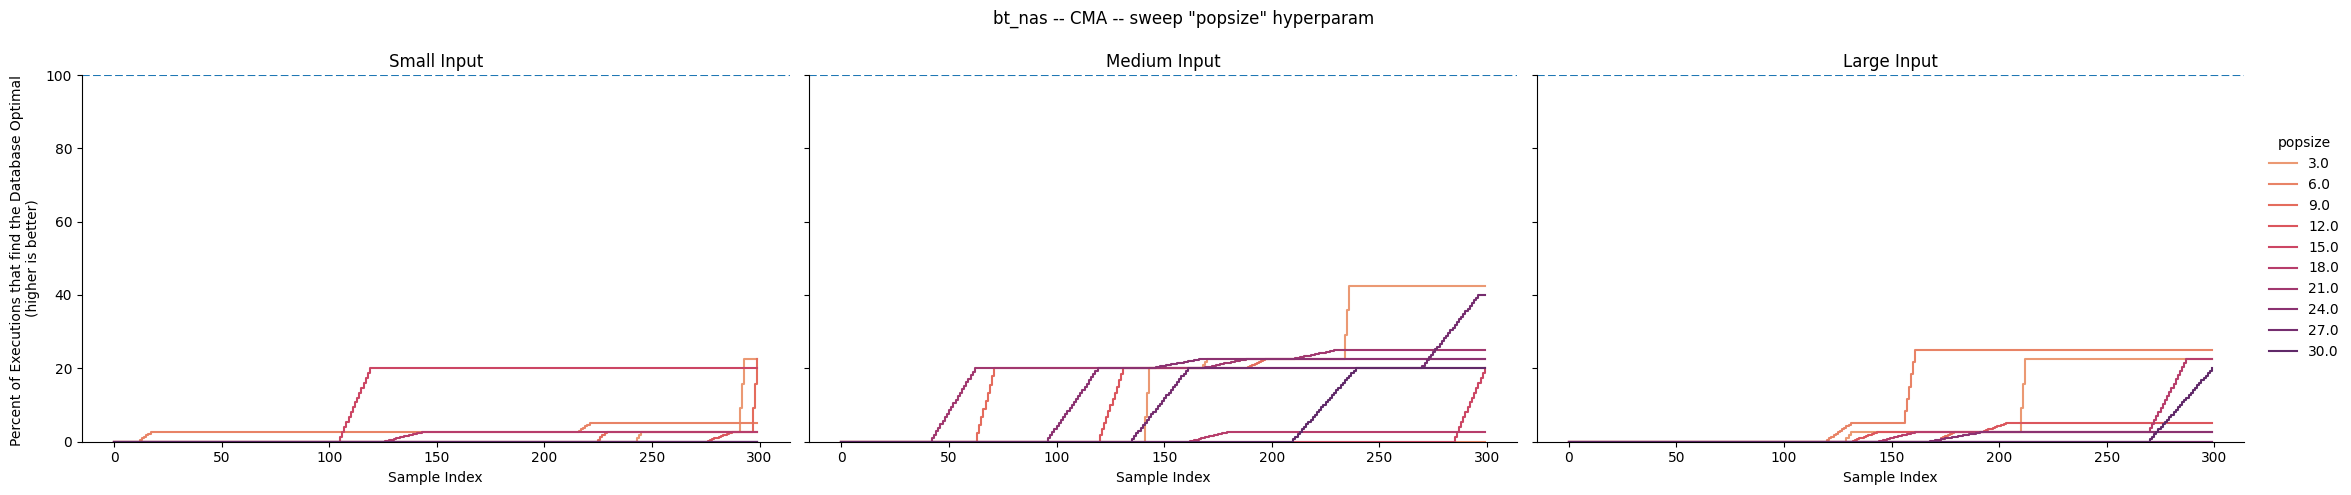

bt_nas cma sigma


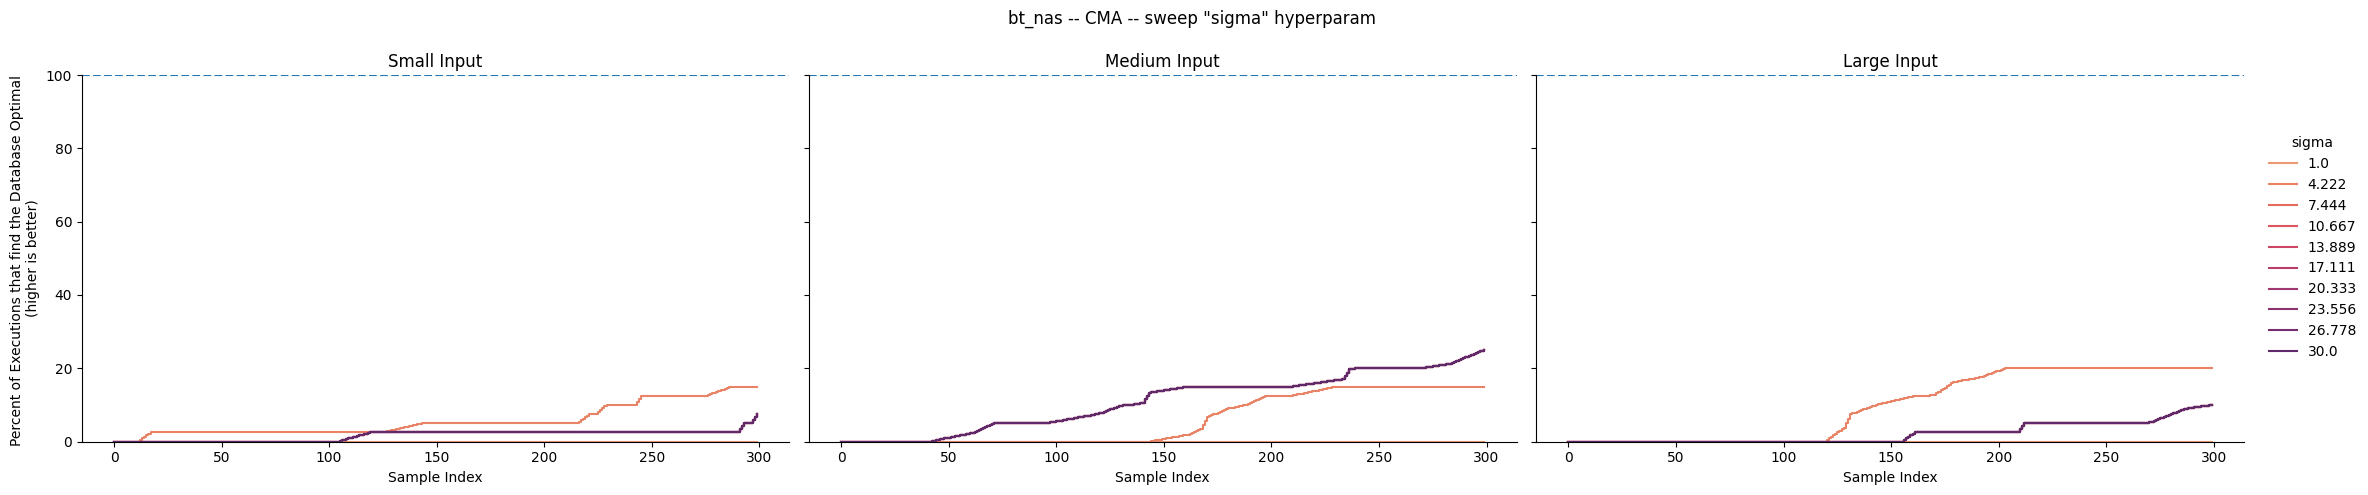

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-pso-GO_Data.csv
bt_nas pso popsize


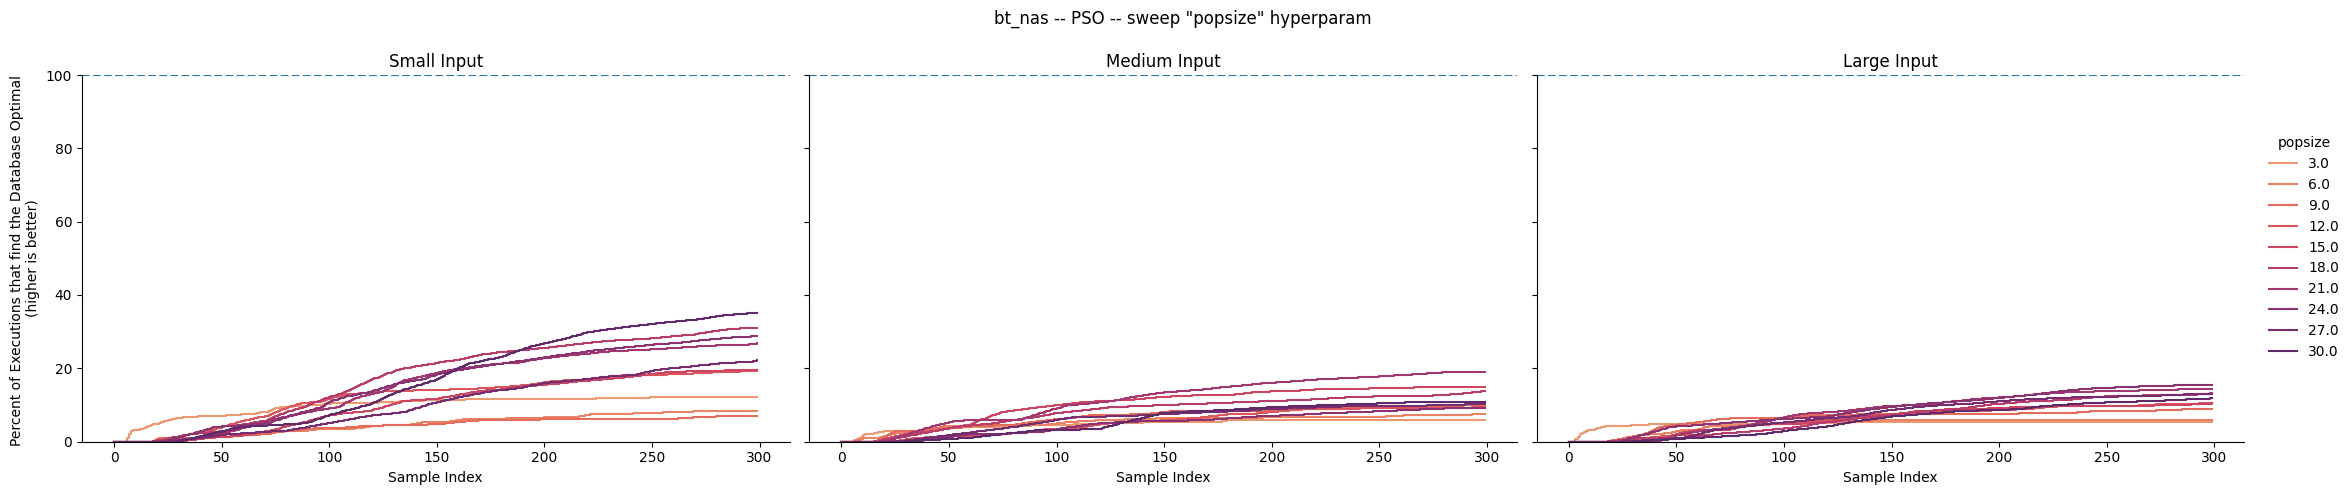

bt_nas pso w


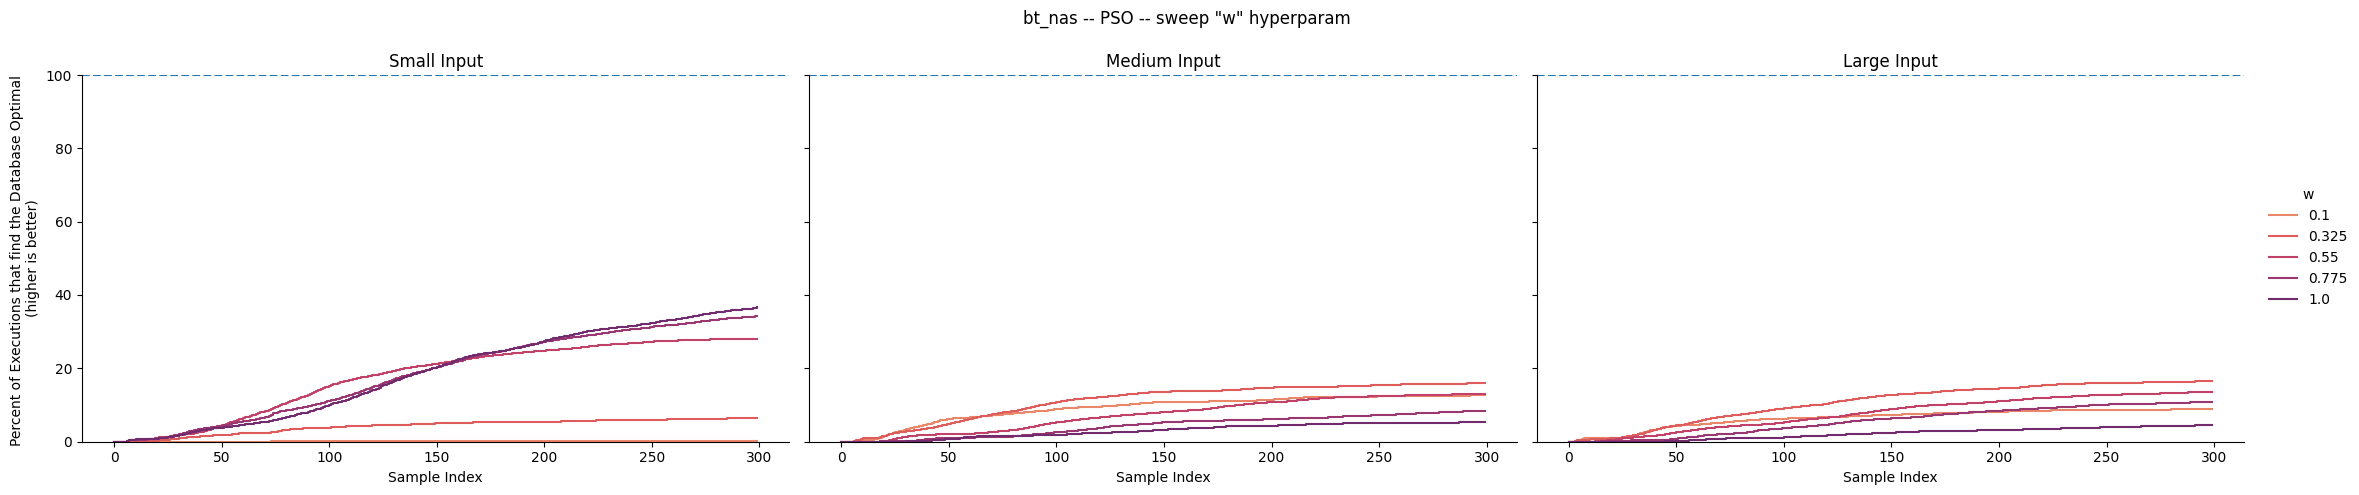

bt_nas pso c1


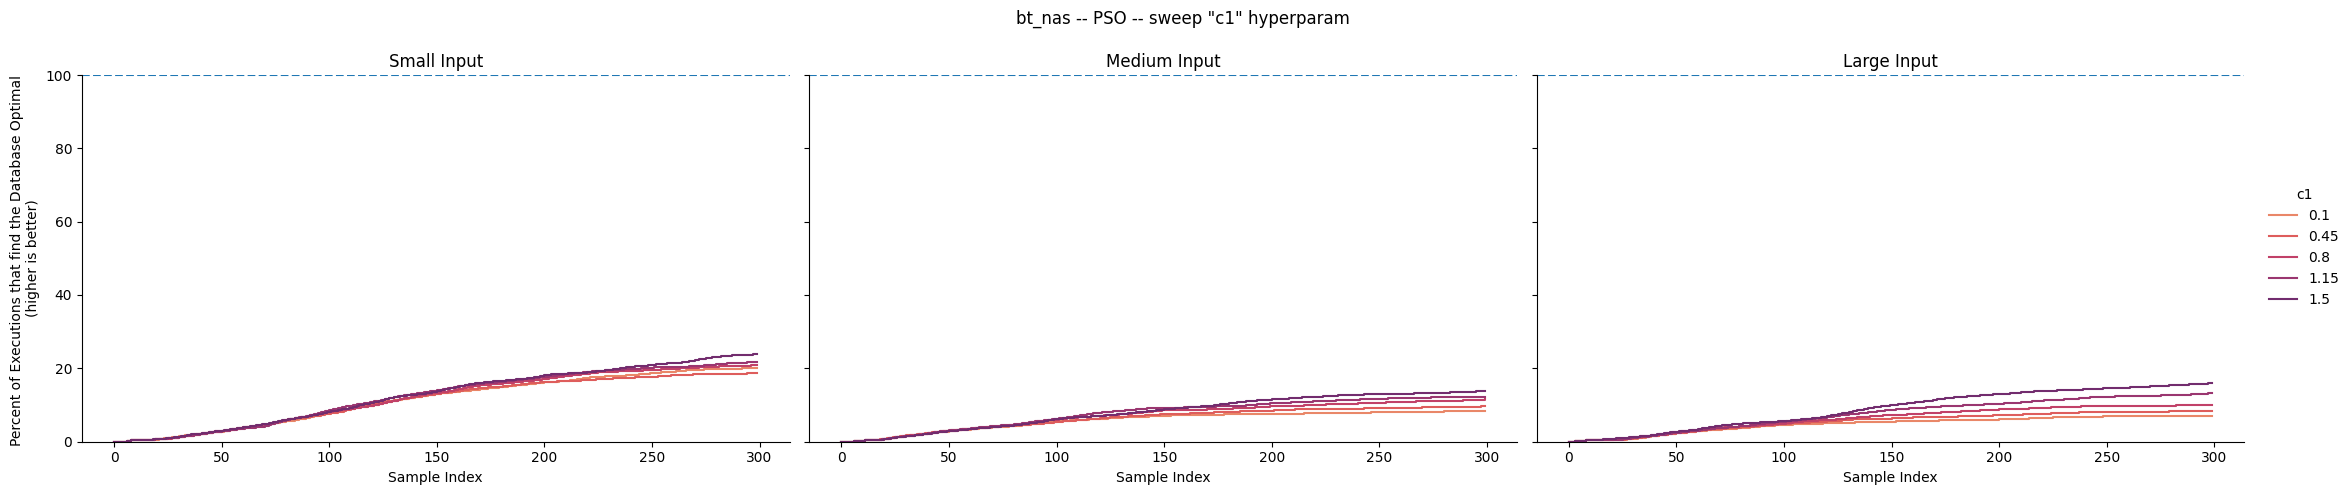

bt_nas pso c2


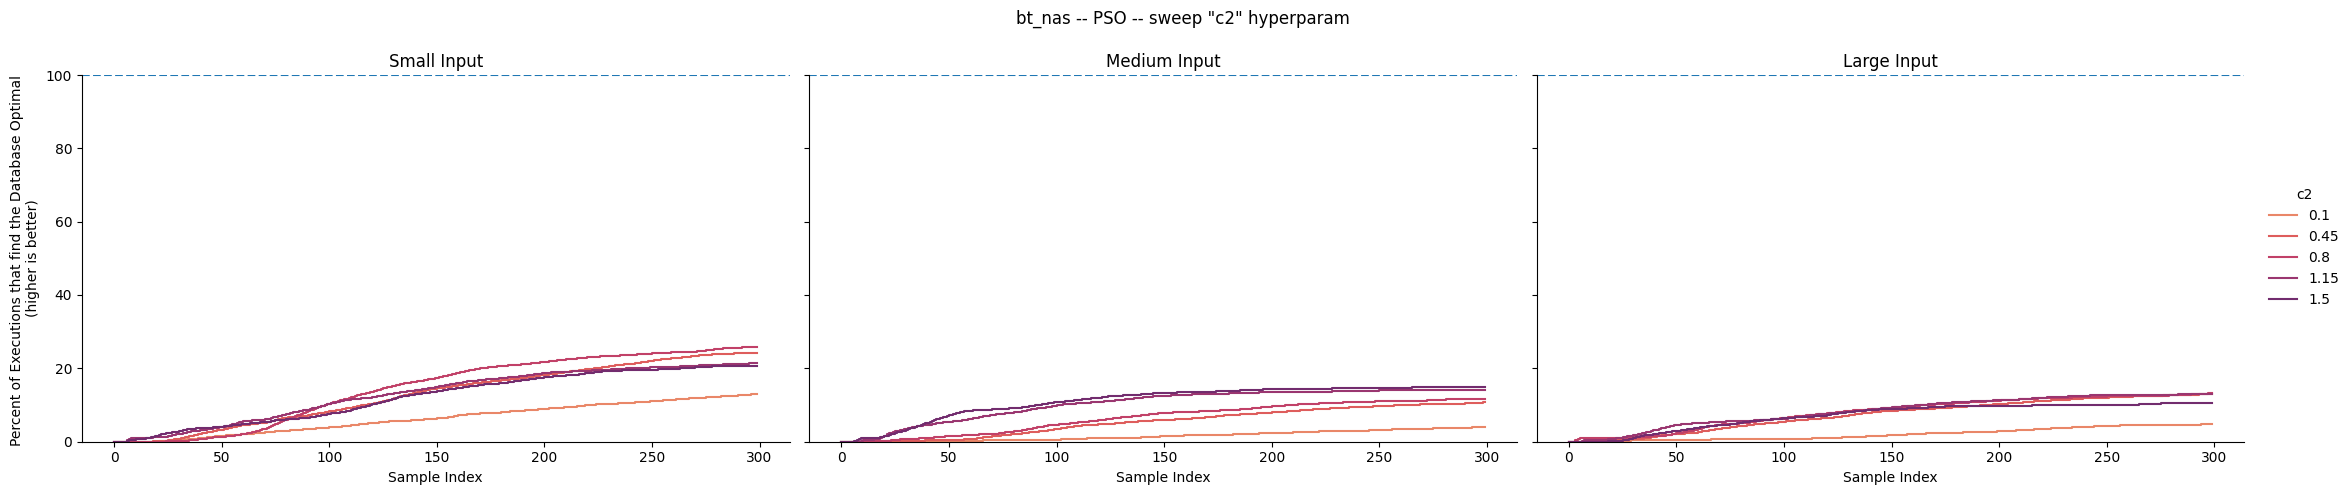

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-bo-GO_Data.csv
bt_nas bo utilFnct


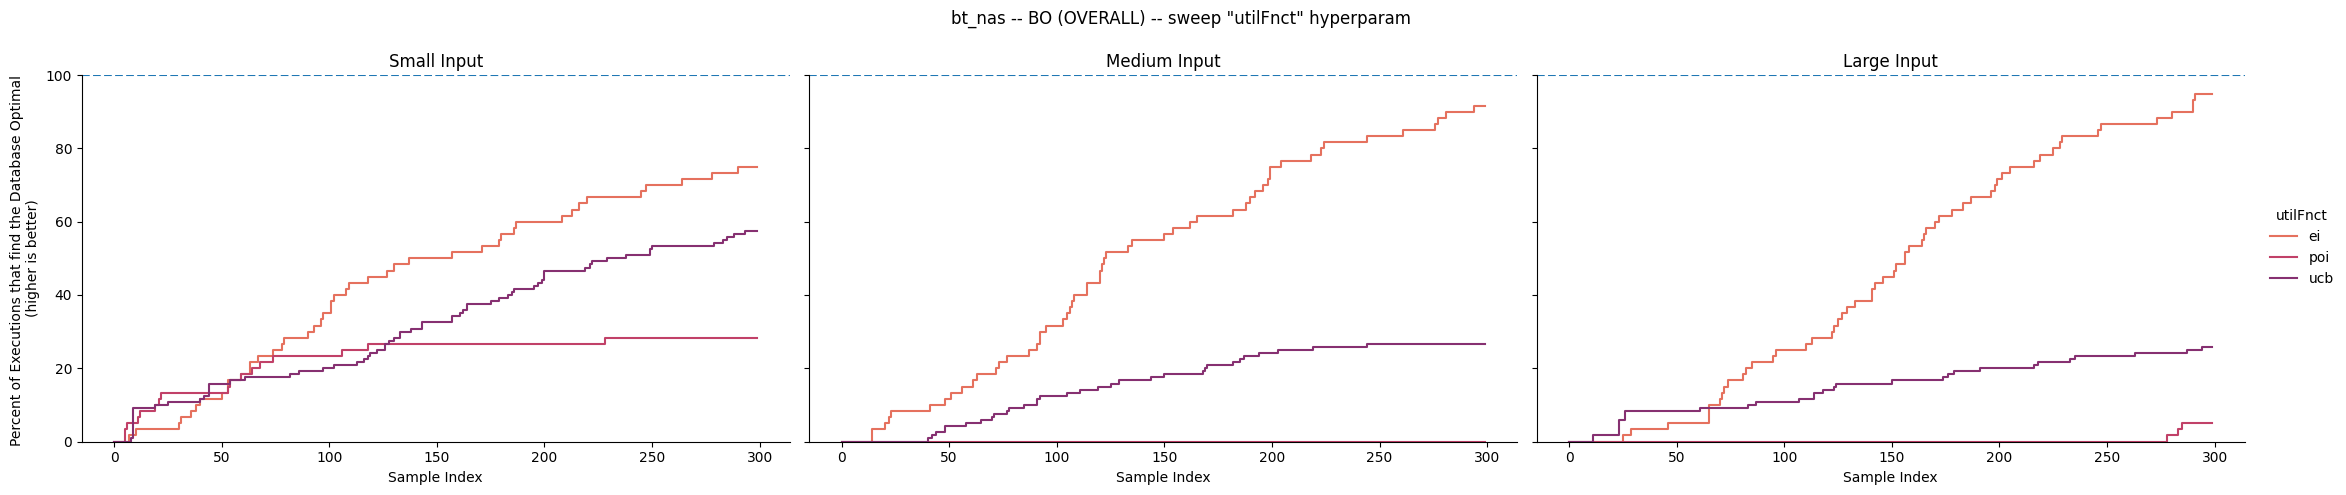

bt_nas bo ['kappa', 'kappa_decay', 'kappa_decay_delay']


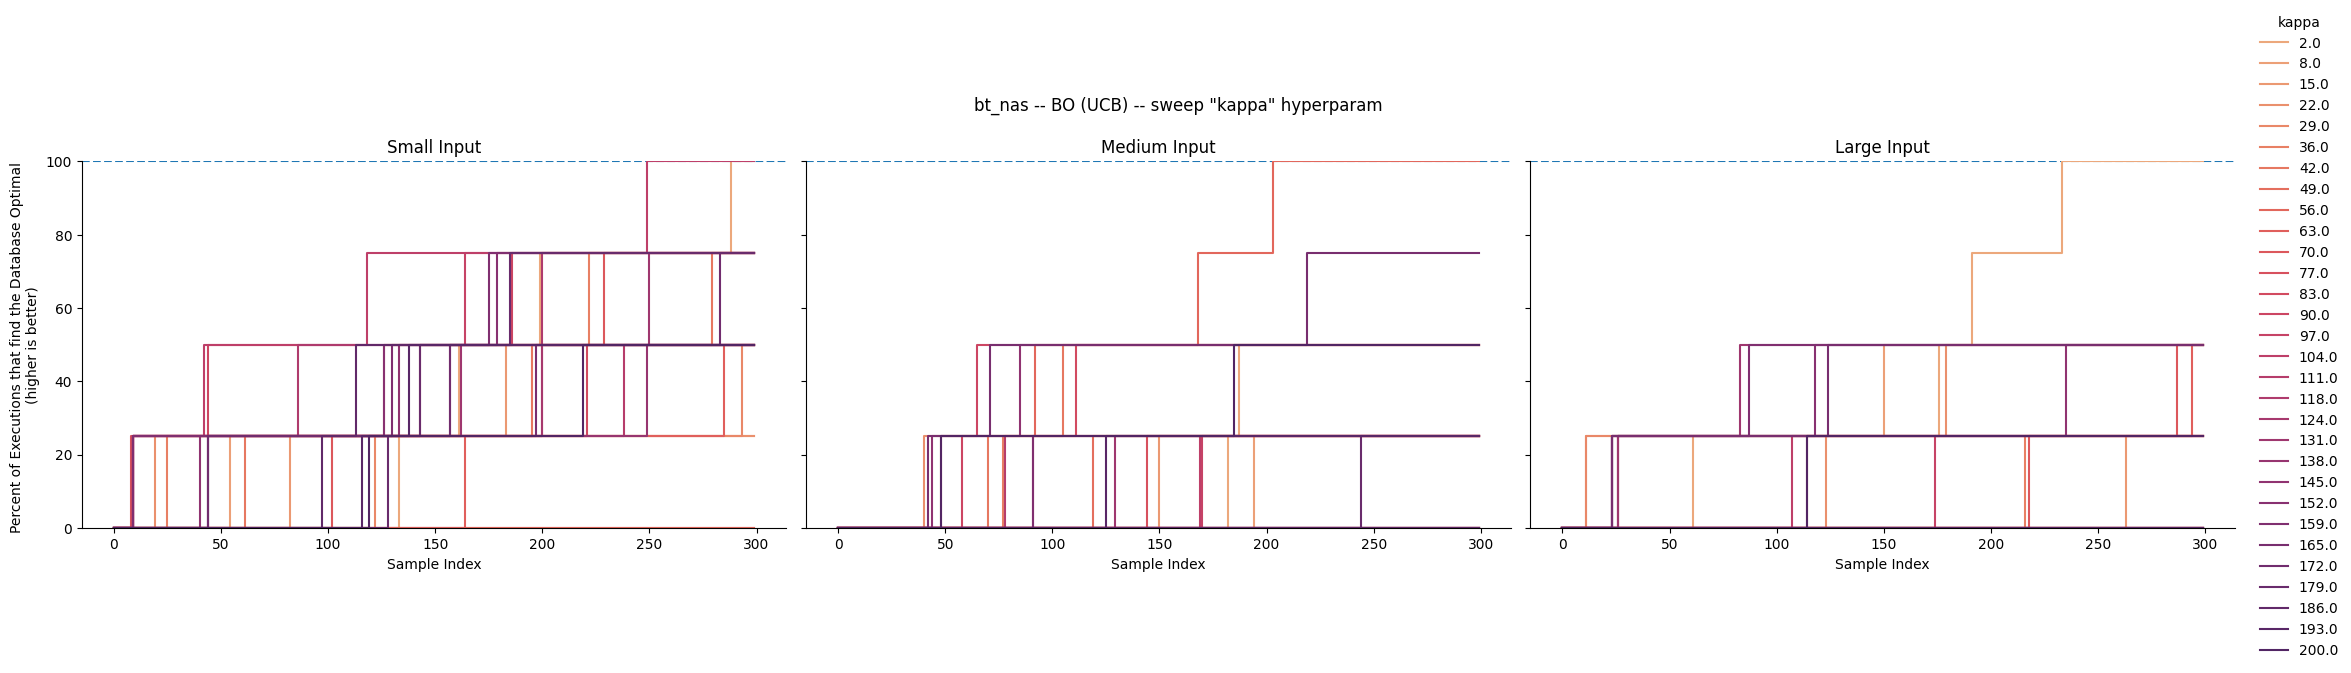

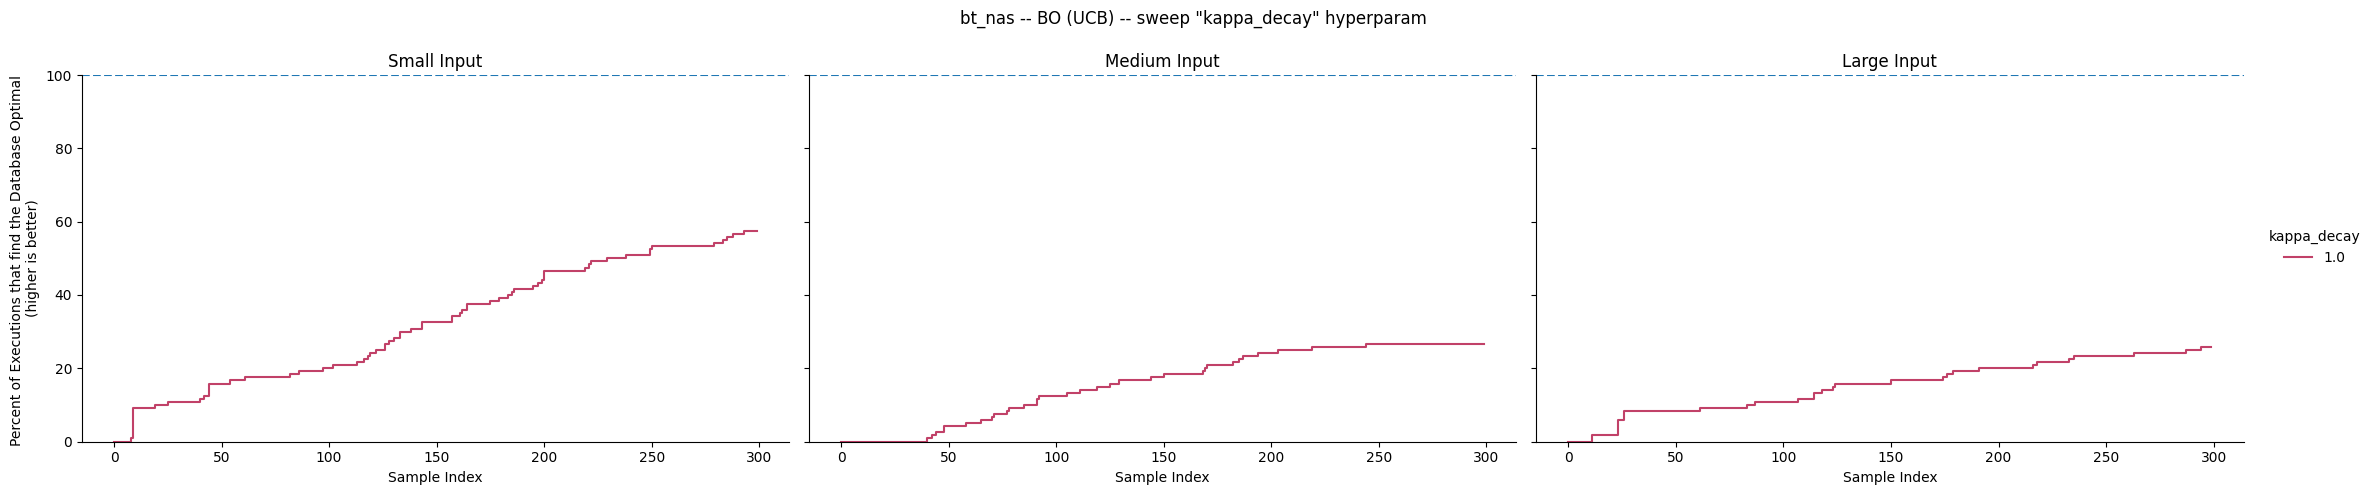

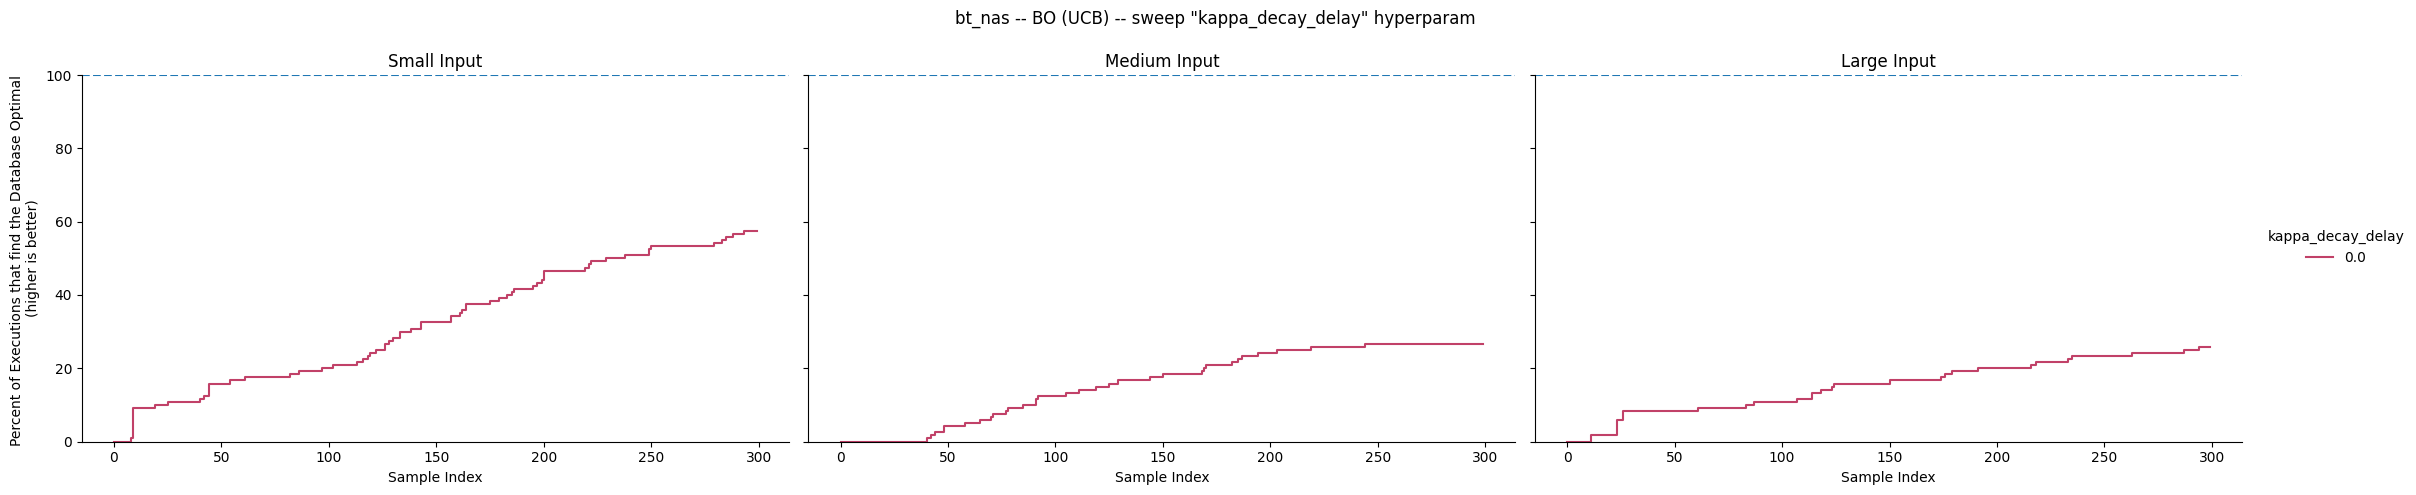

bt_nas bo ['xi']


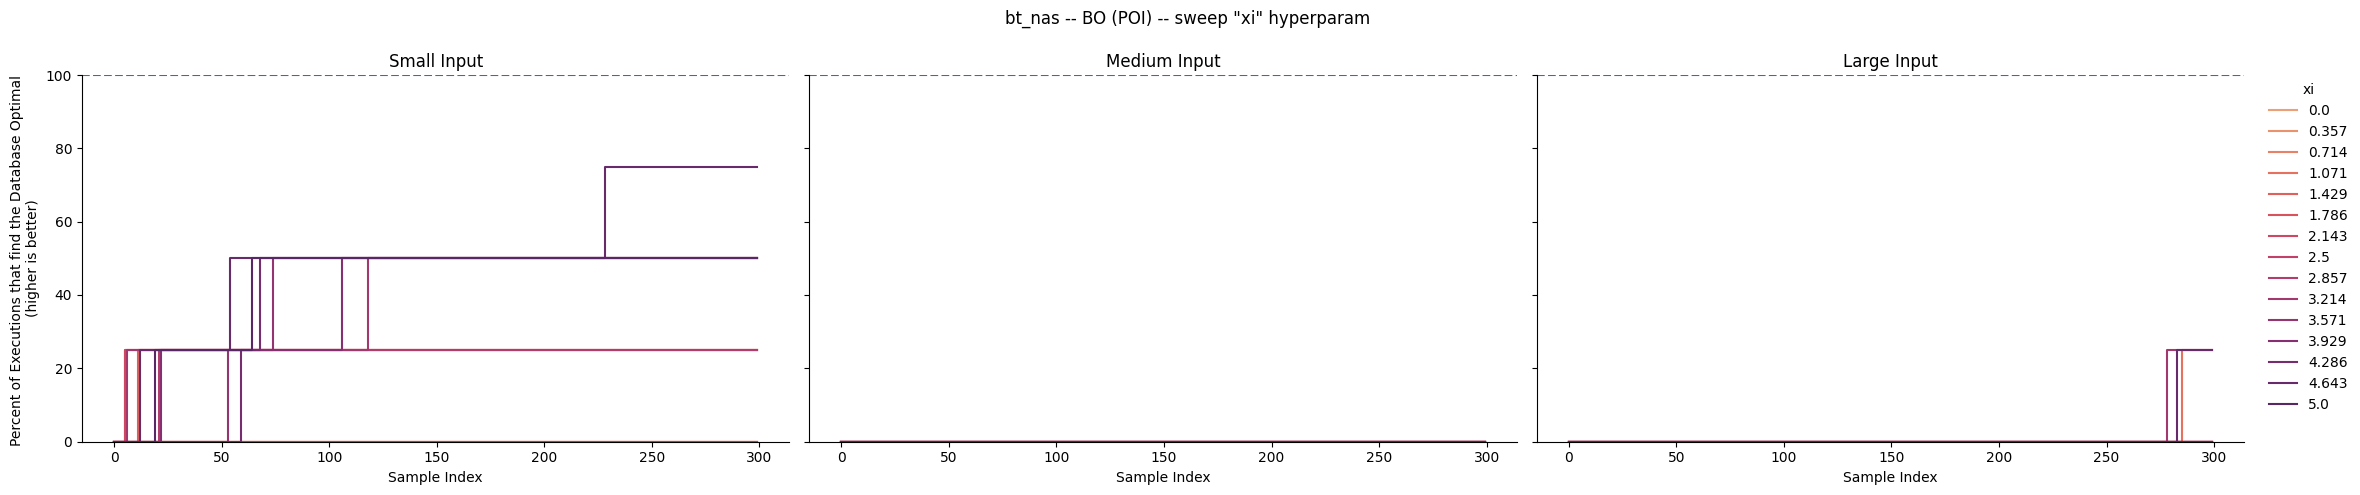

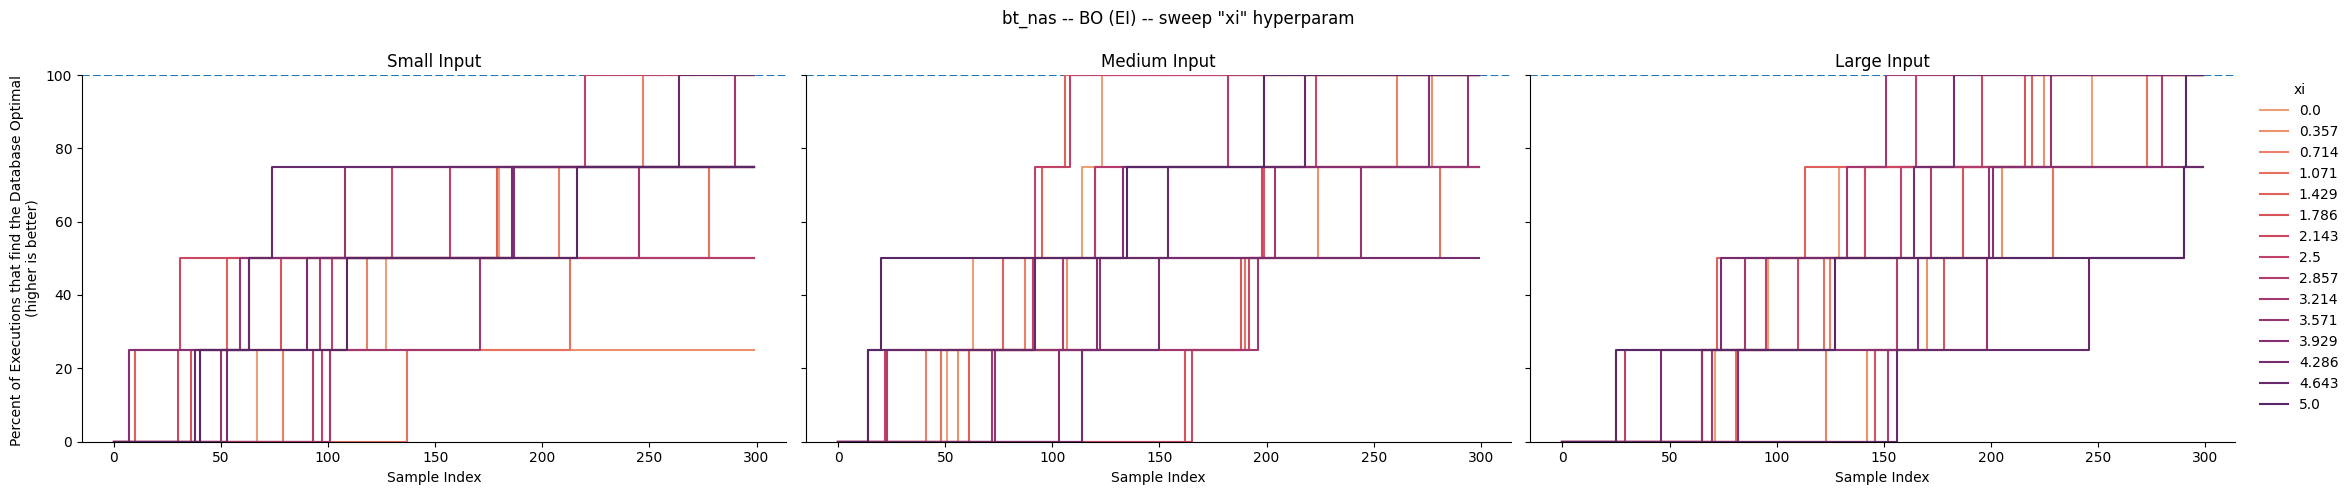

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-cg_nas-cma-GO_Data.csv
cg_nas cma popsize


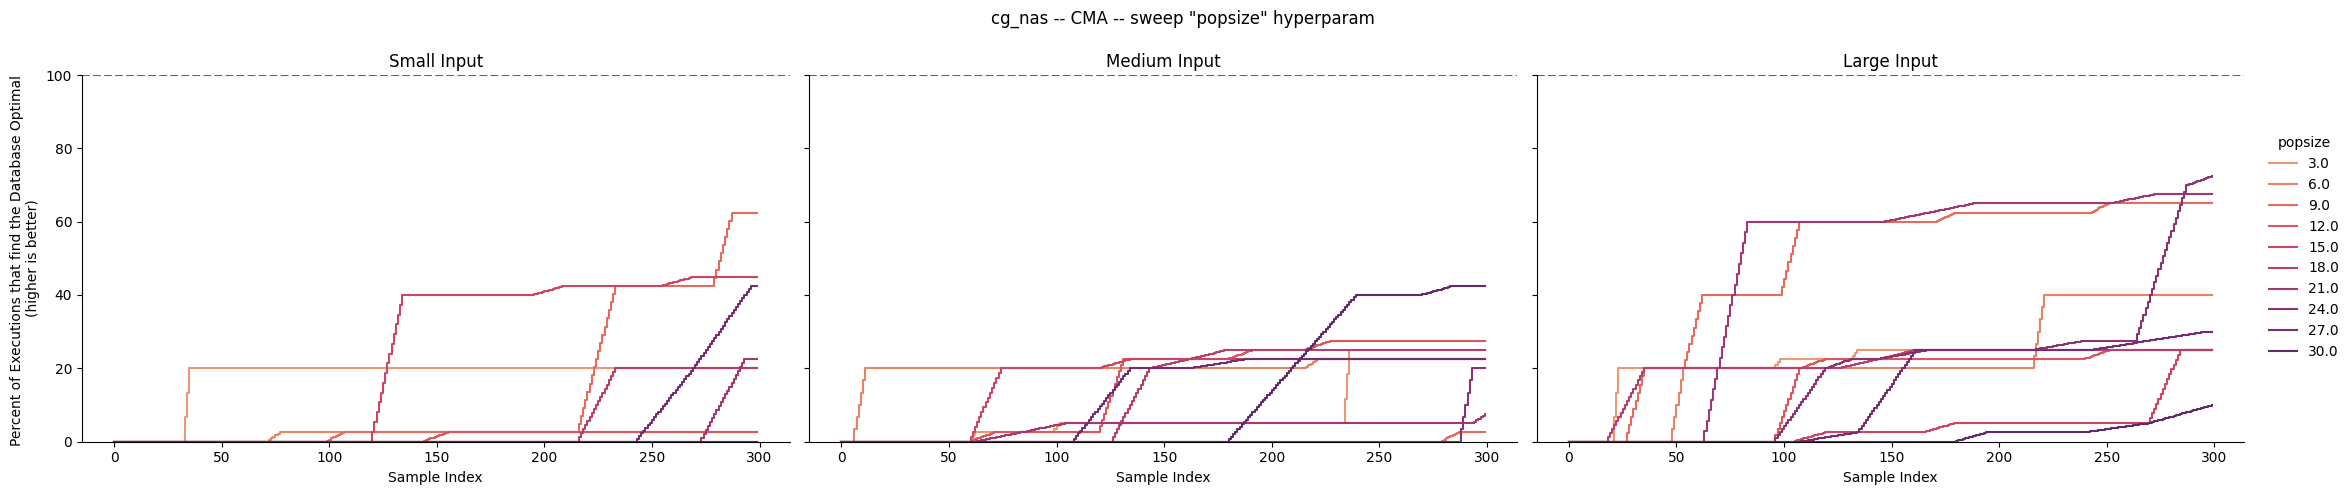

cg_nas cma sigma


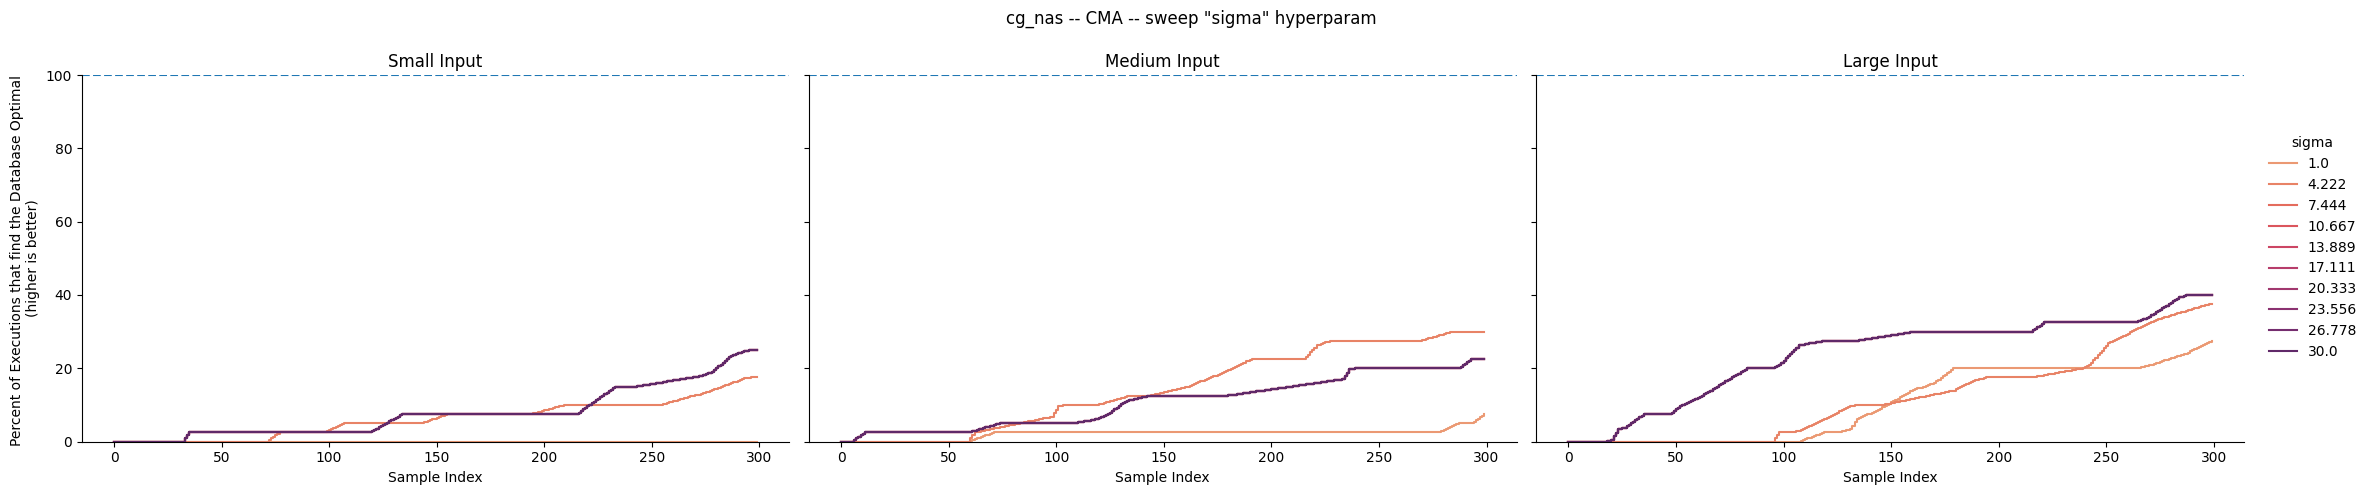

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-cg_nas-pso-GO_Data.csv
cg_nas pso popsize


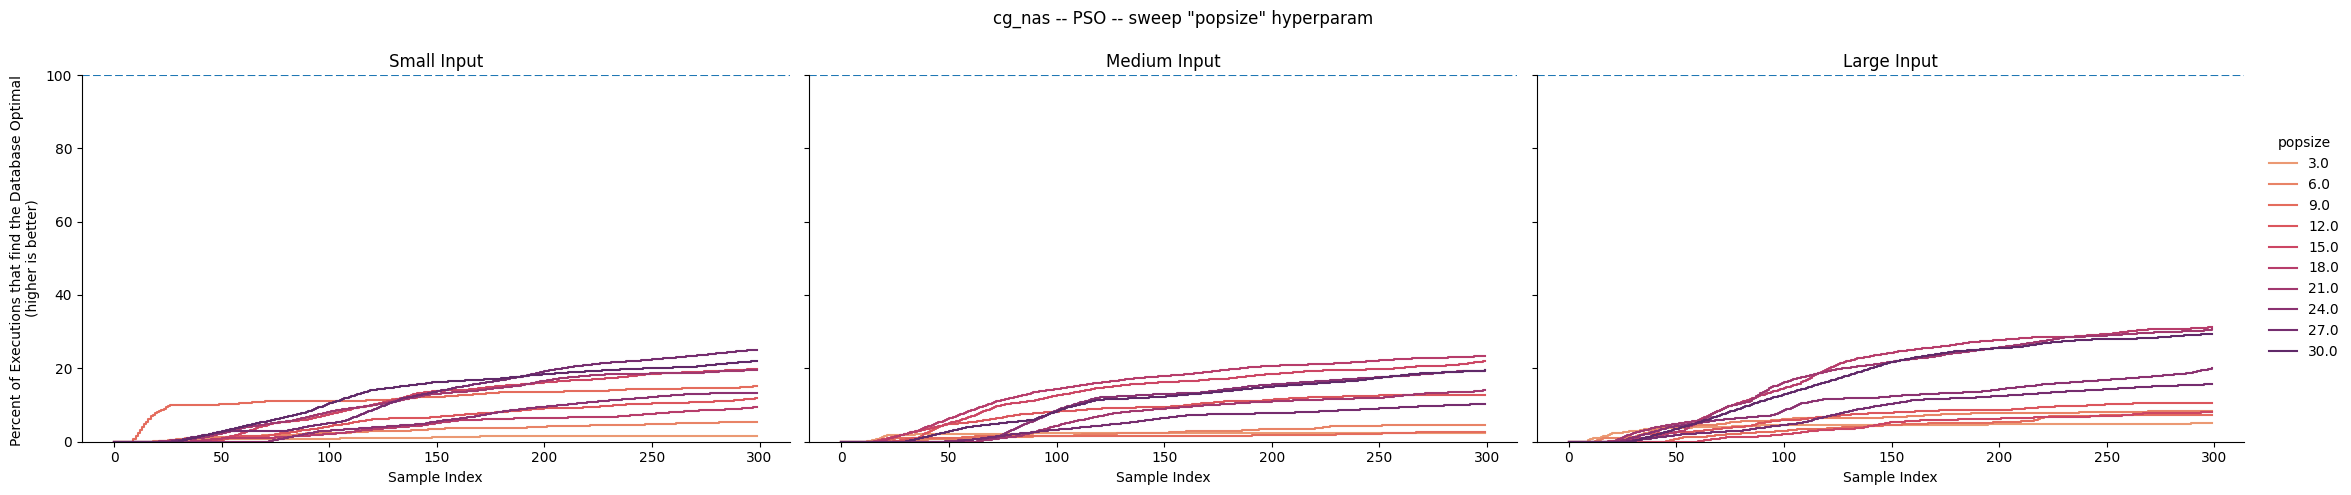

cg_nas pso w


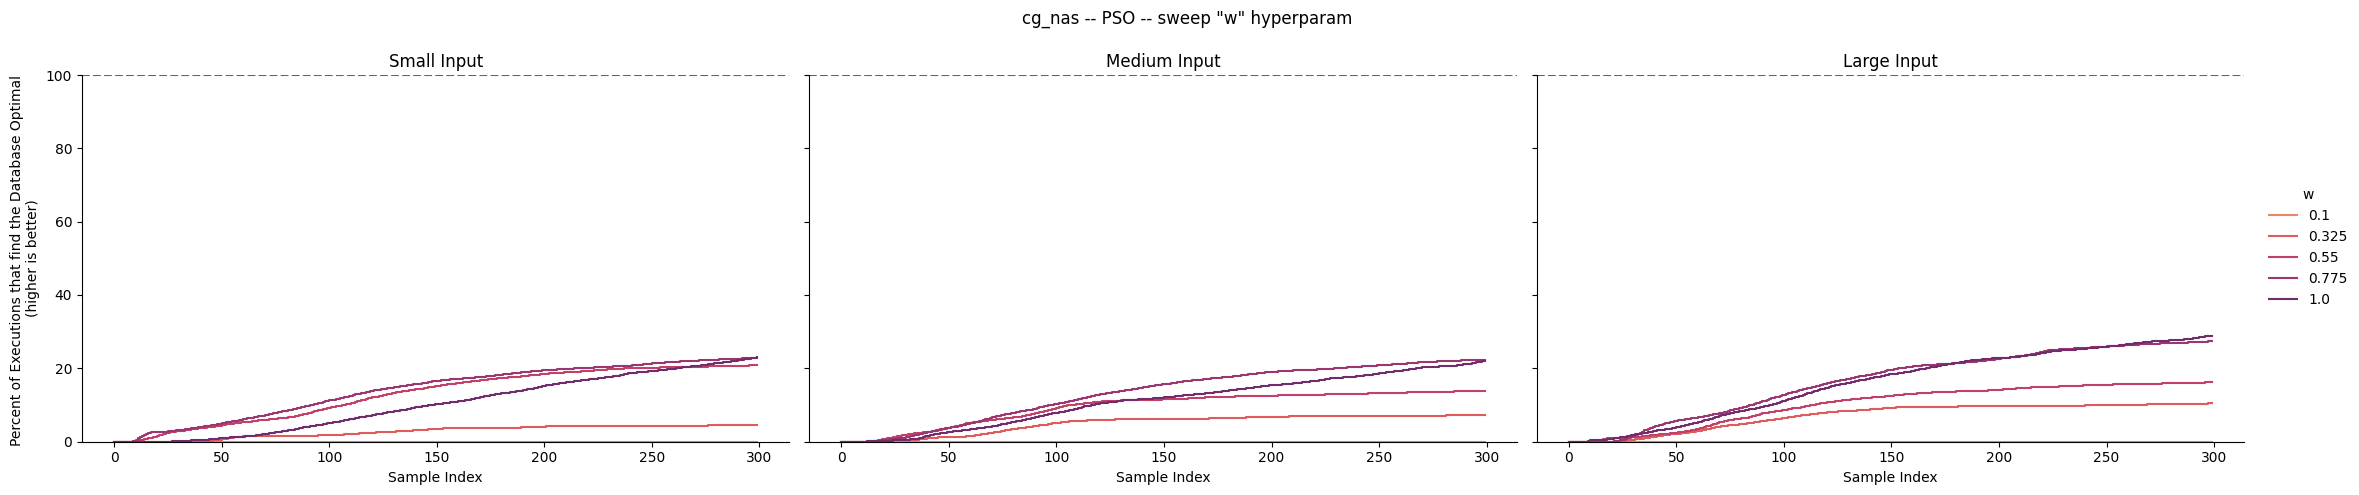

cg_nas pso c1


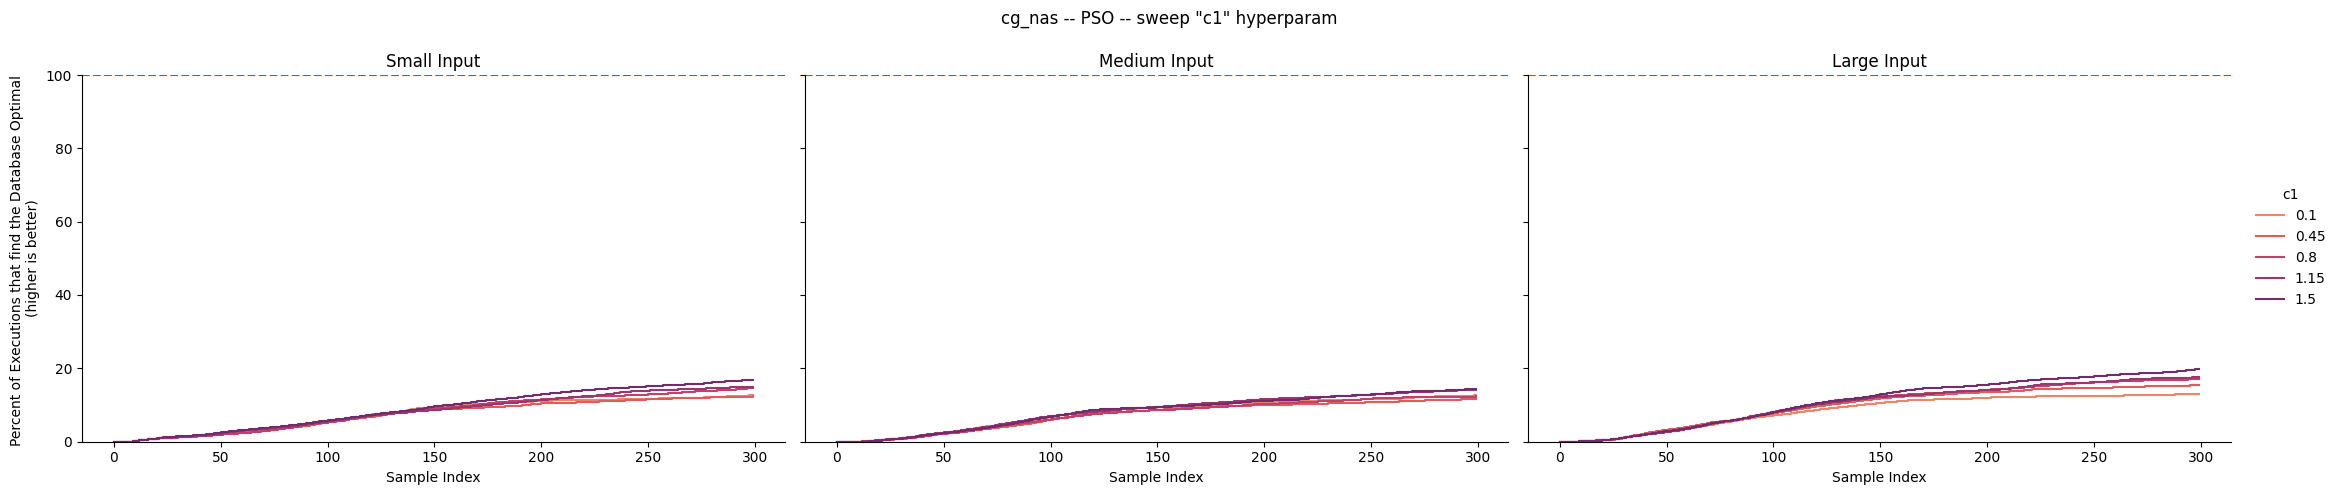

cg_nas pso c2


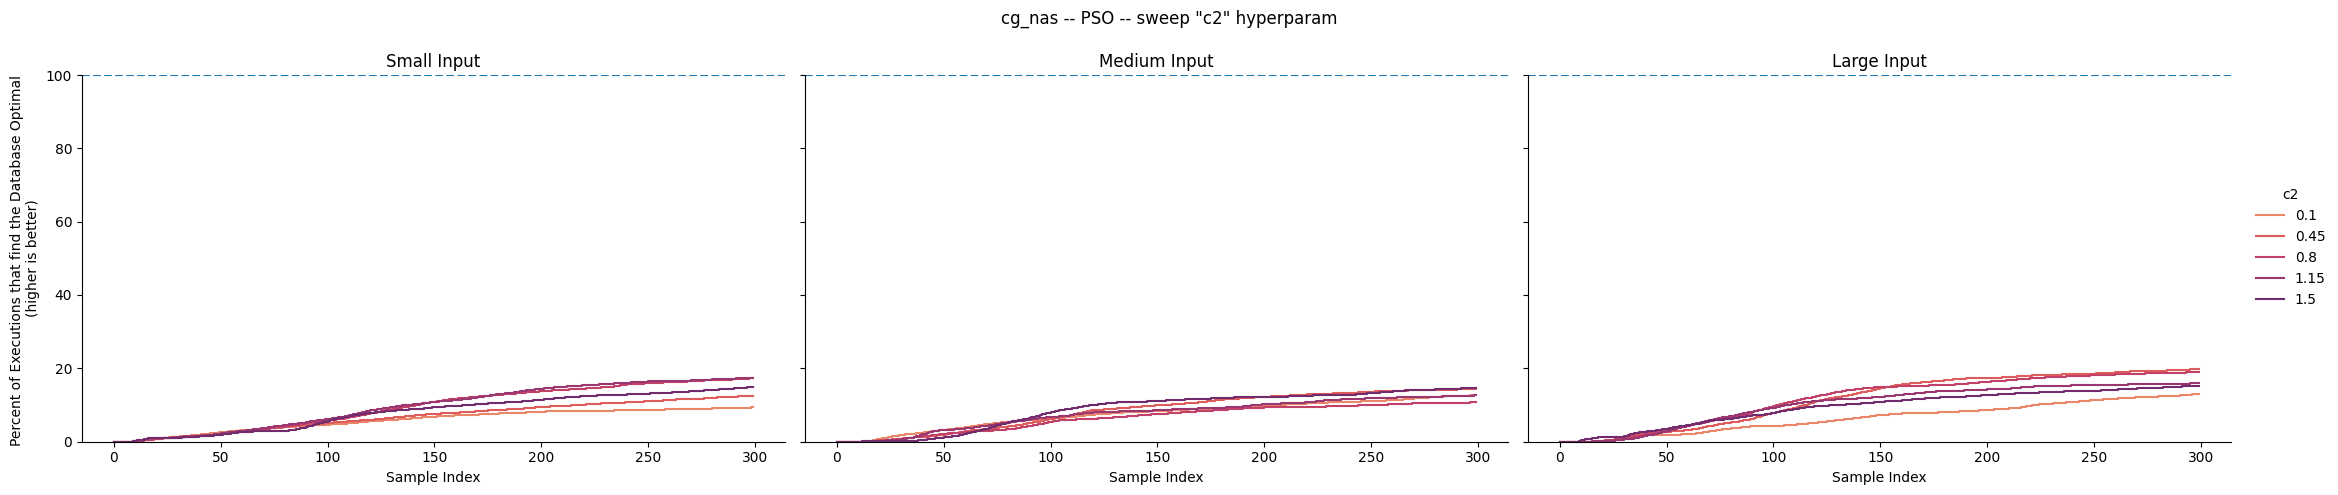

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-cg_nas-bo-GO_Data.csv
cg_nas bo utilFnct


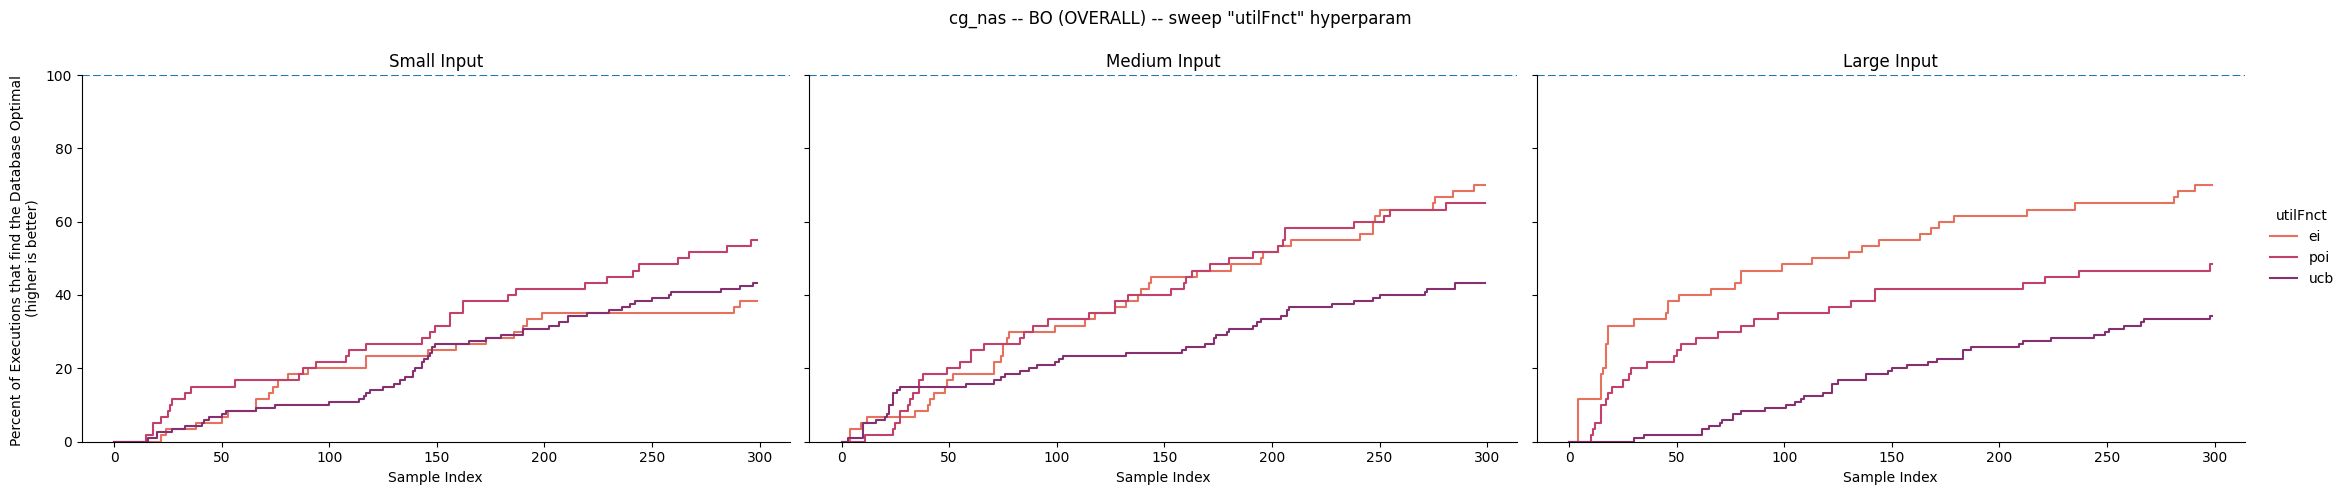

cg_nas bo ['kappa', 'kappa_decay', 'kappa_decay_delay']


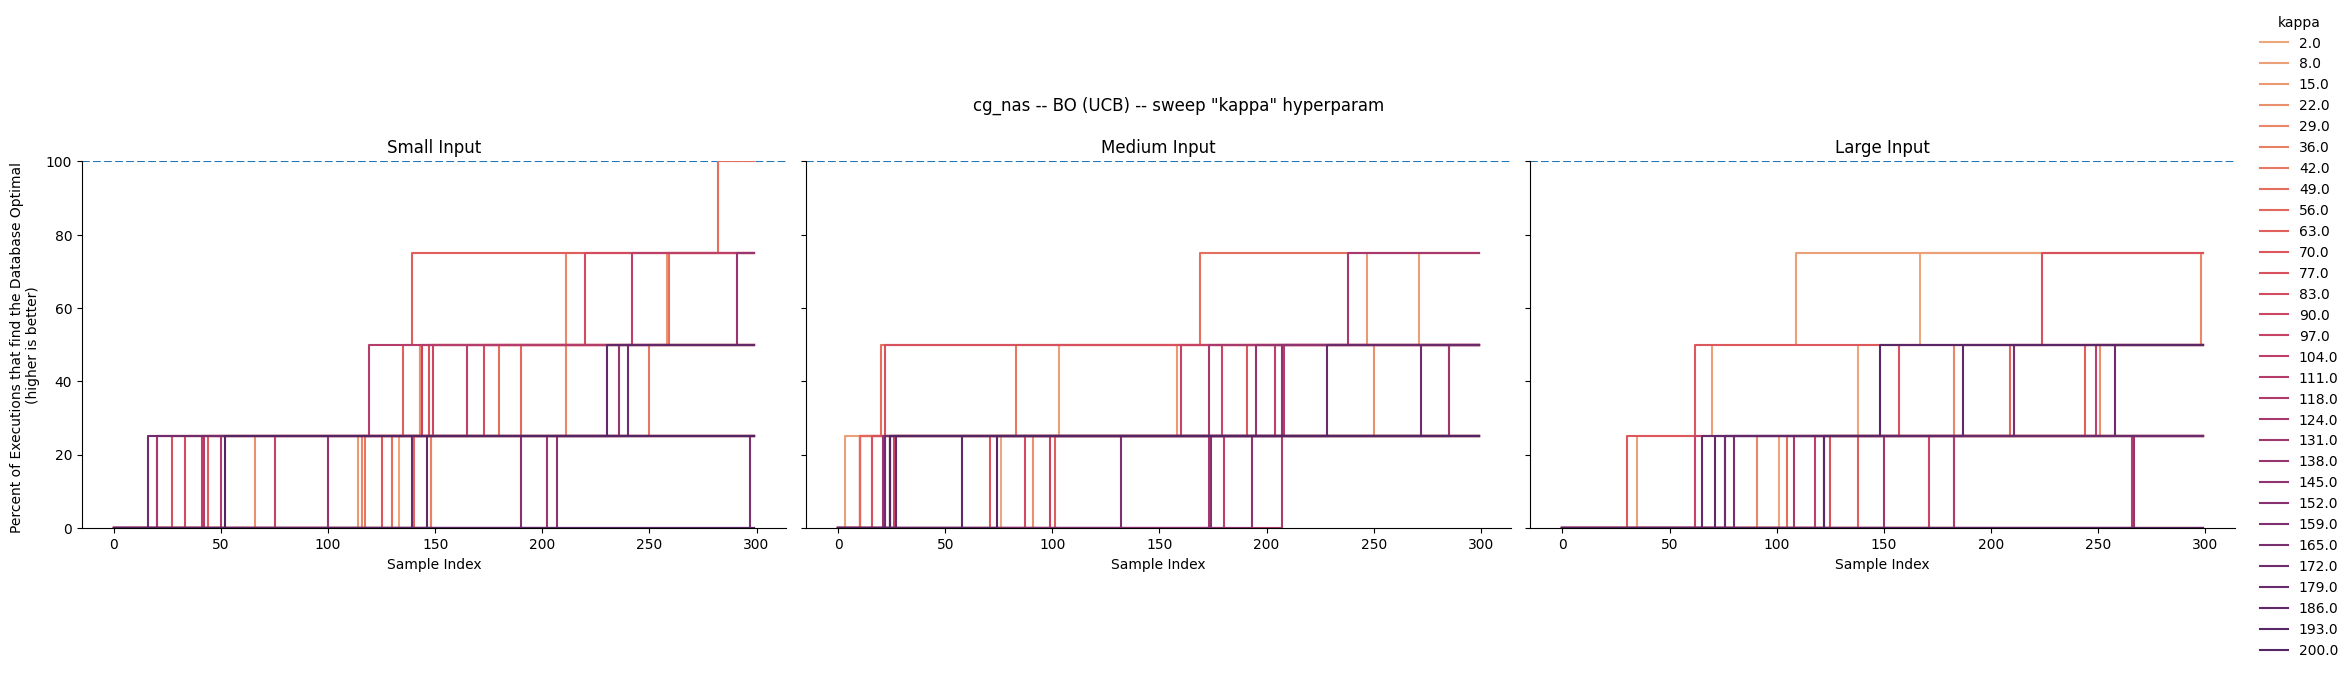

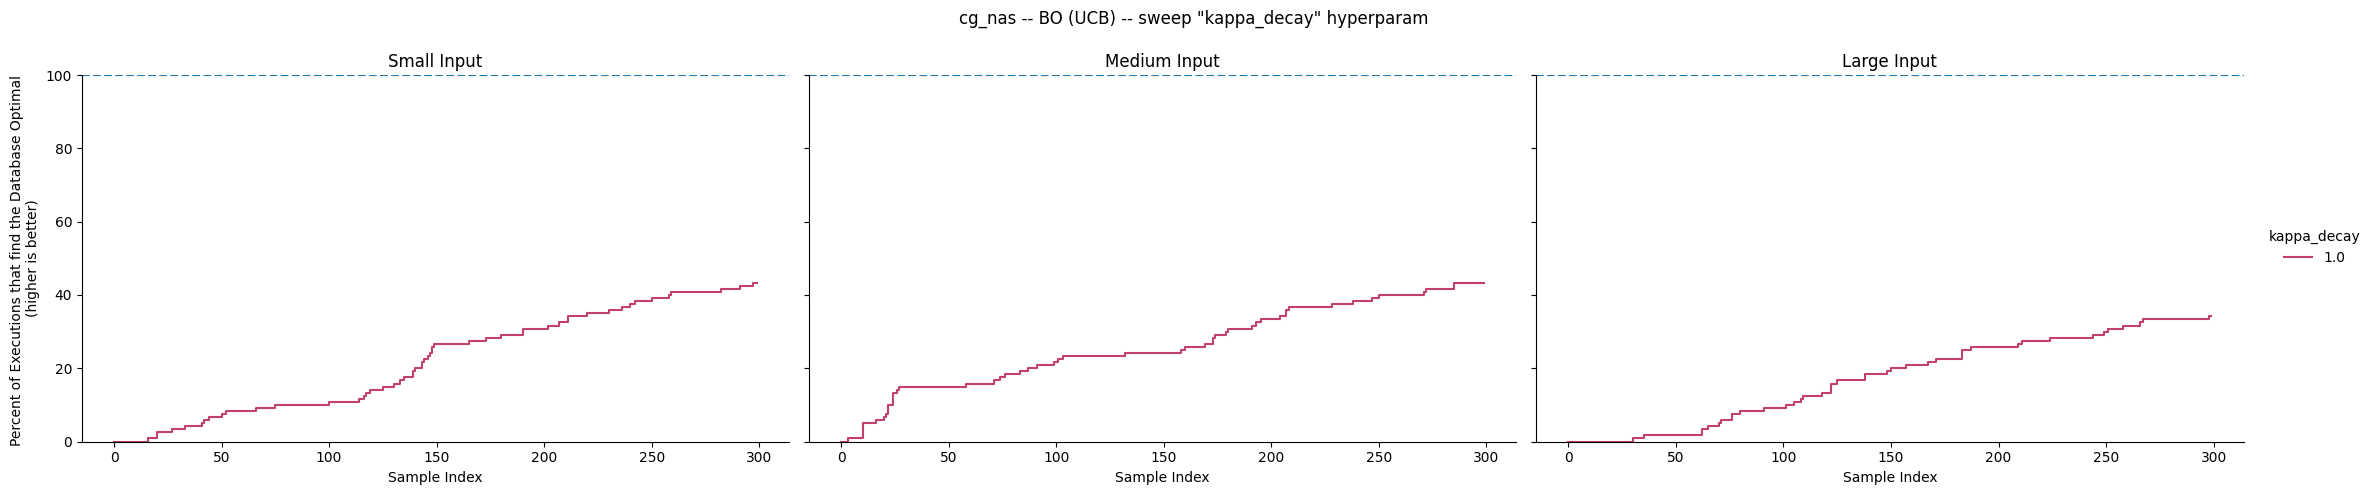

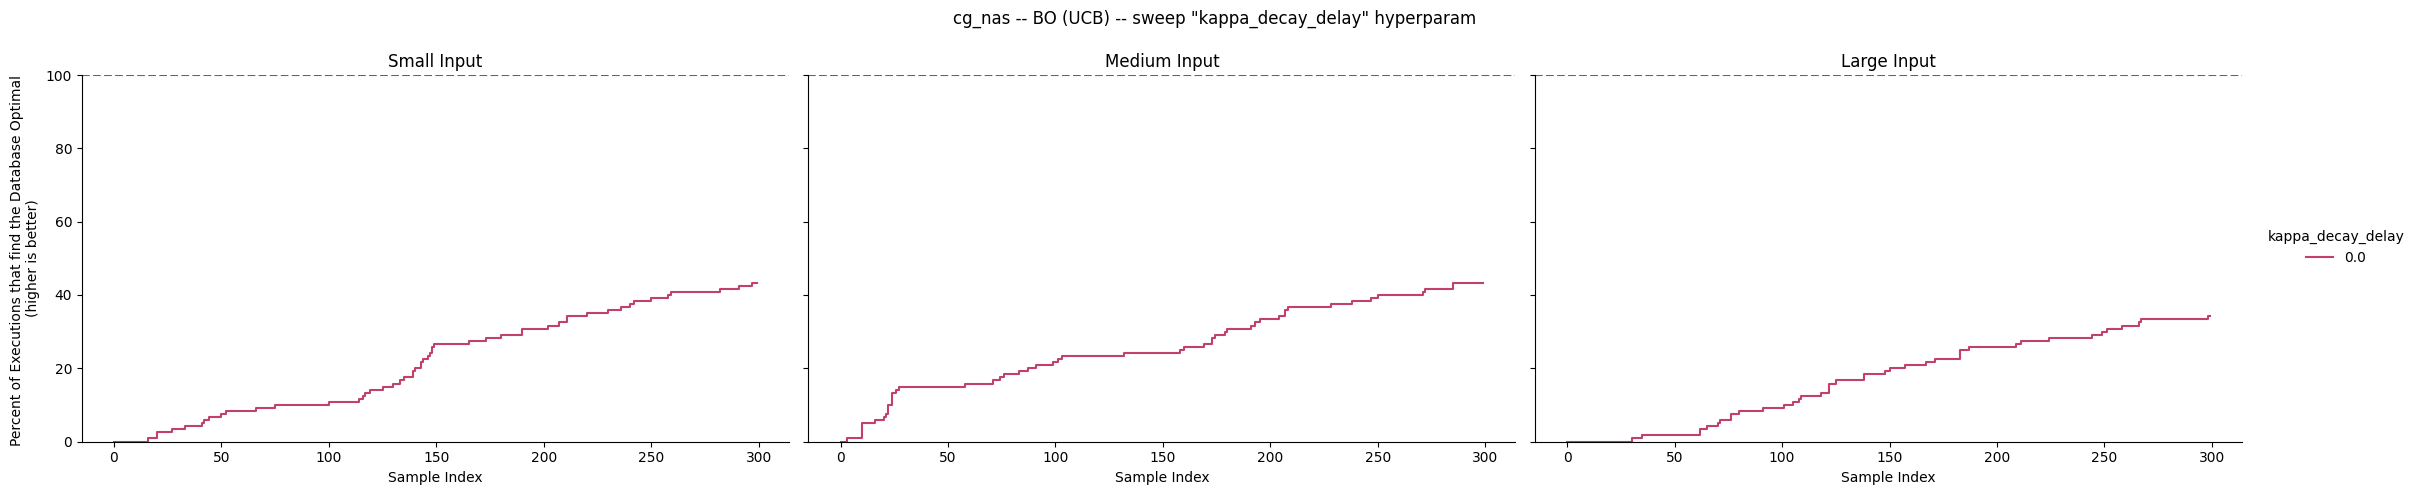

cg_nas bo ['xi']


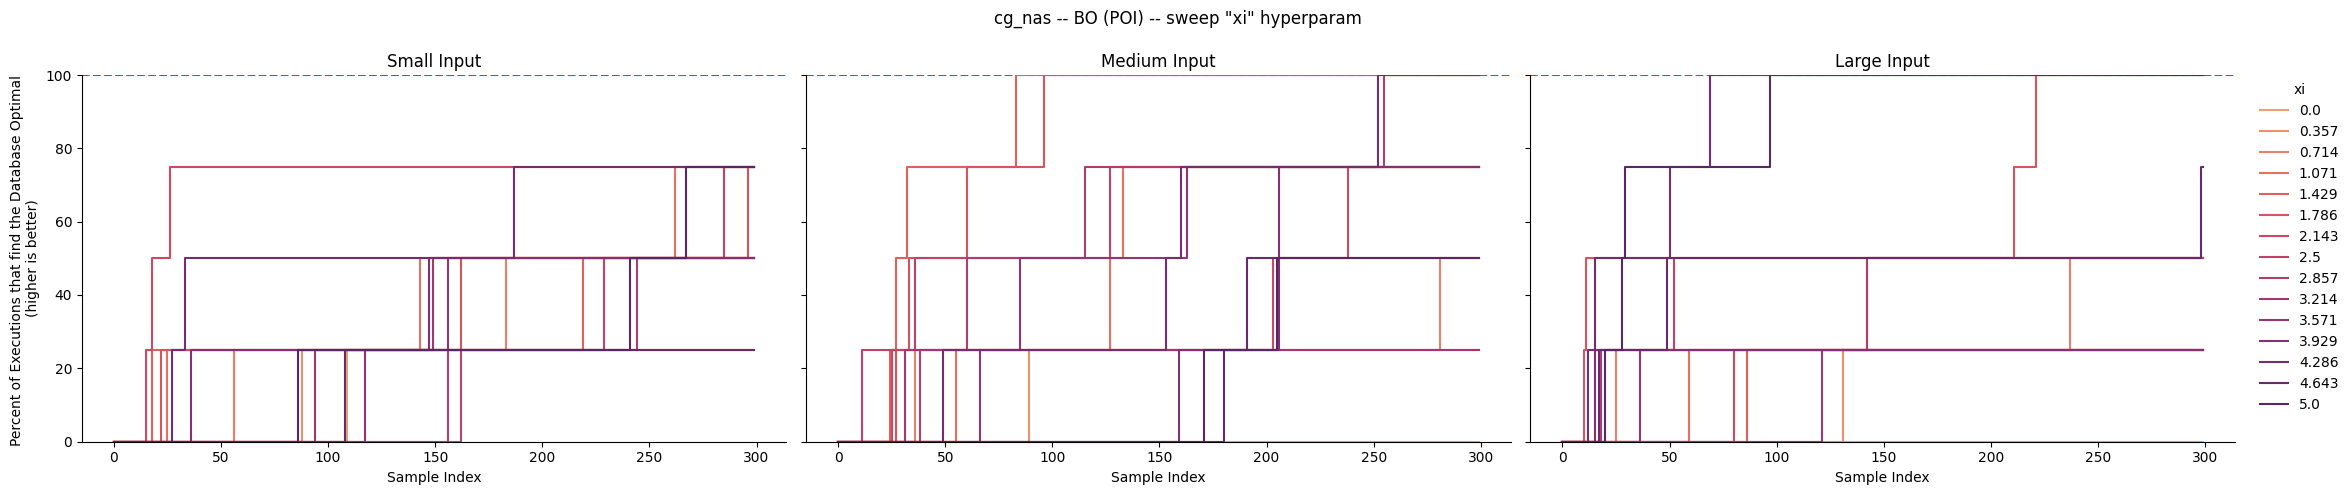

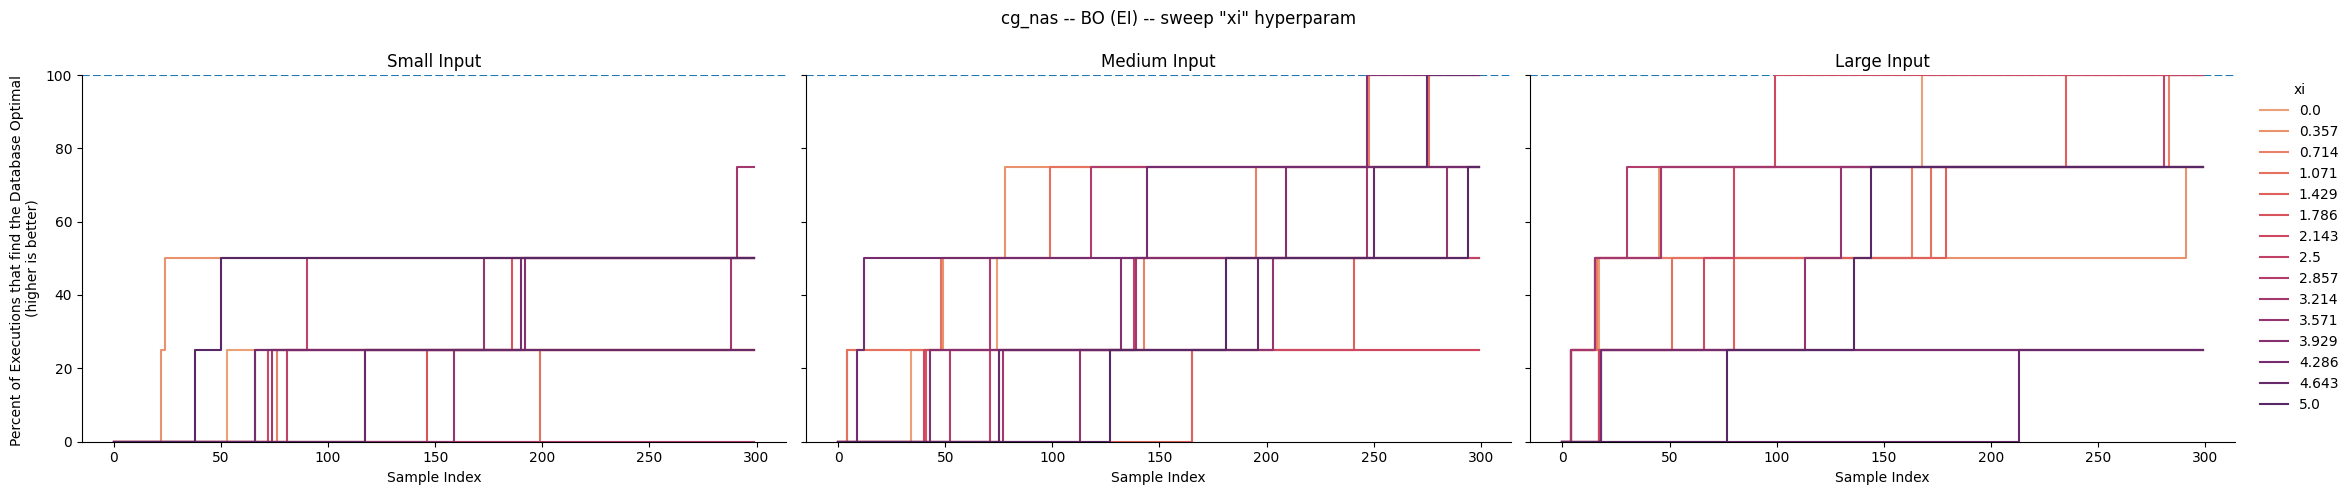

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-ft_nas-cma-GO_Data.csv
ft_nas cma popsize


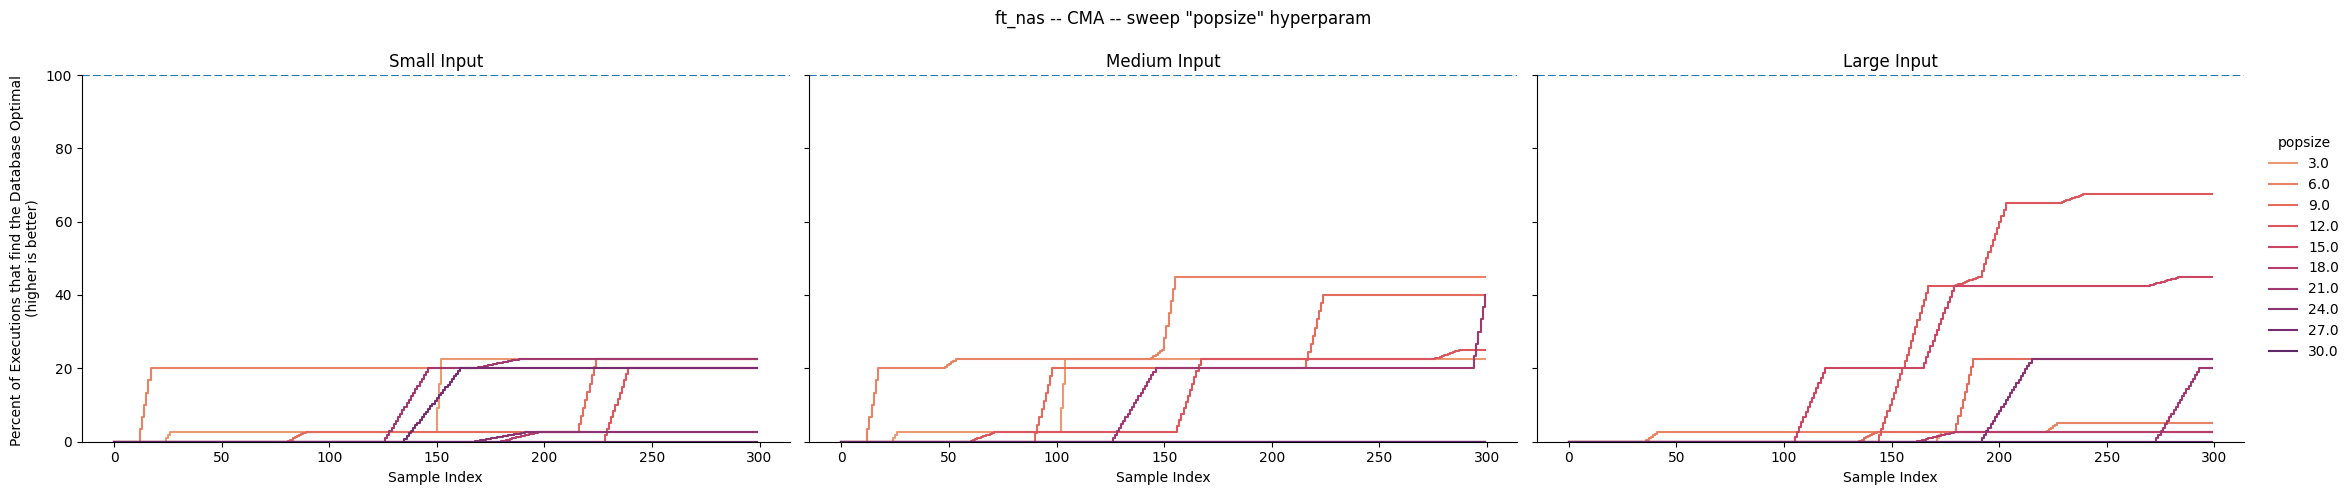

ft_nas cma sigma


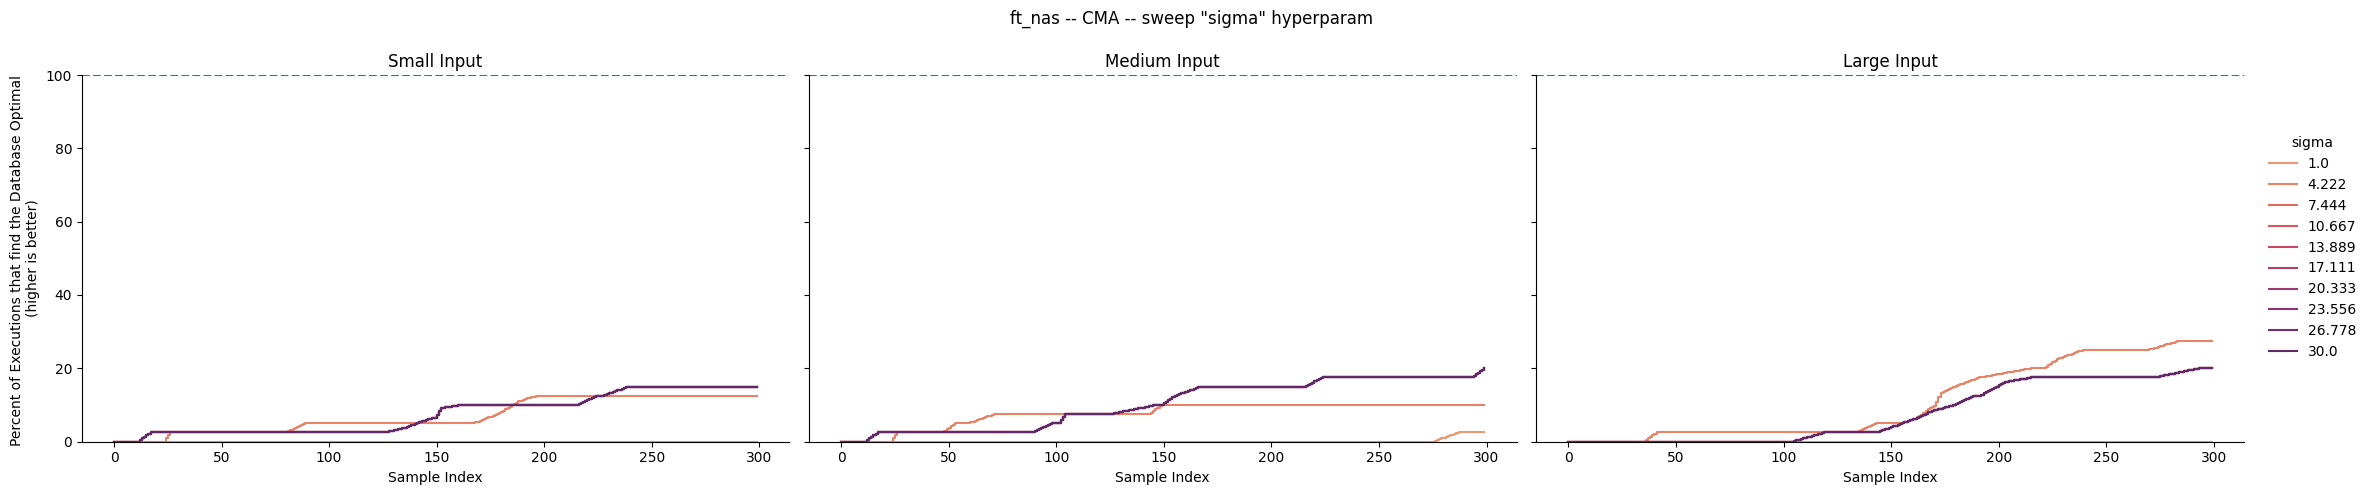

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-ft_nas-pso-GO_Data.csv
ft_nas pso popsize


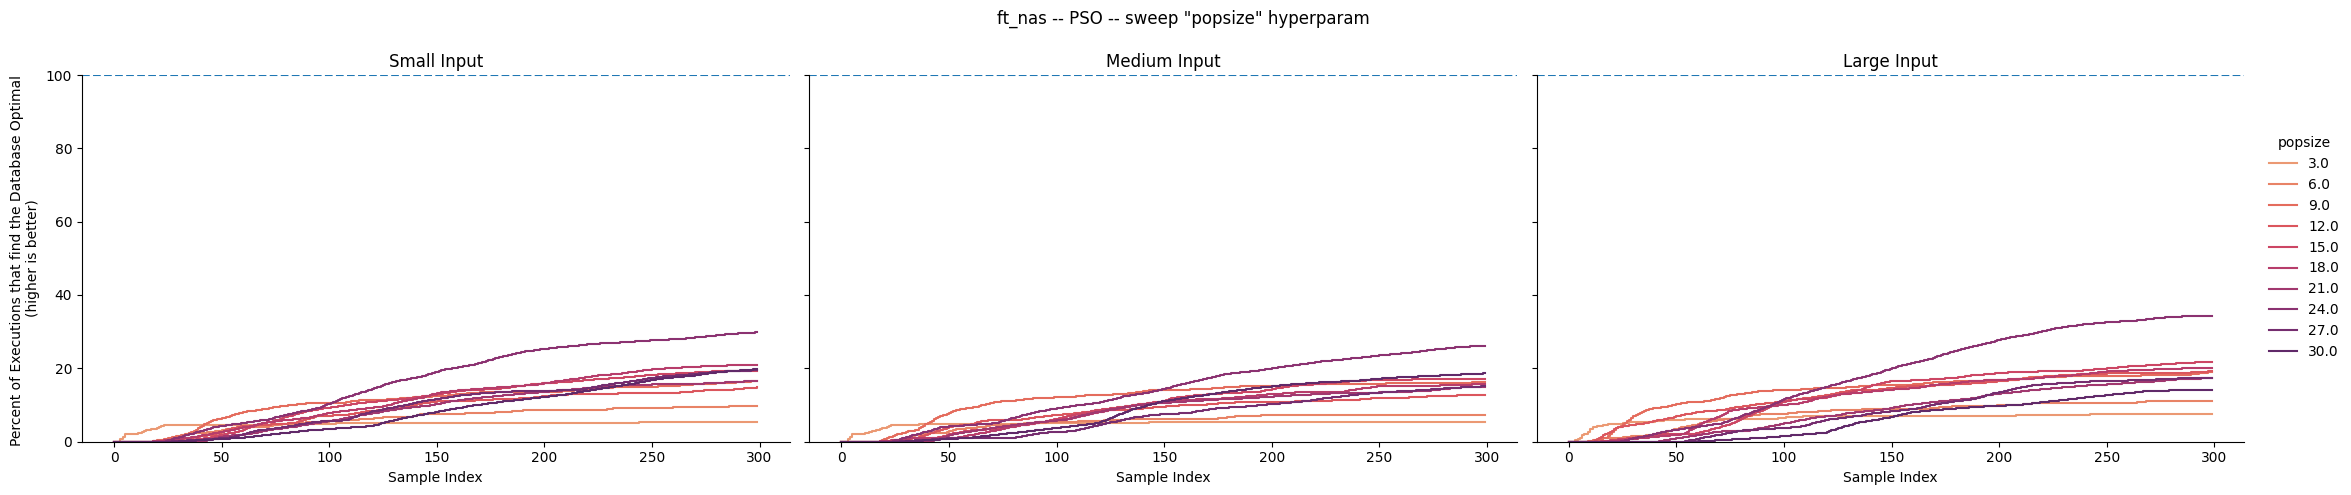

ft_nas pso w


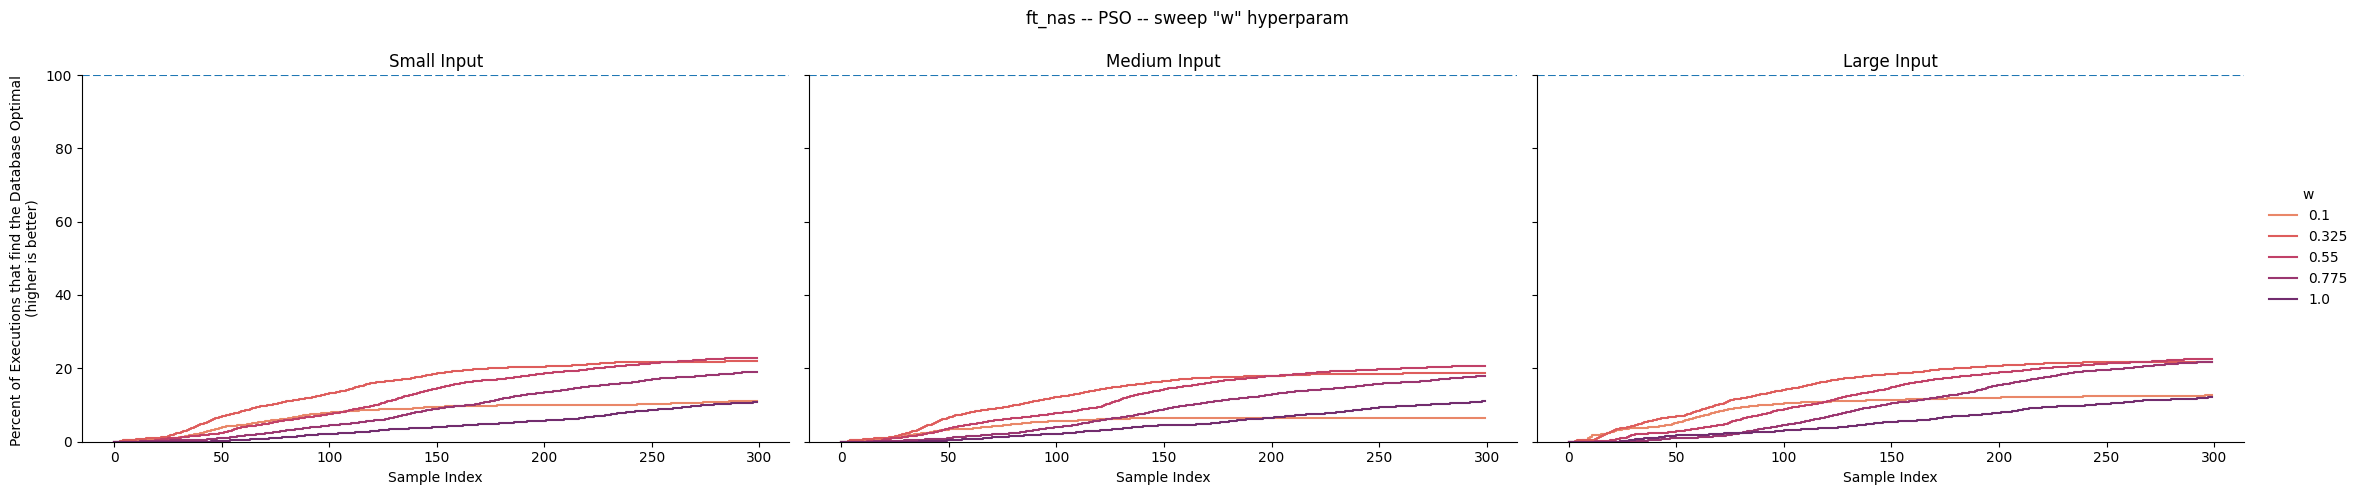

ft_nas pso c1


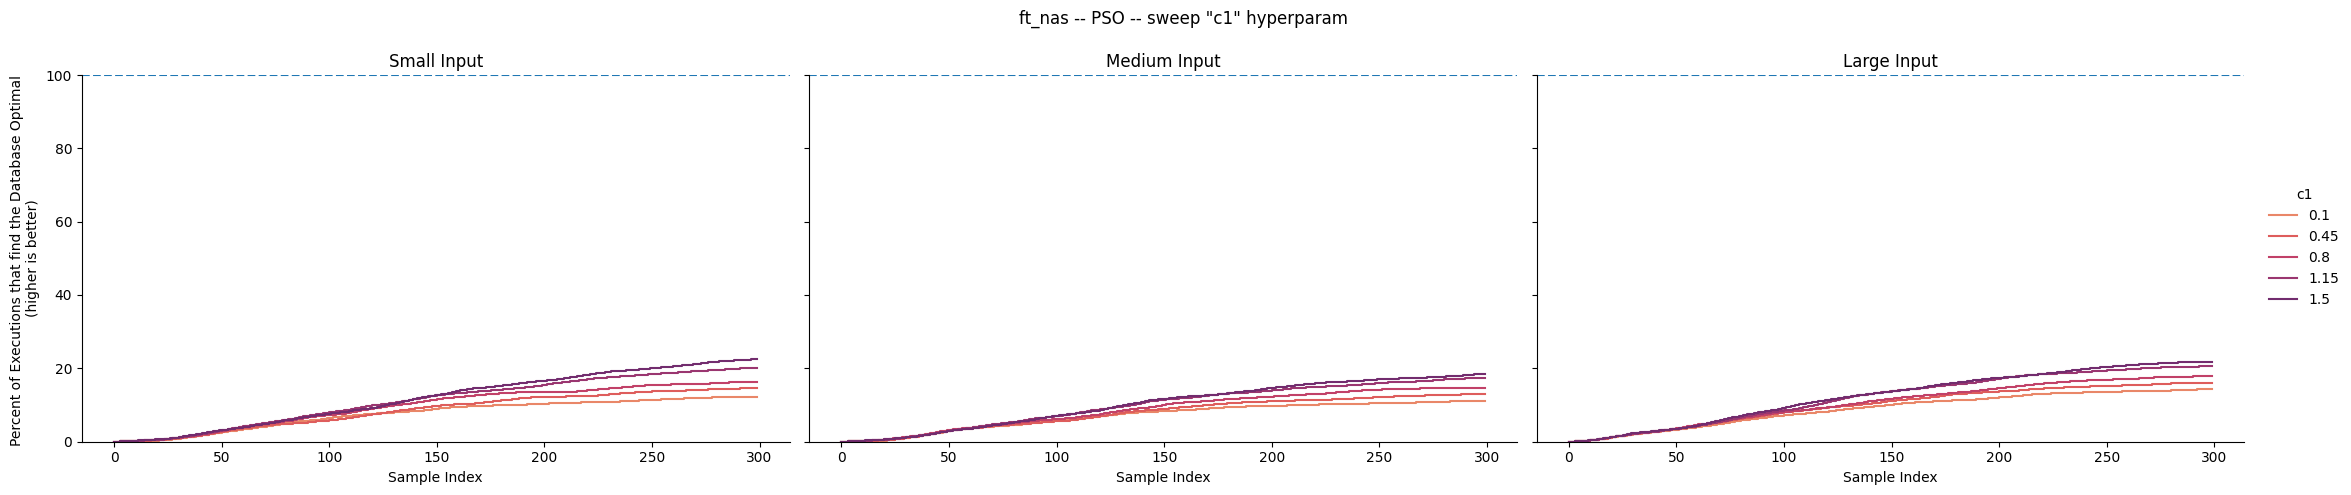

ft_nas pso c2


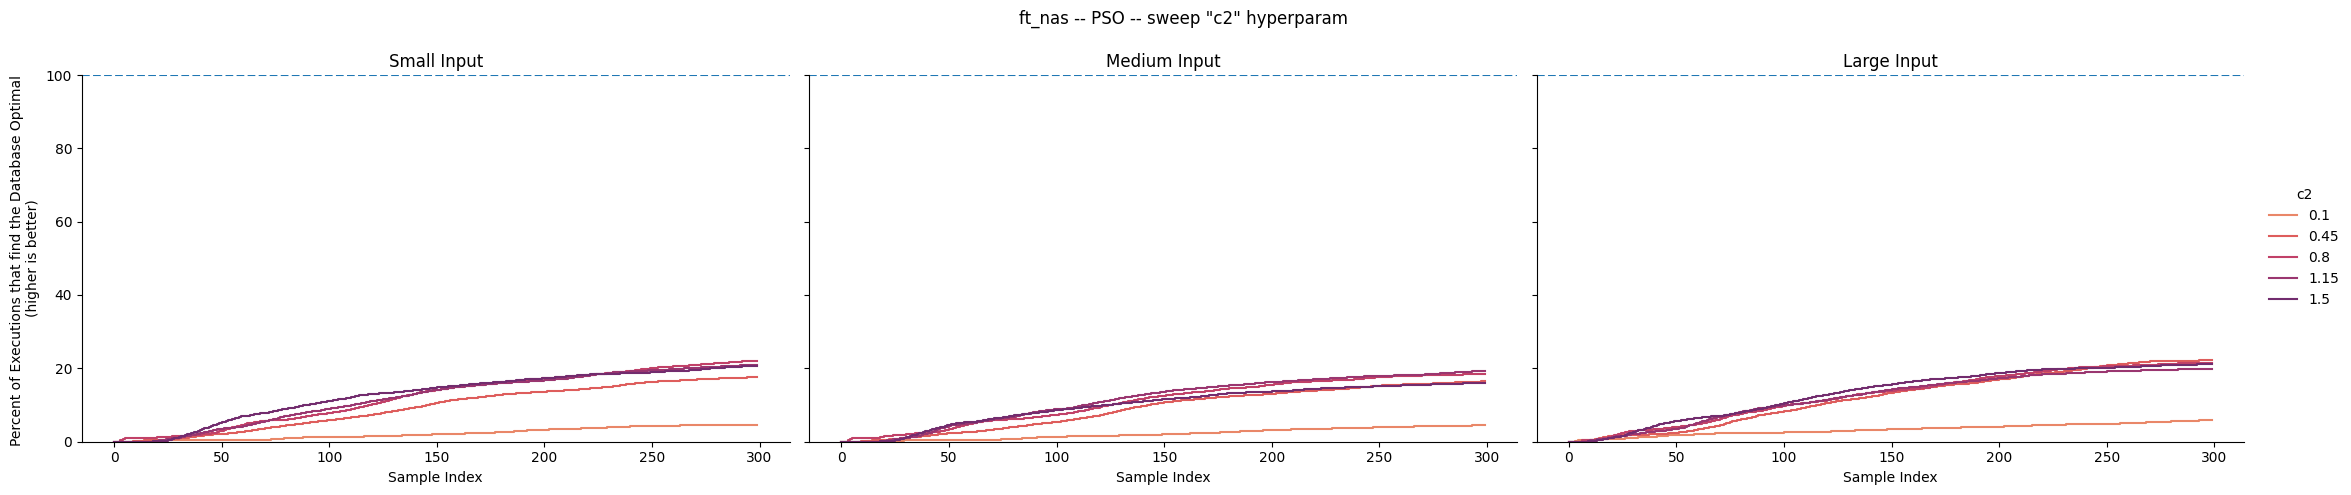

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-ft_nas-bo-GO_Data.csv
ft_nas bo utilFnct


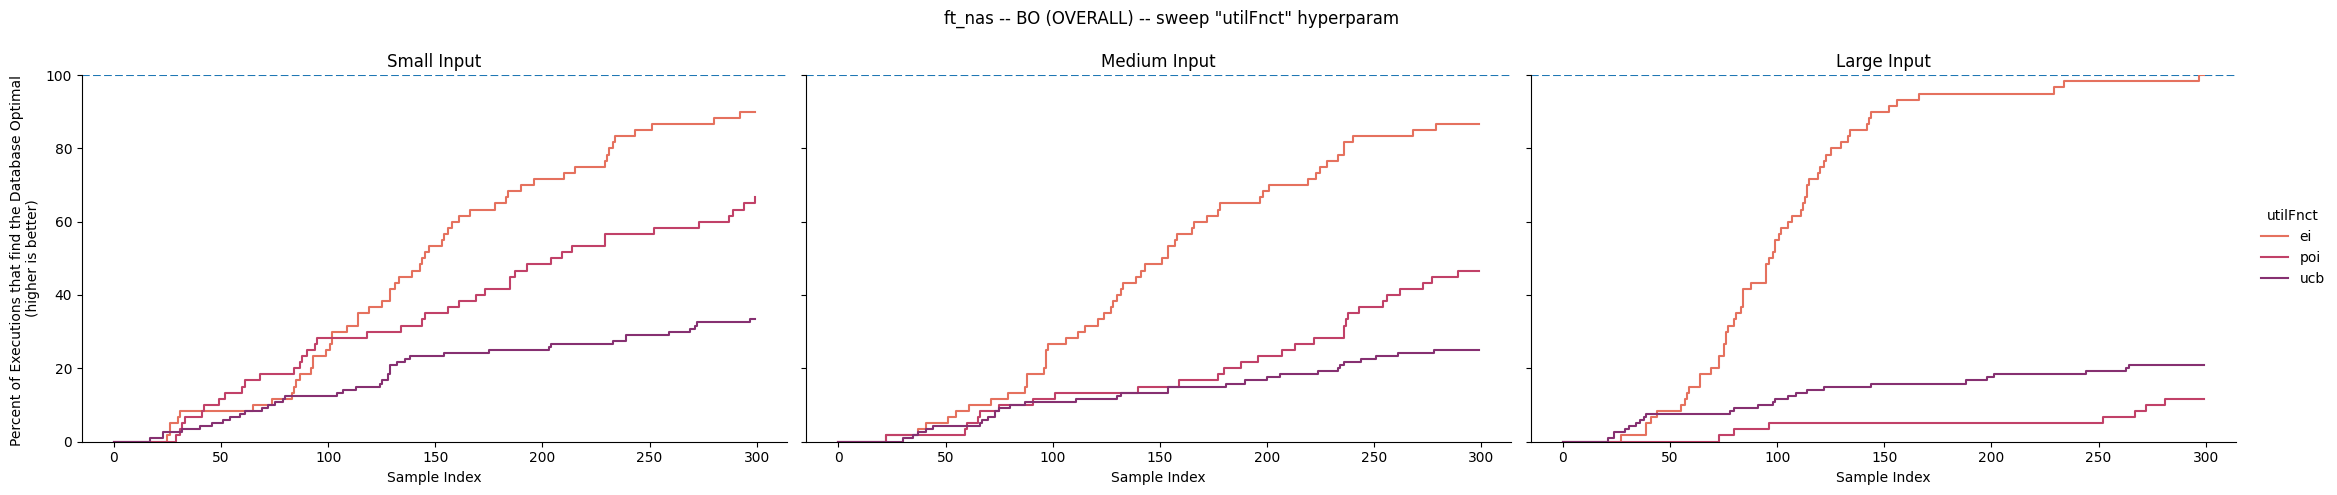

ft_nas bo ['kappa', 'kappa_decay', 'kappa_decay_delay']


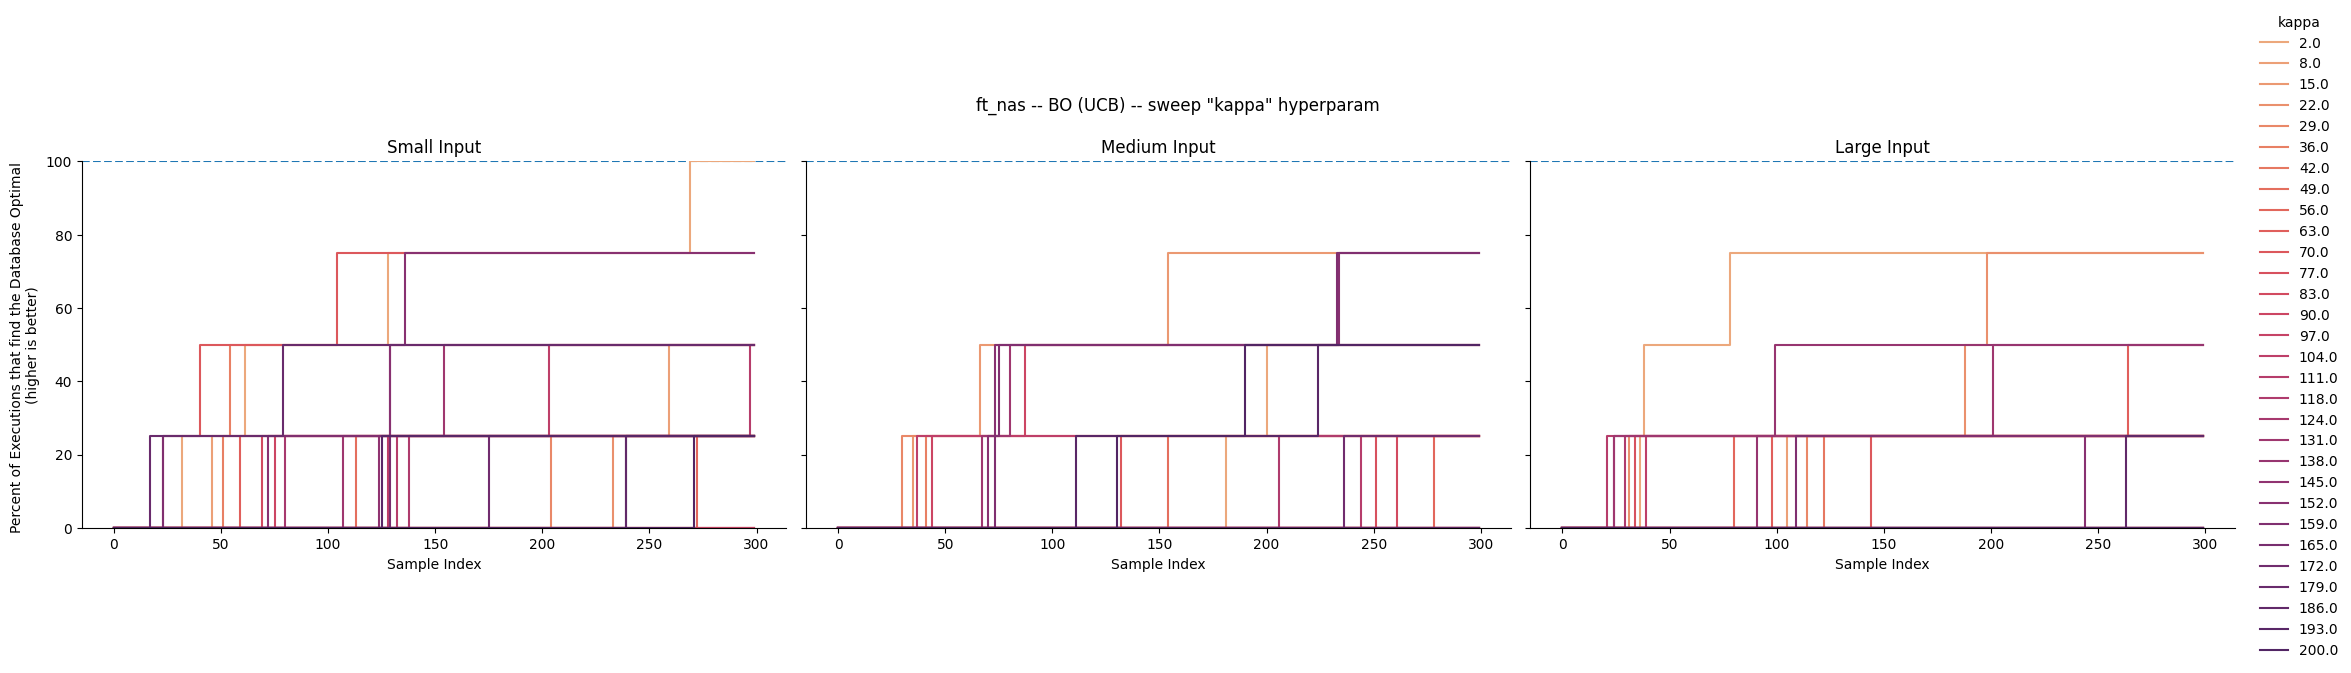

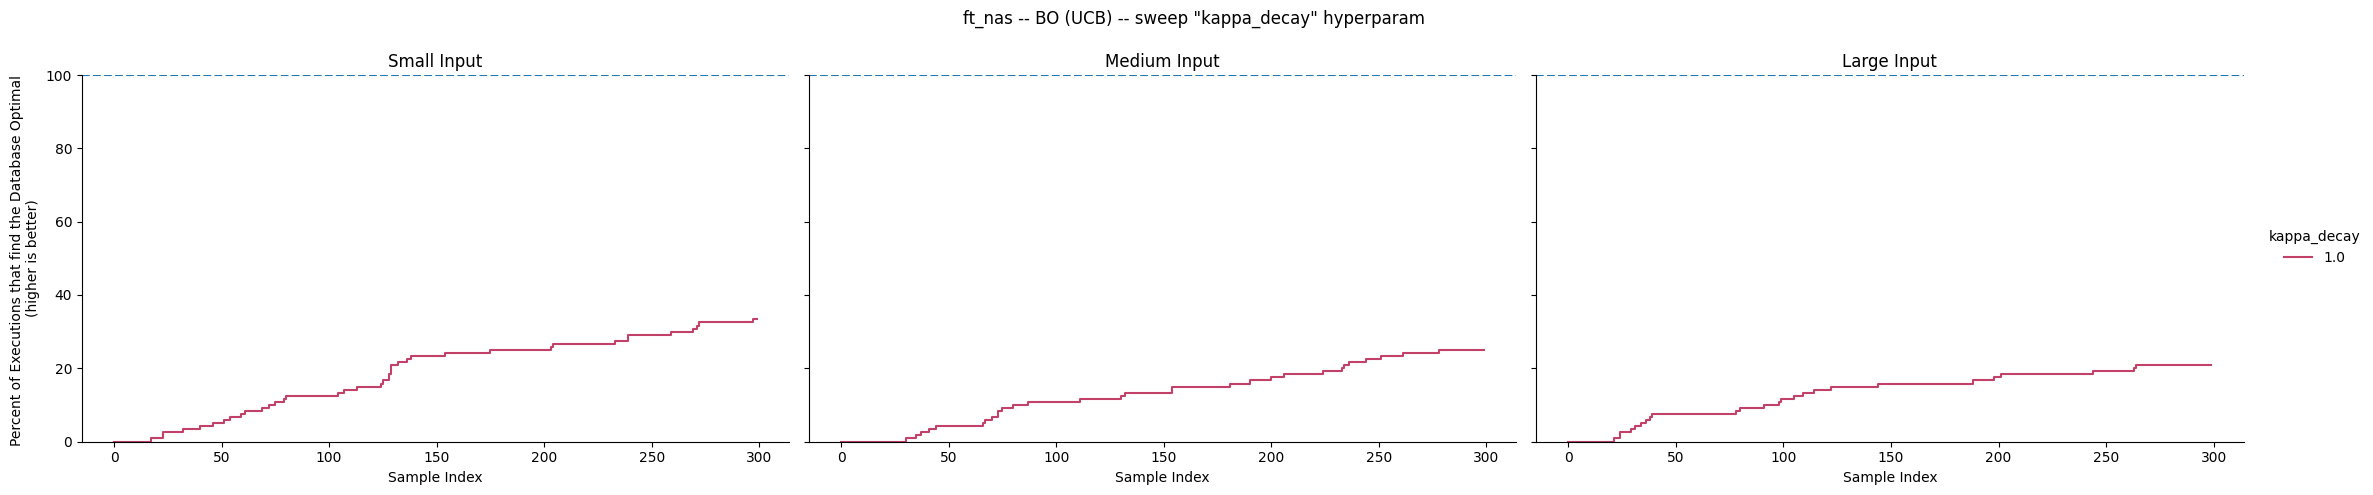

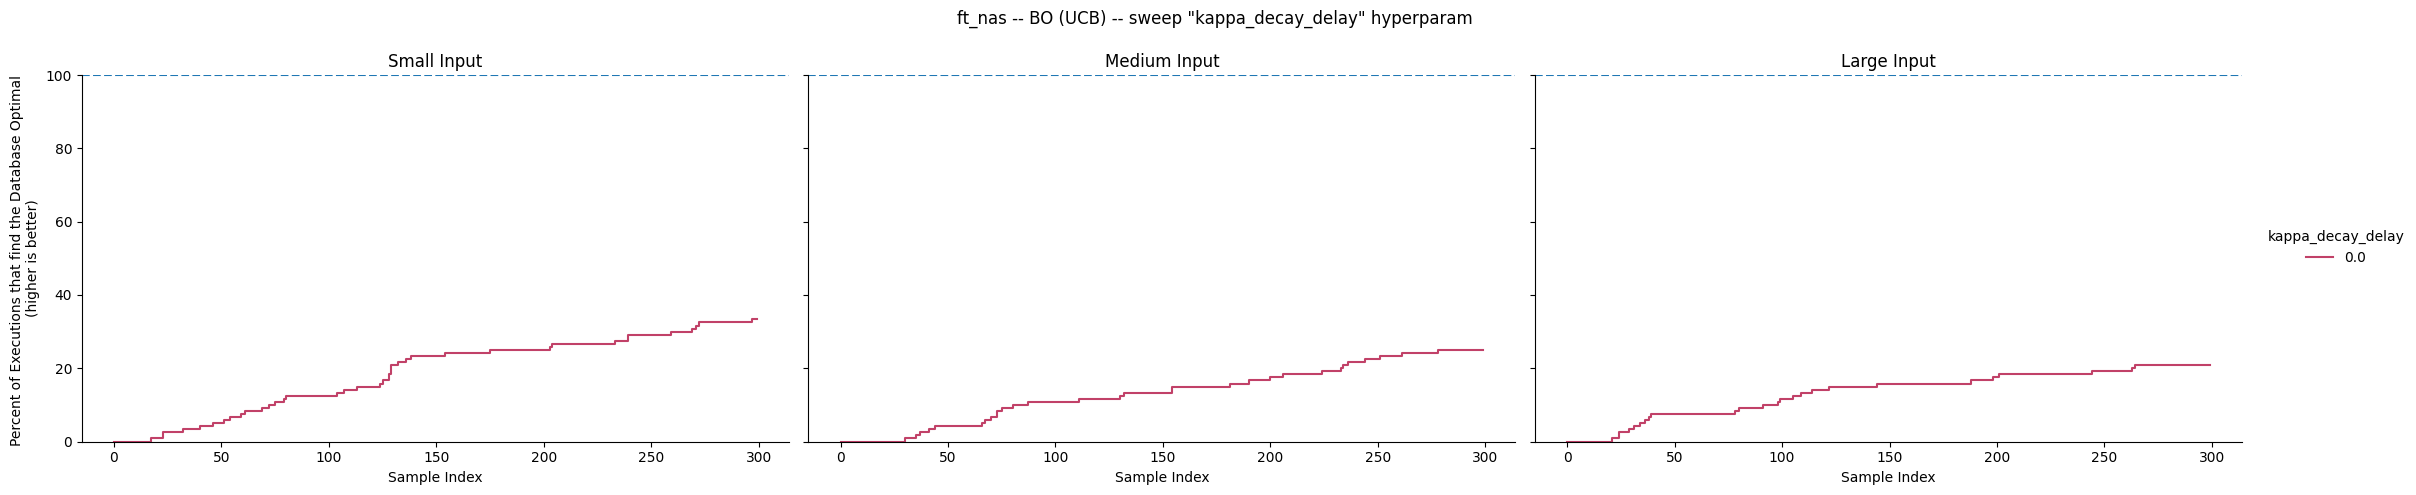

ft_nas bo ['xi']


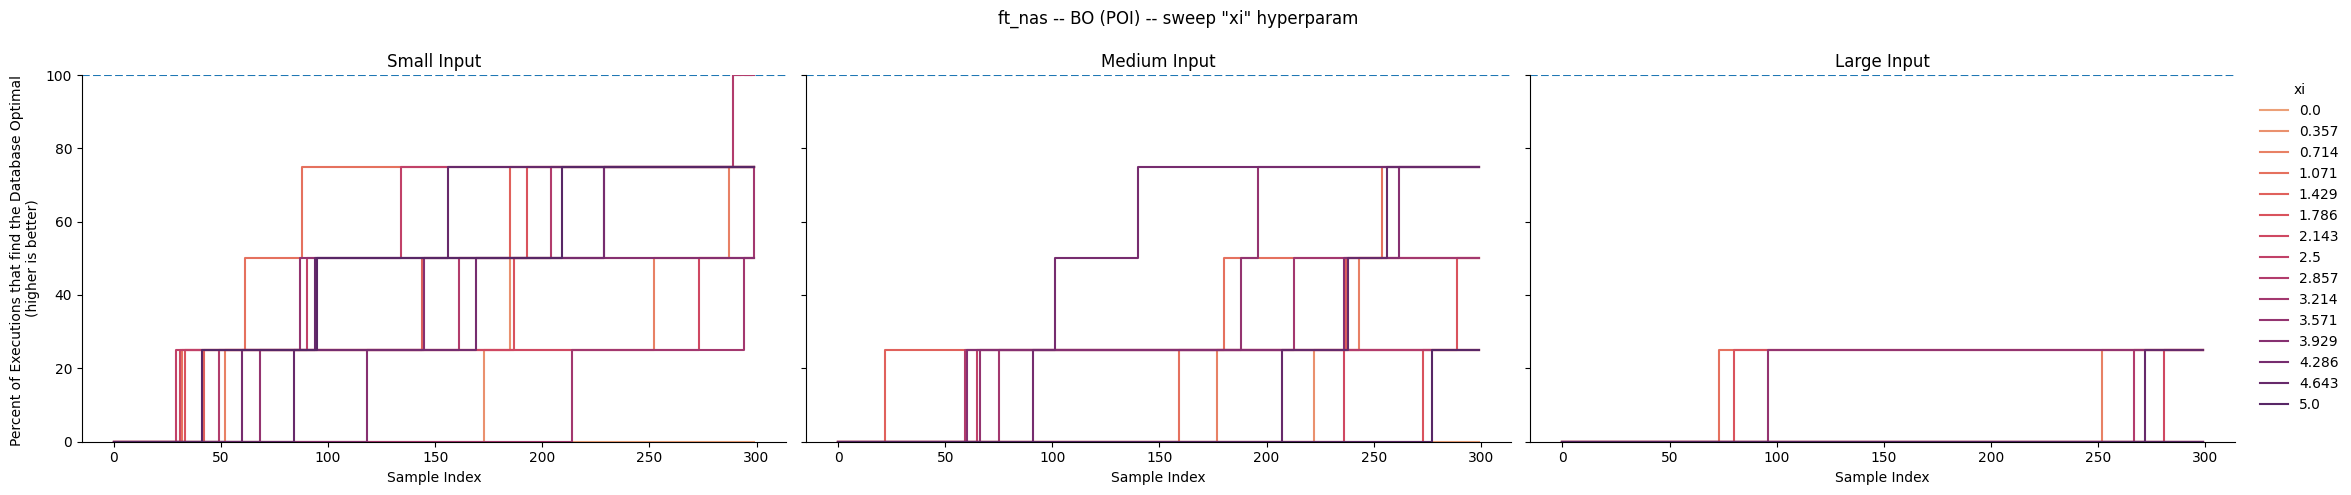

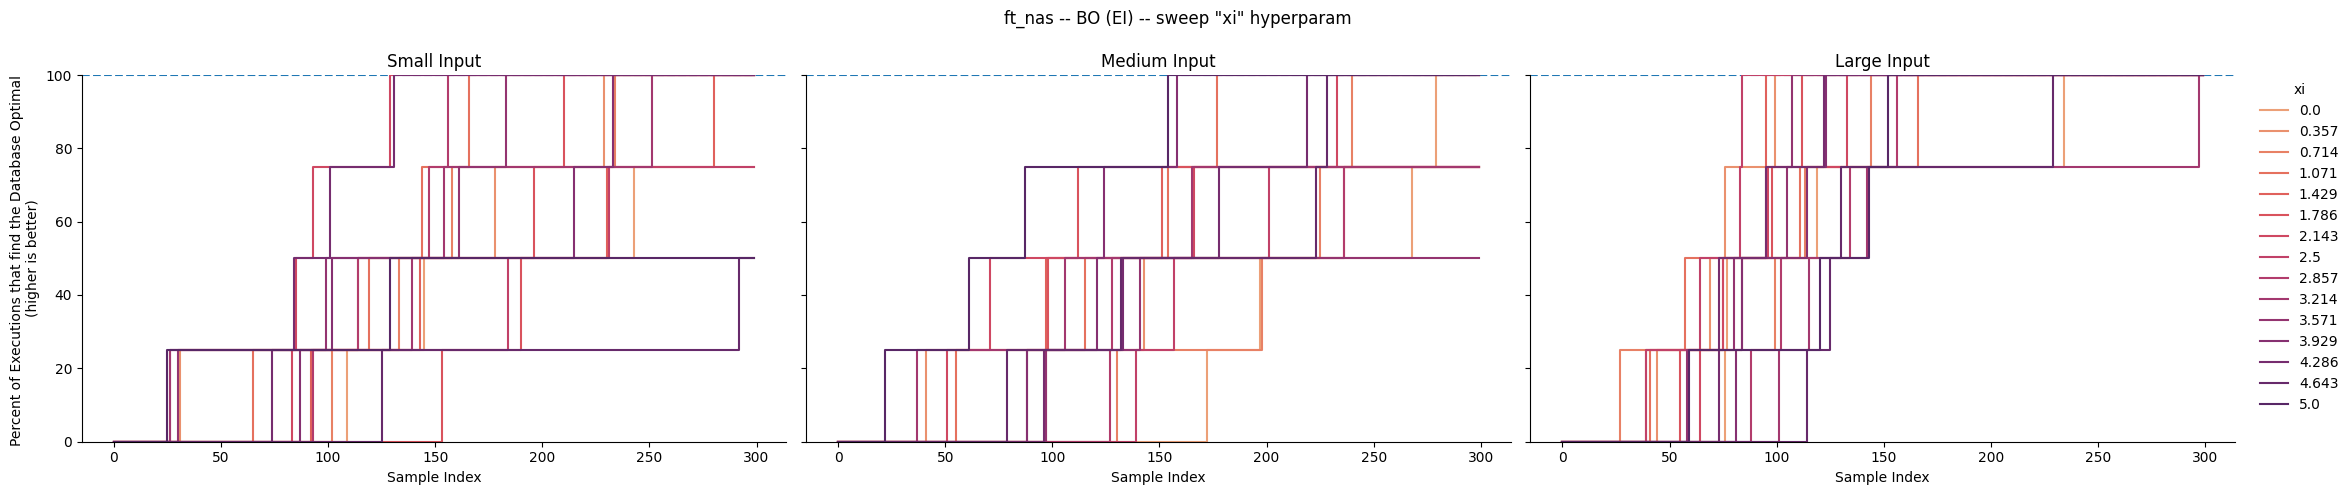

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-hpcg-cma-GO_Data.csv
hpcg cma popsize


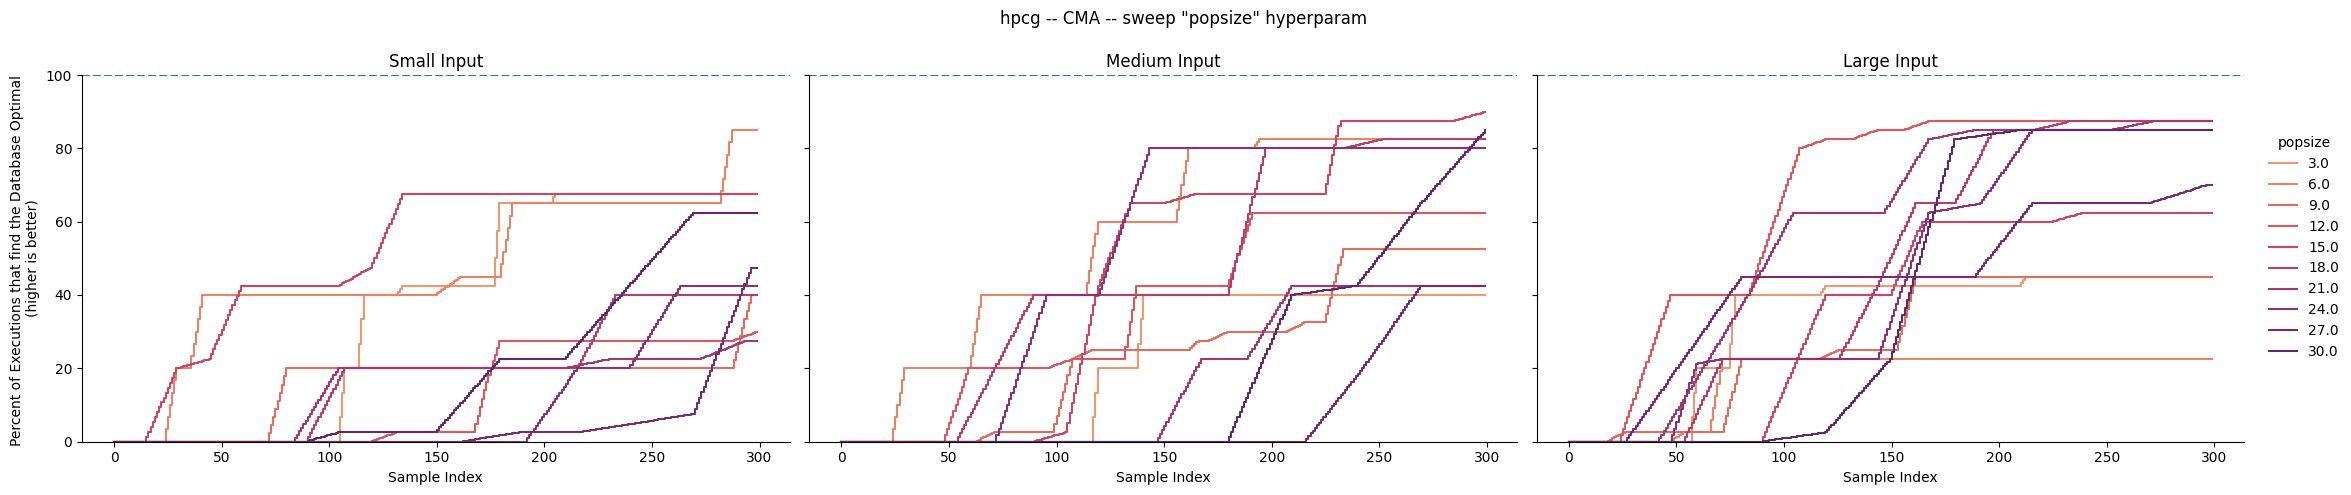

hpcg cma sigma


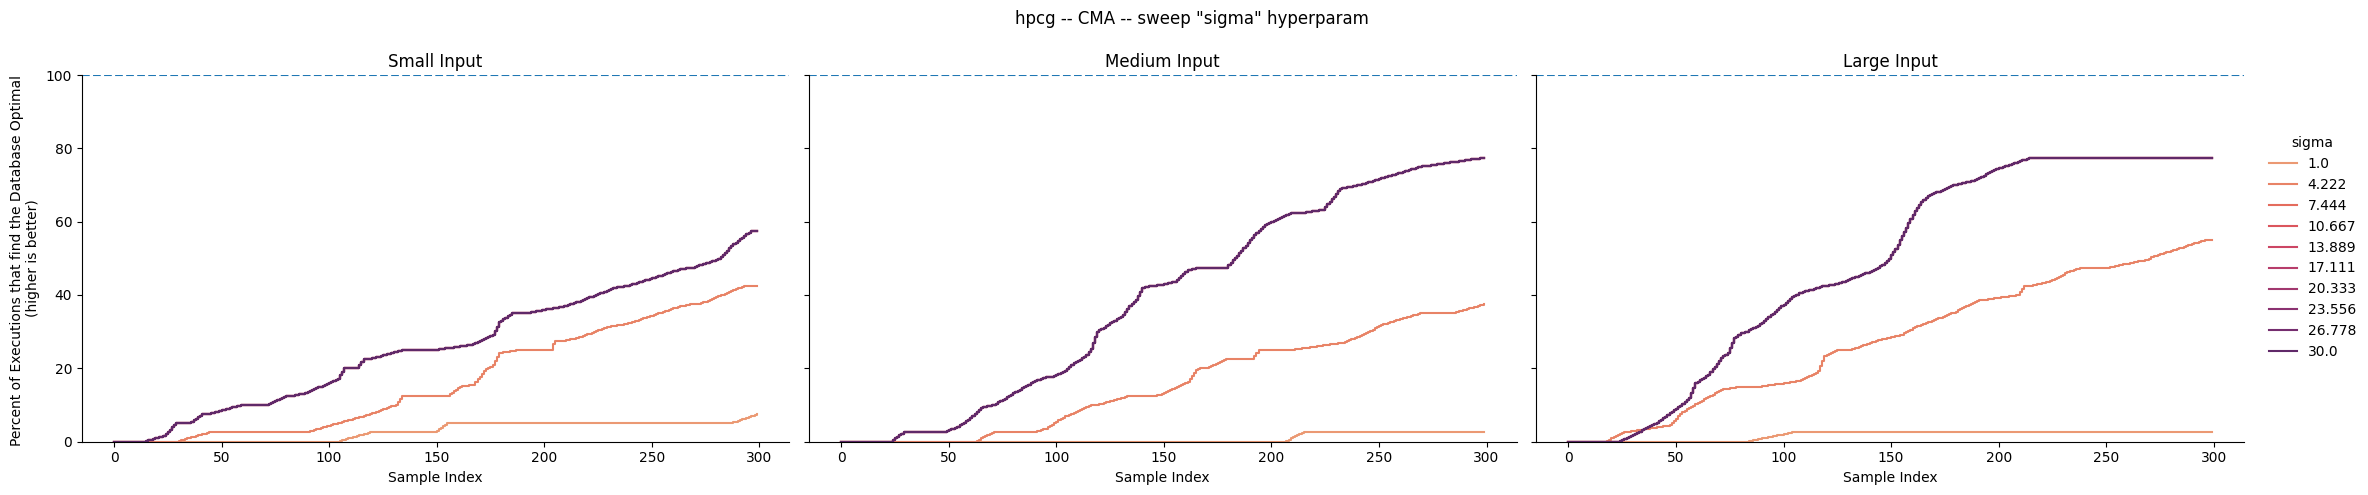

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-hpcg-pso-GO_Data.csv
hpcg pso popsize


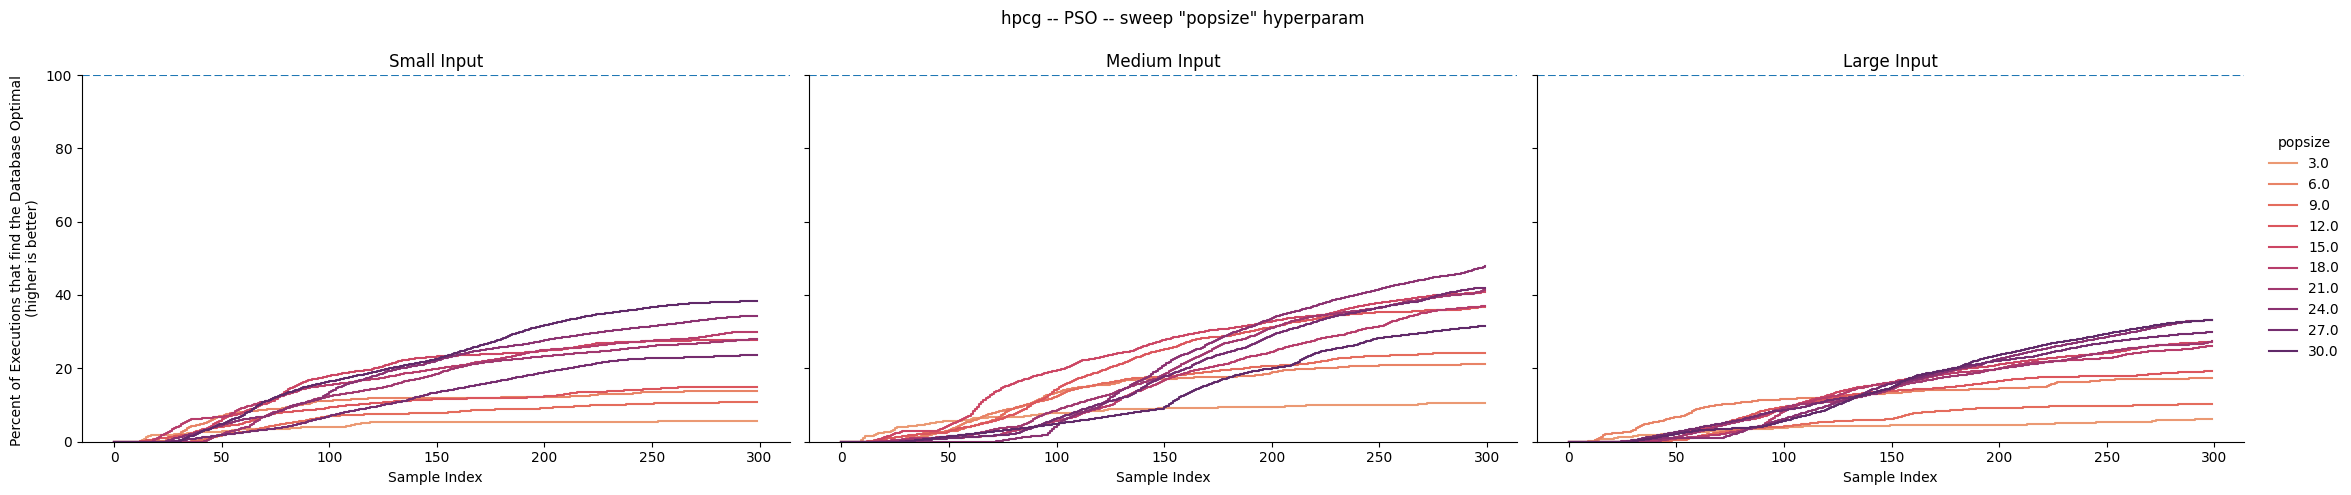

hpcg pso w


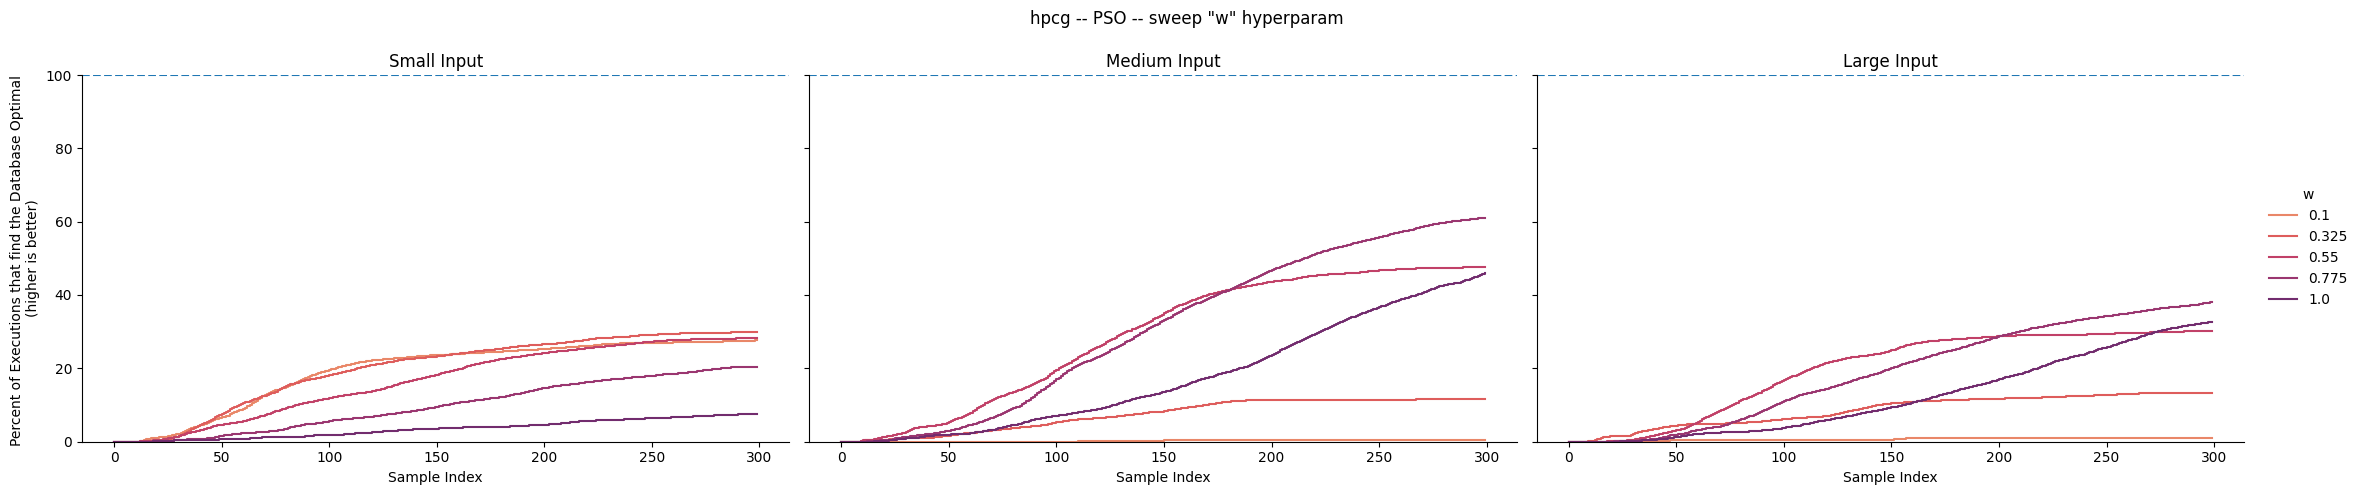

hpcg pso c1


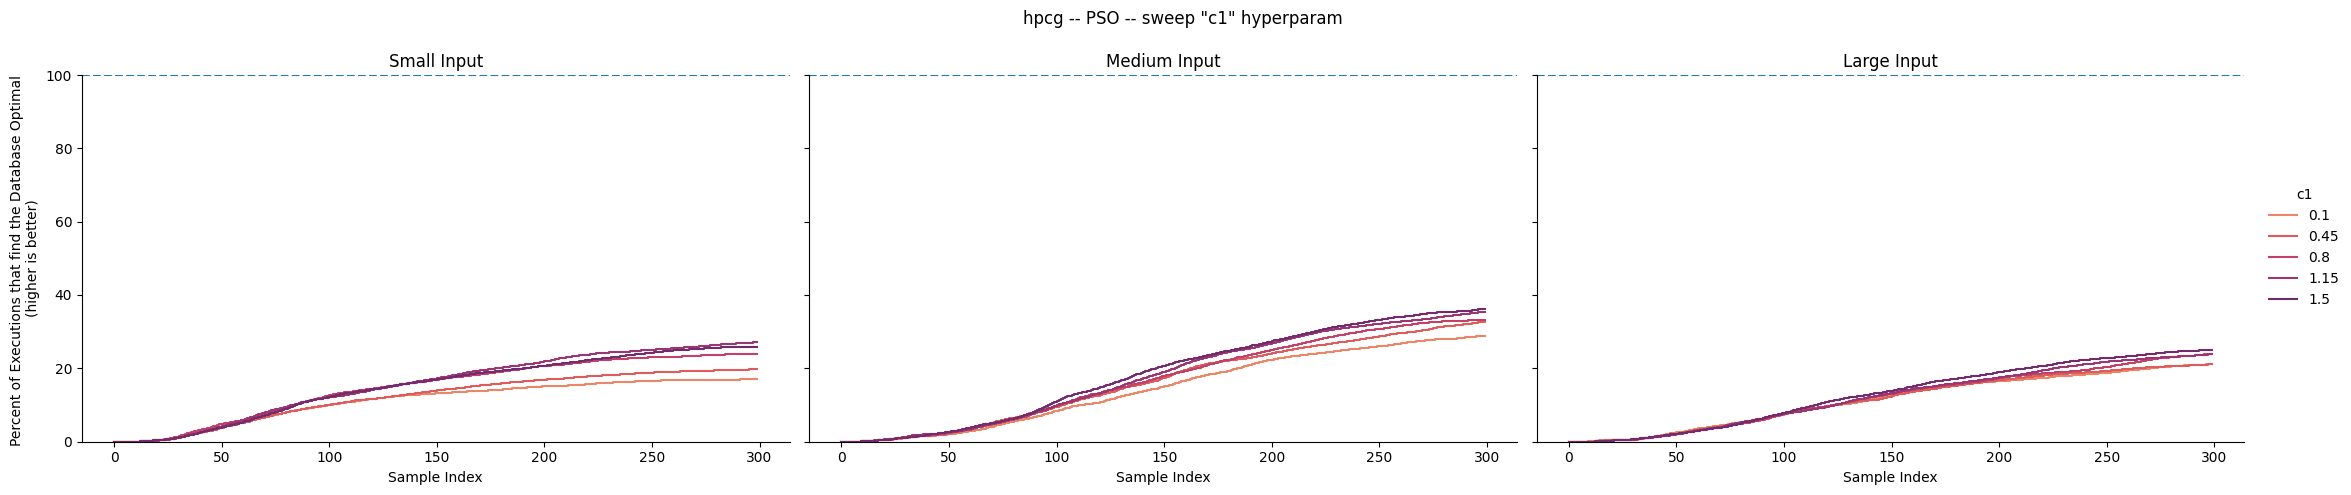

hpcg pso c2


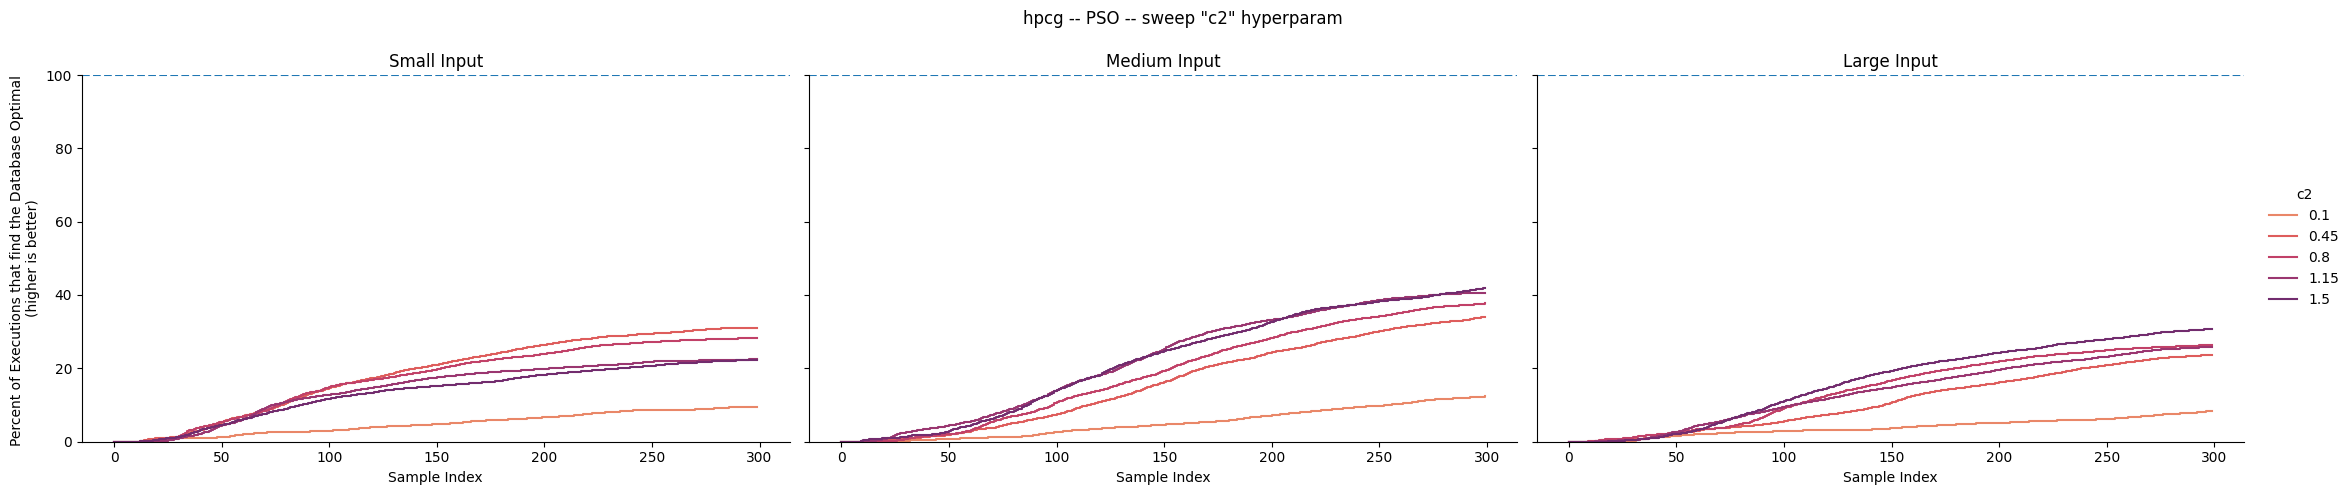

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-hpcg-bo-GO_Data.csv
hpcg bo utilFnct


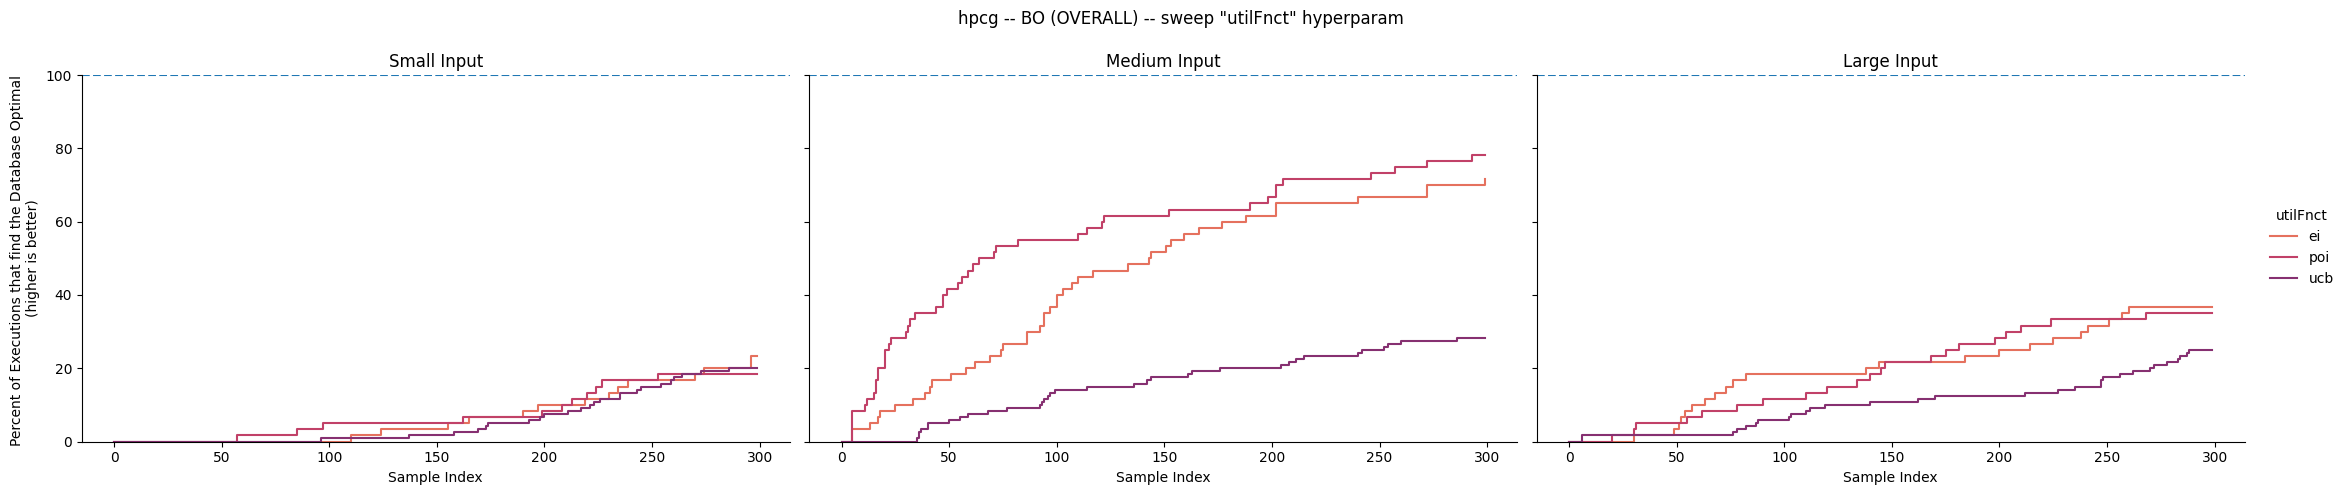

hpcg bo ['kappa', 'kappa_decay', 'kappa_decay_delay']


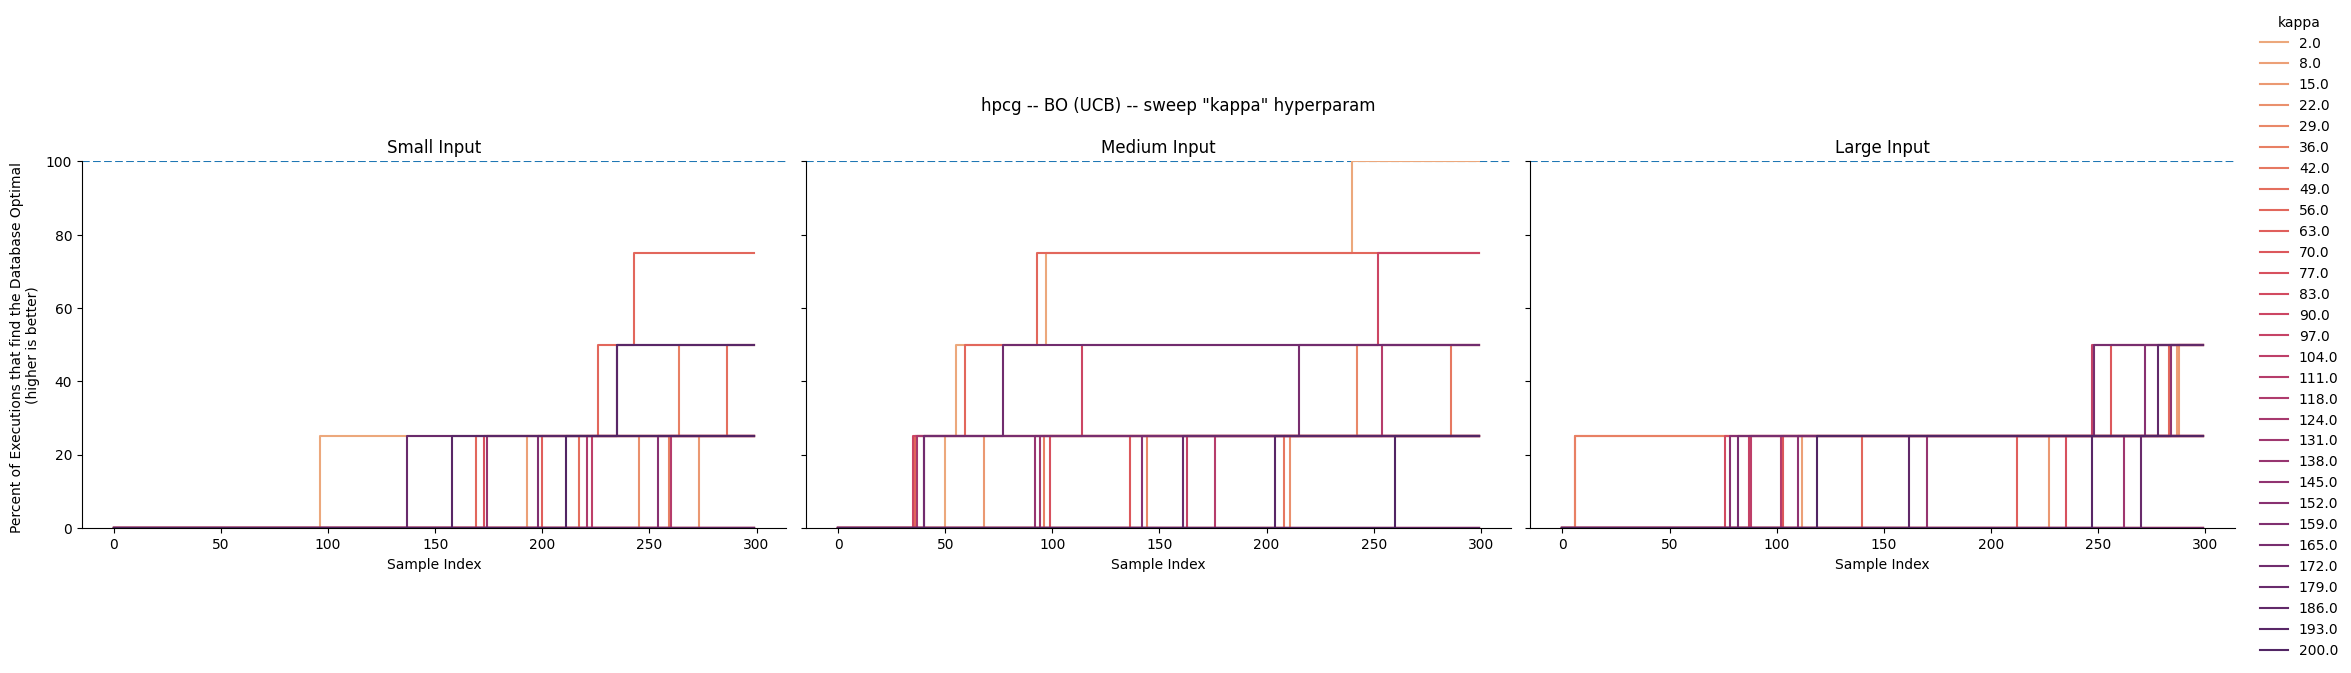

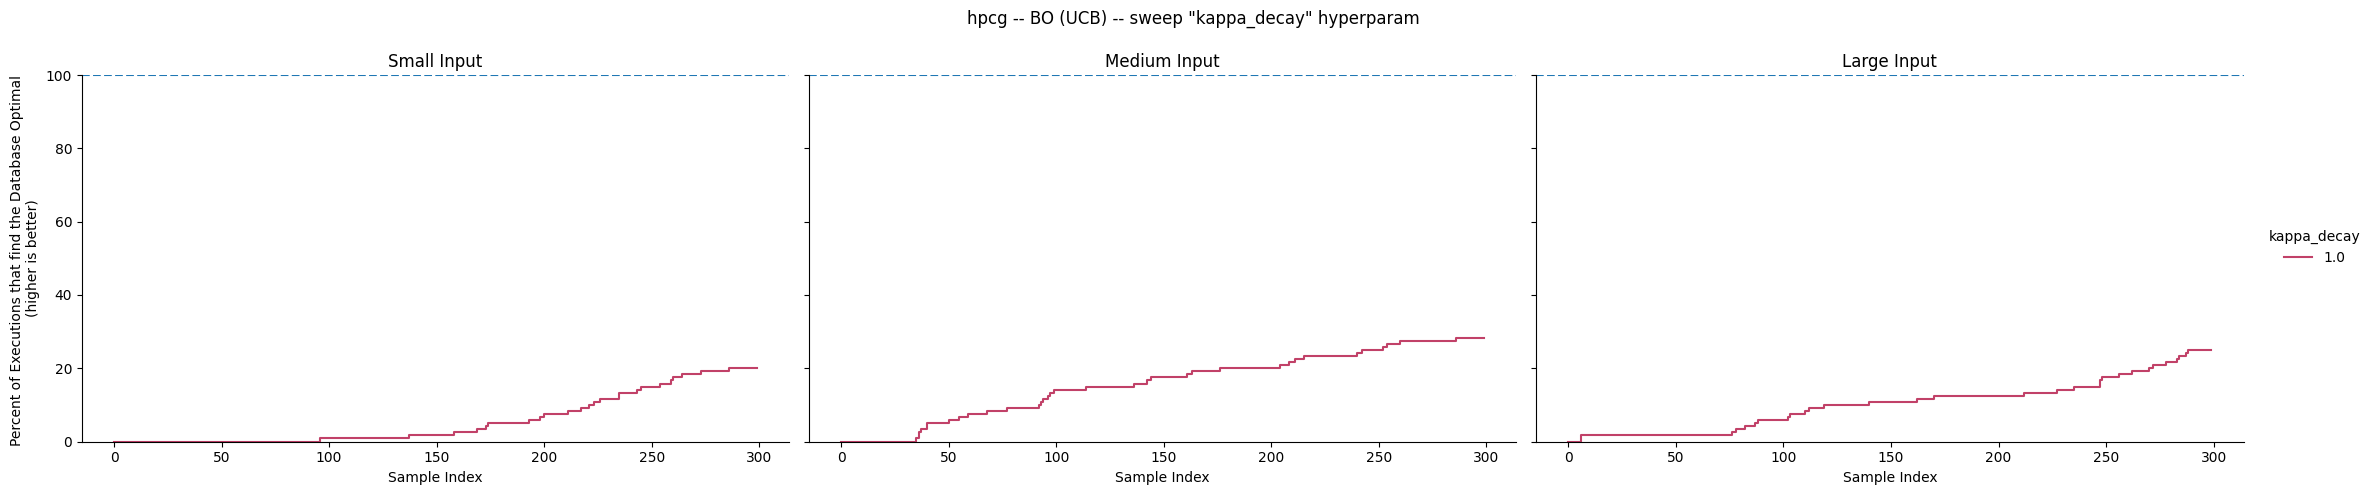

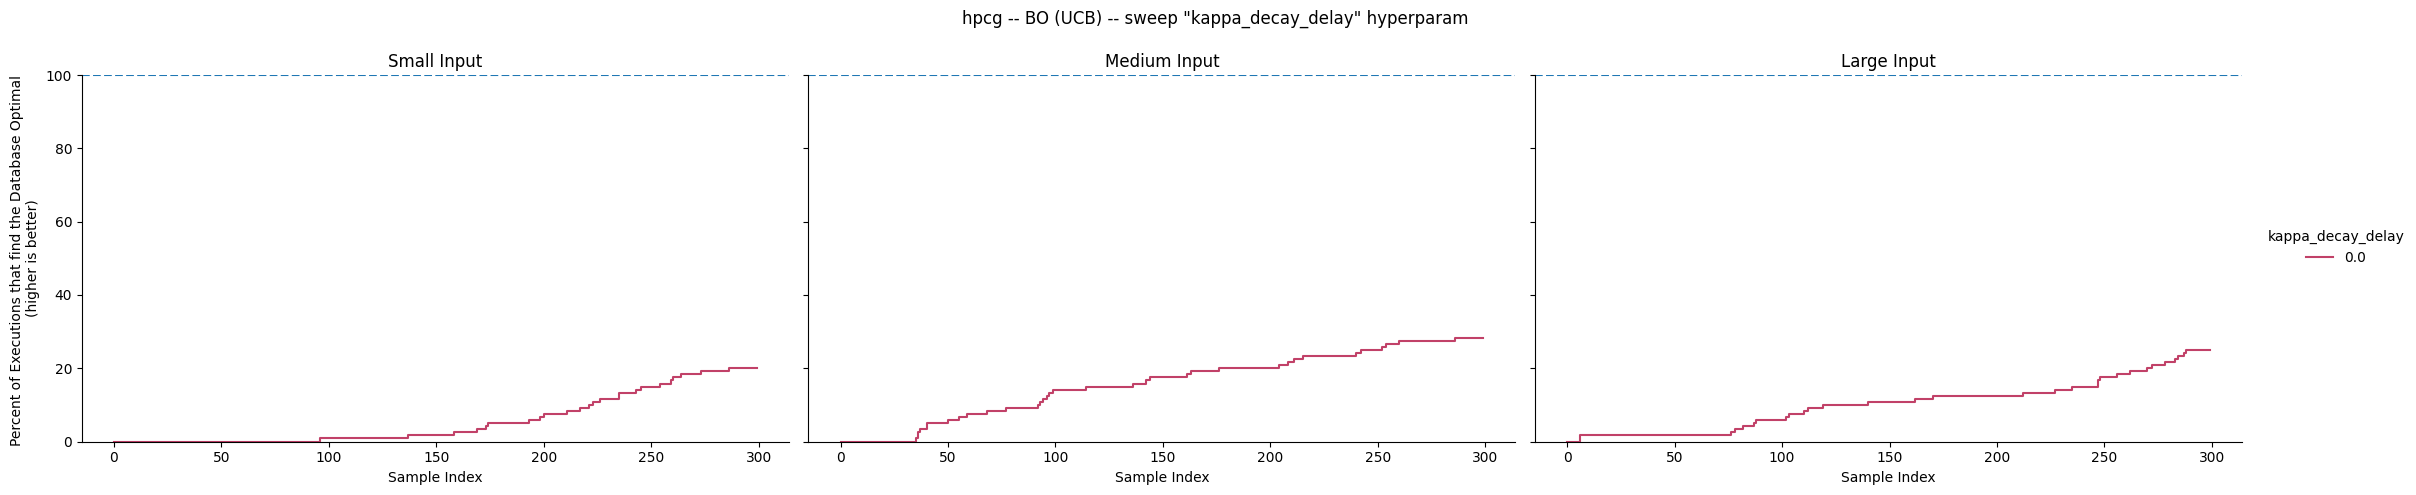

hpcg bo ['xi']


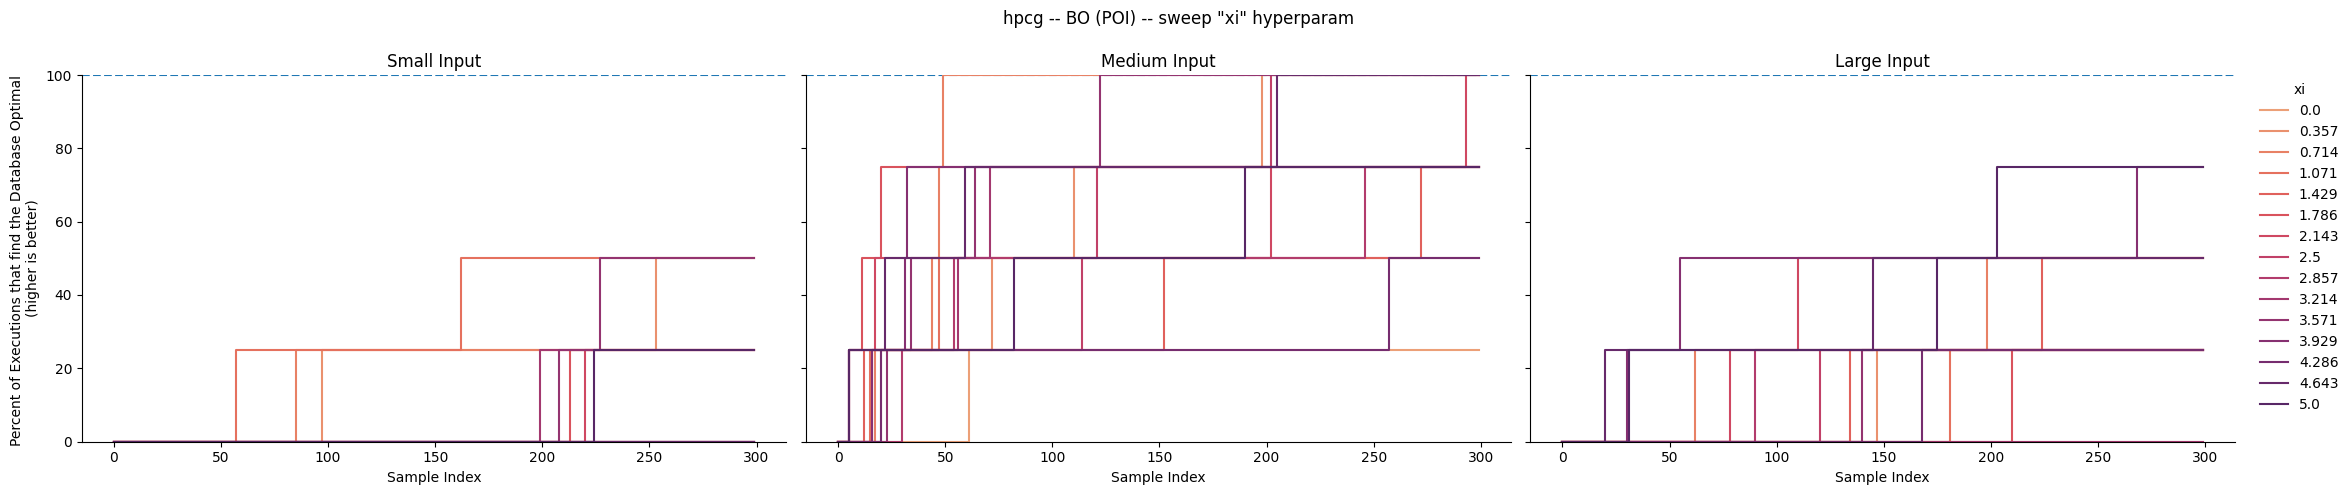

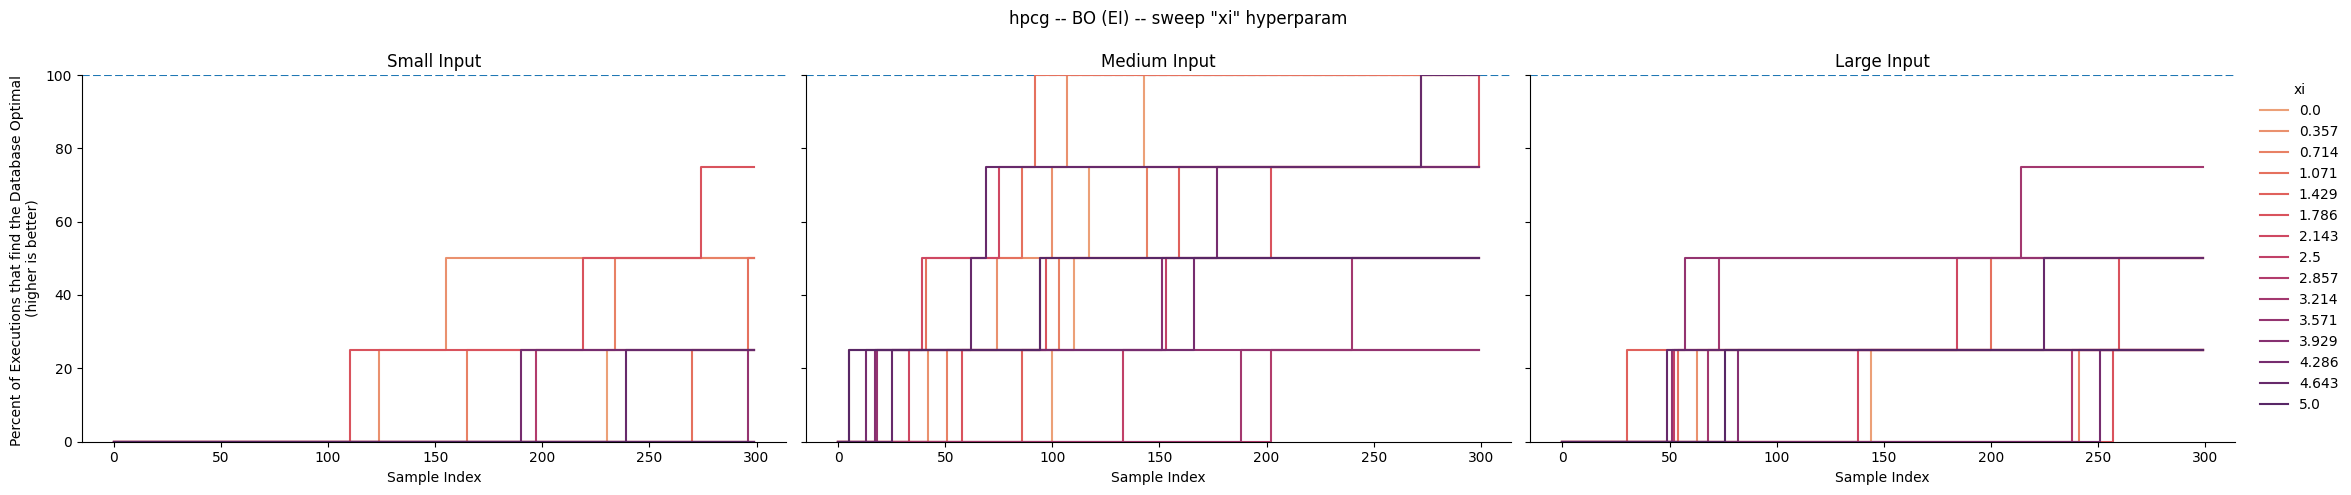

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-lulesh-cma-GO_Data.csv
lulesh cma popsize


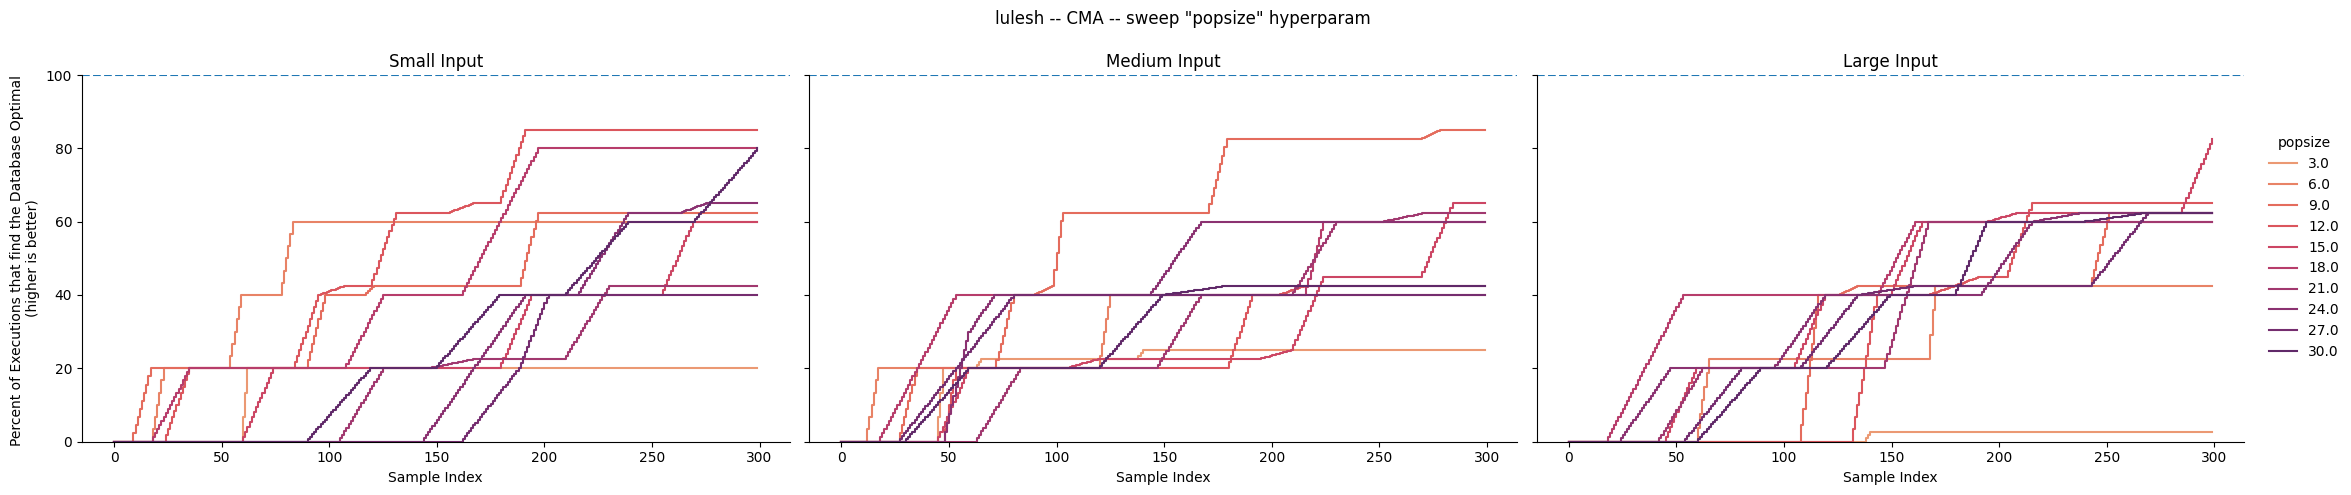

lulesh cma sigma


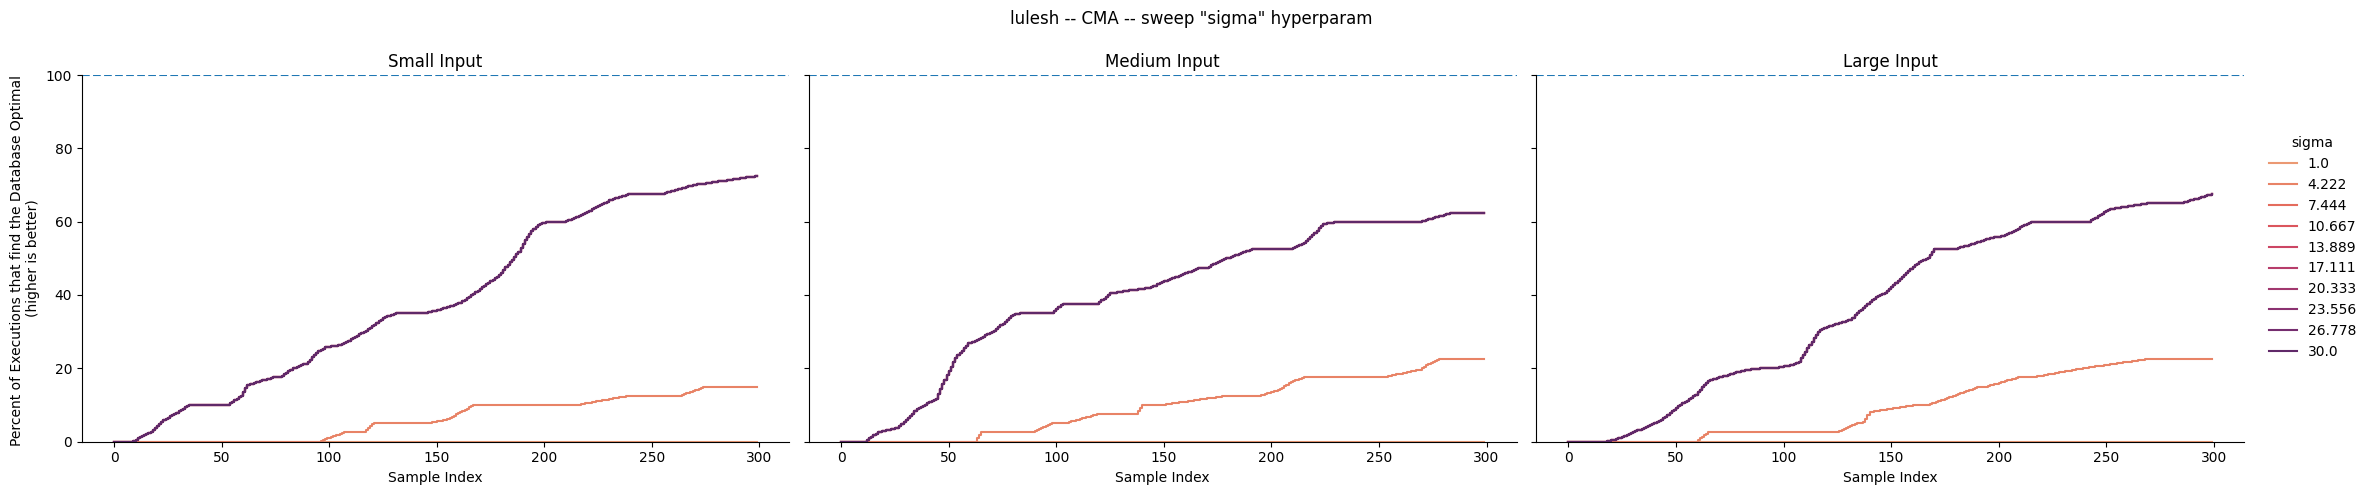

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-lulesh-pso-GO_Data.csv
lulesh pso popsize


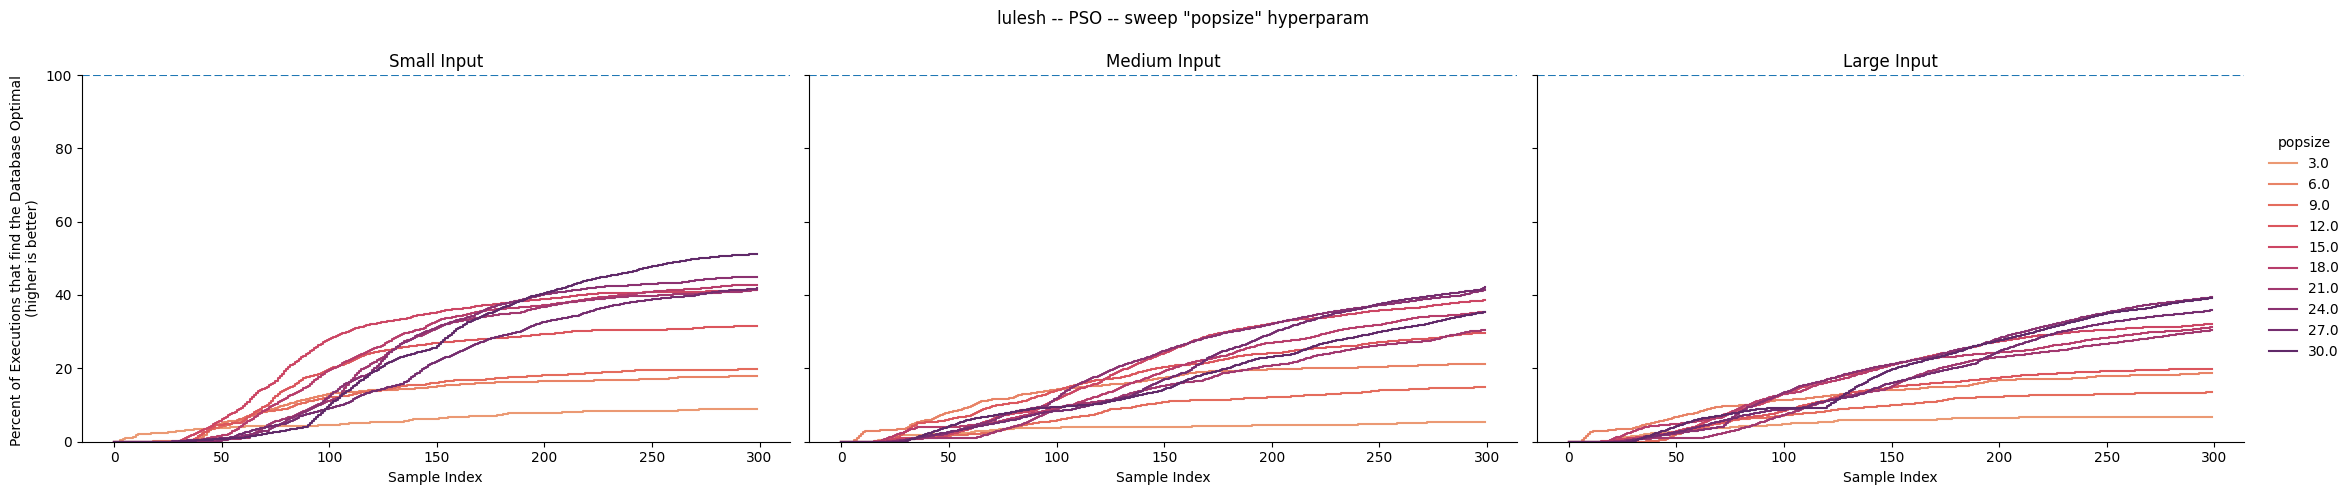

lulesh pso w


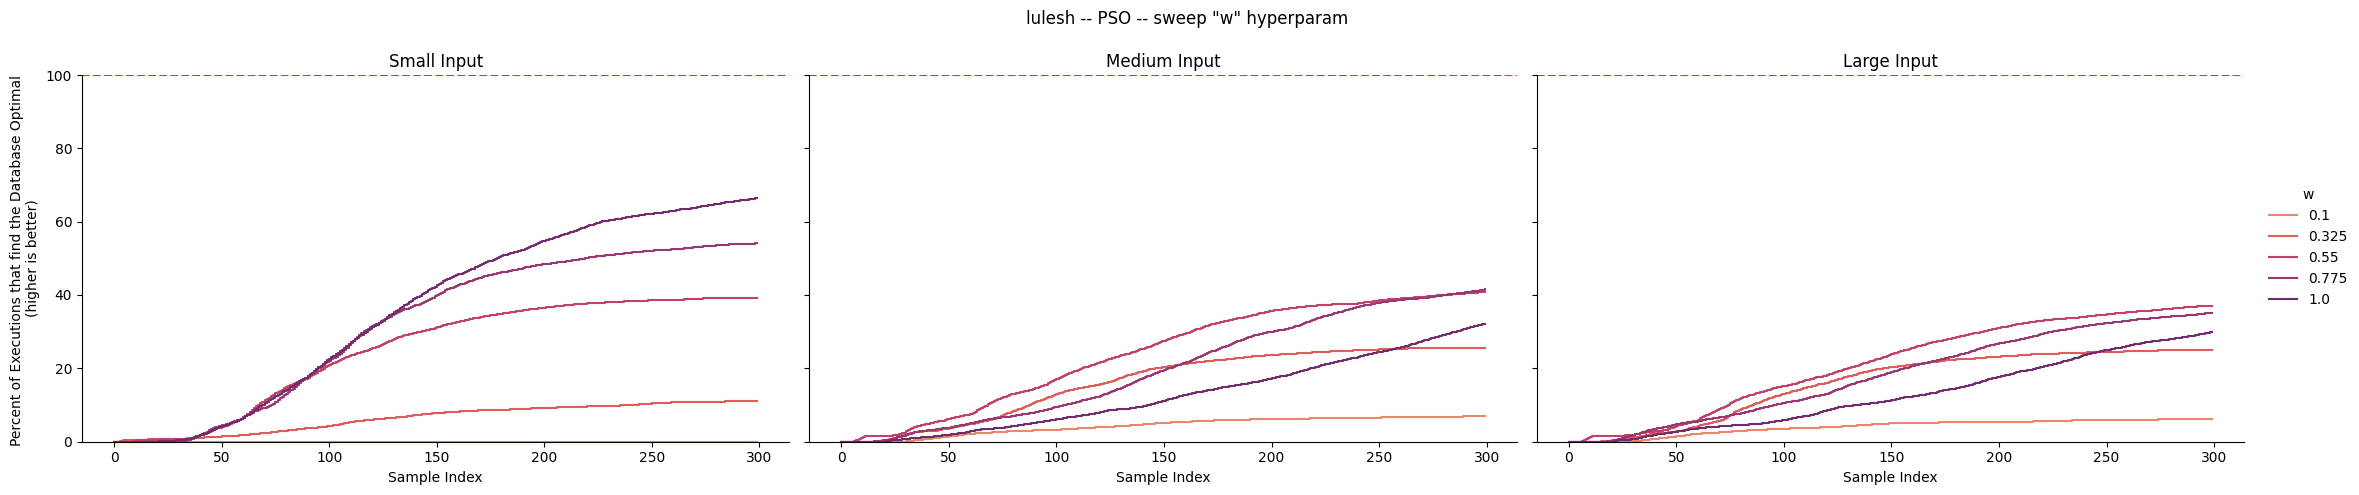

lulesh pso c1


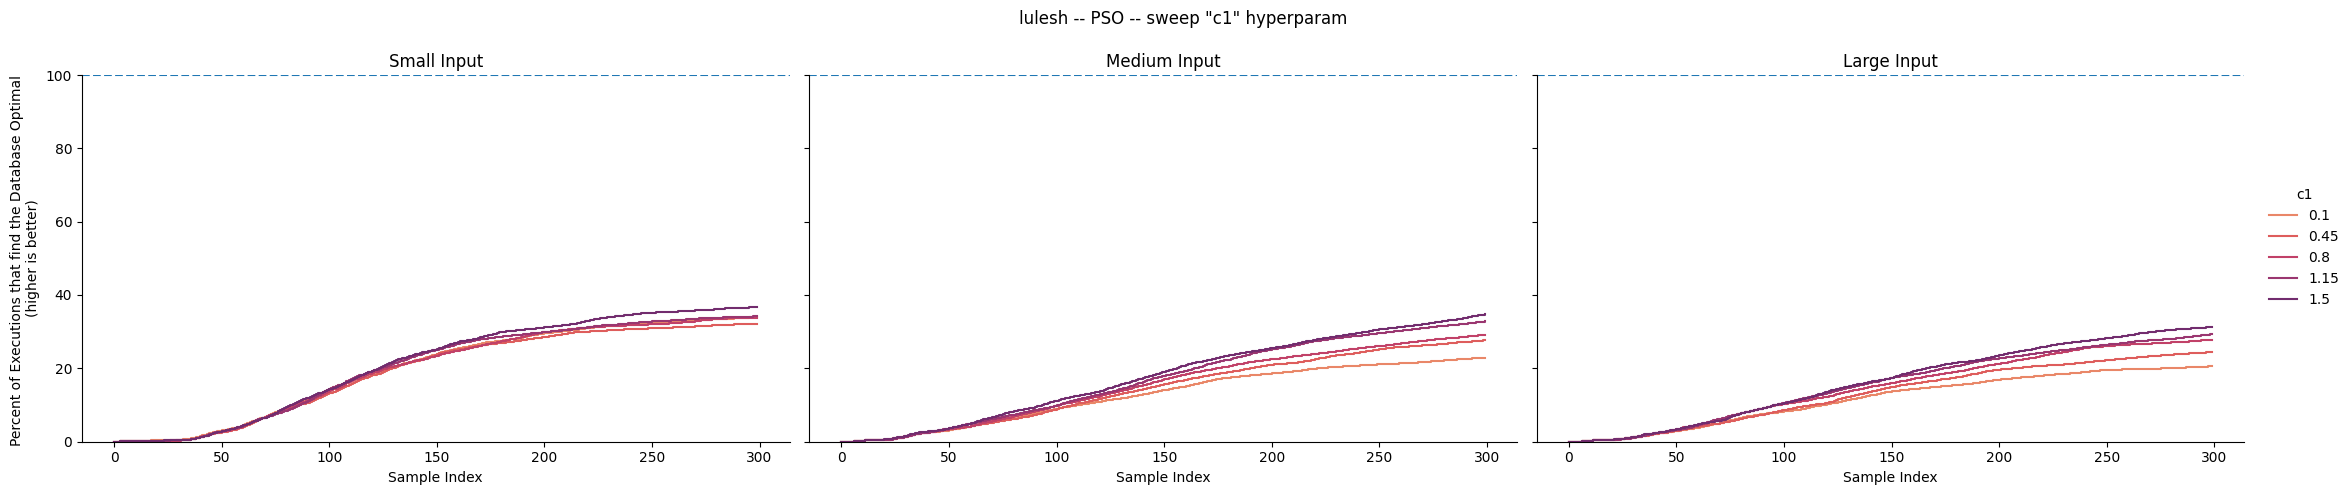

lulesh pso c2


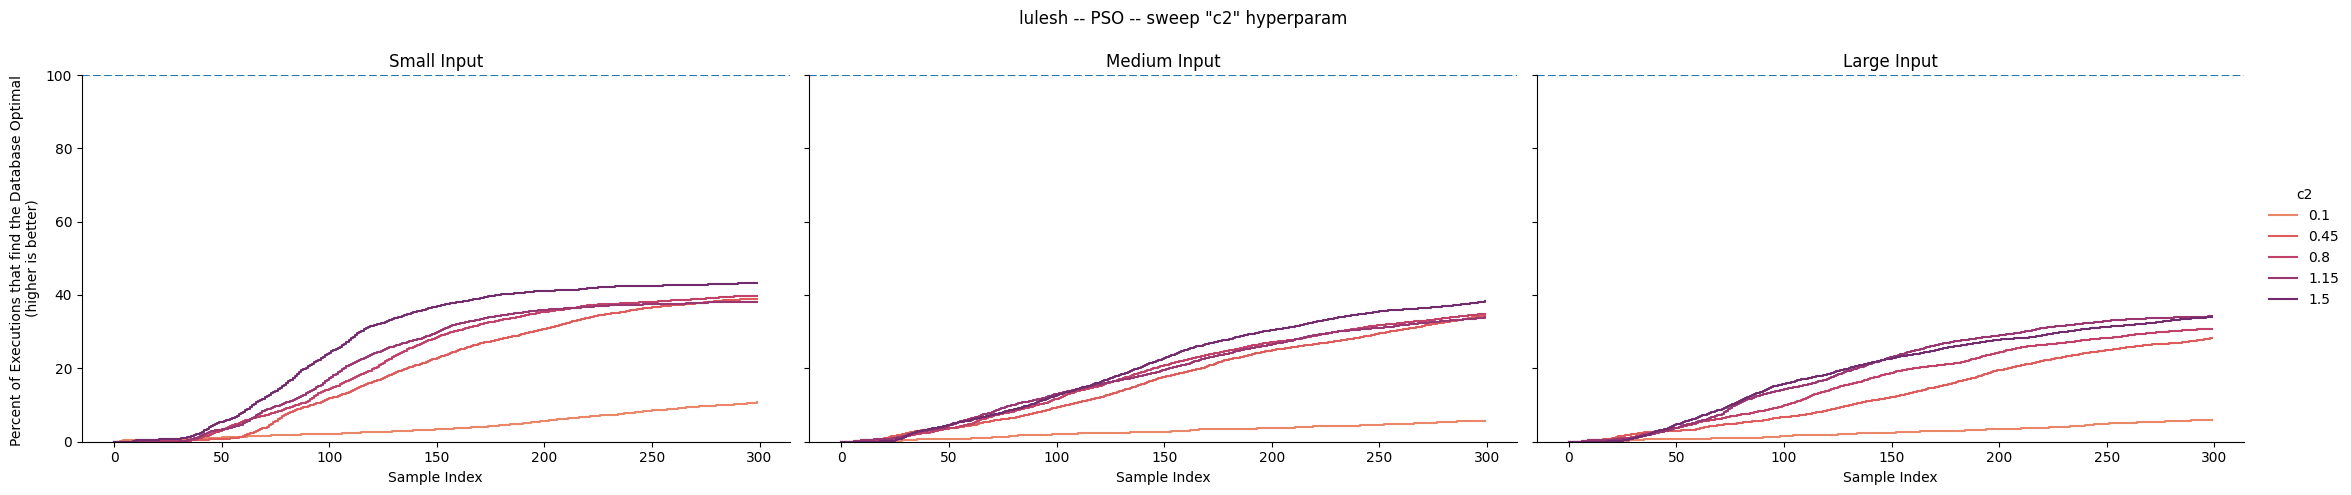

reading file /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-lulesh-bo-GO_Data.csv
lulesh bo utilFnct


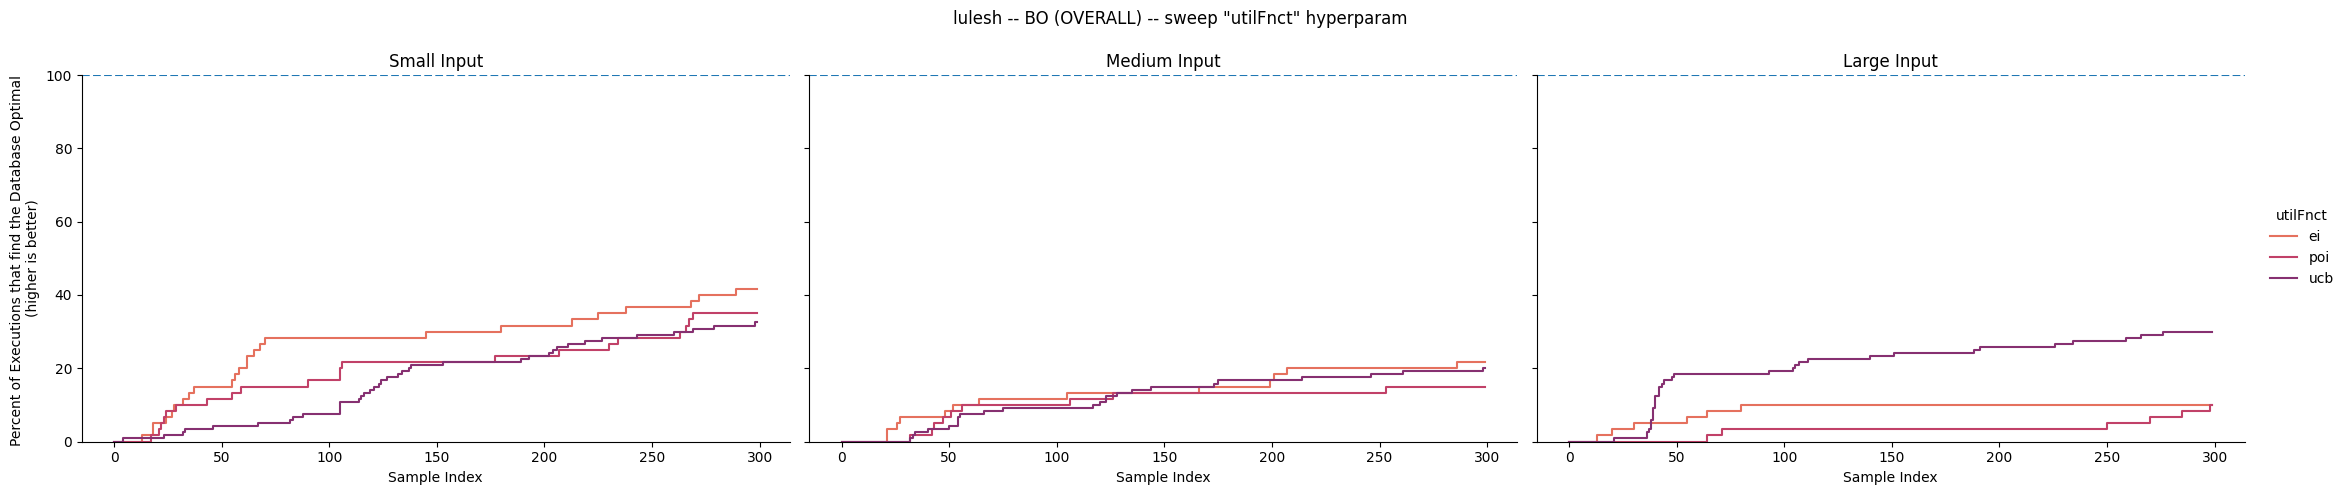

lulesh bo ['kappa', 'kappa_decay', 'kappa_decay_delay']


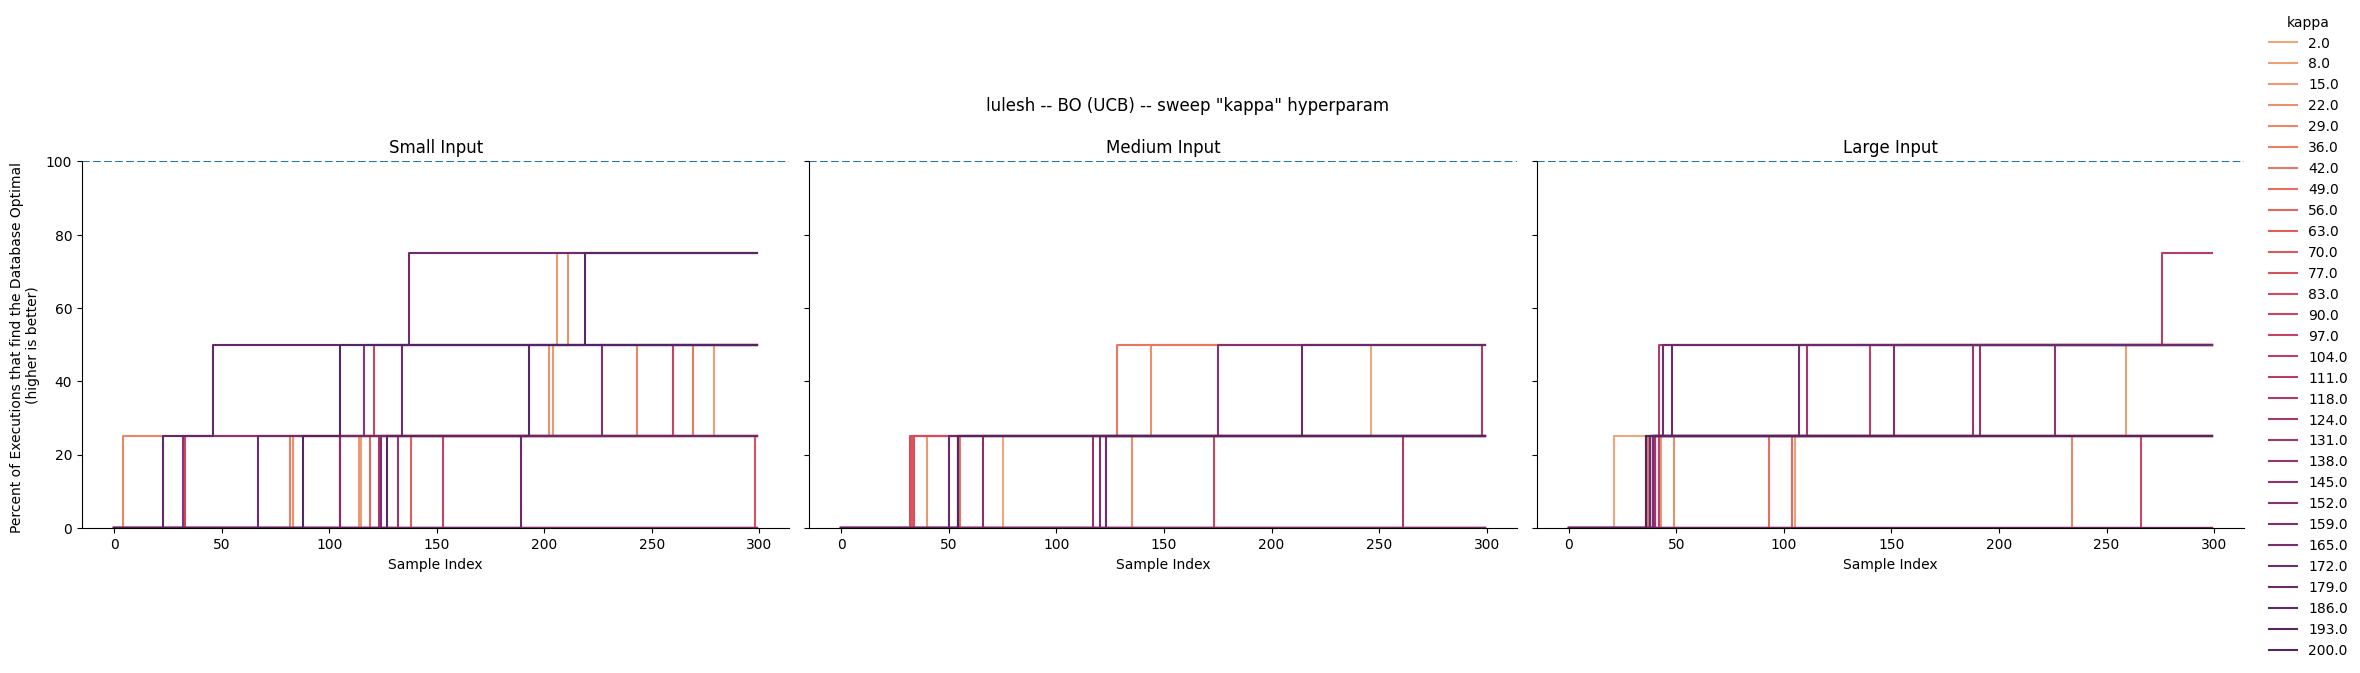

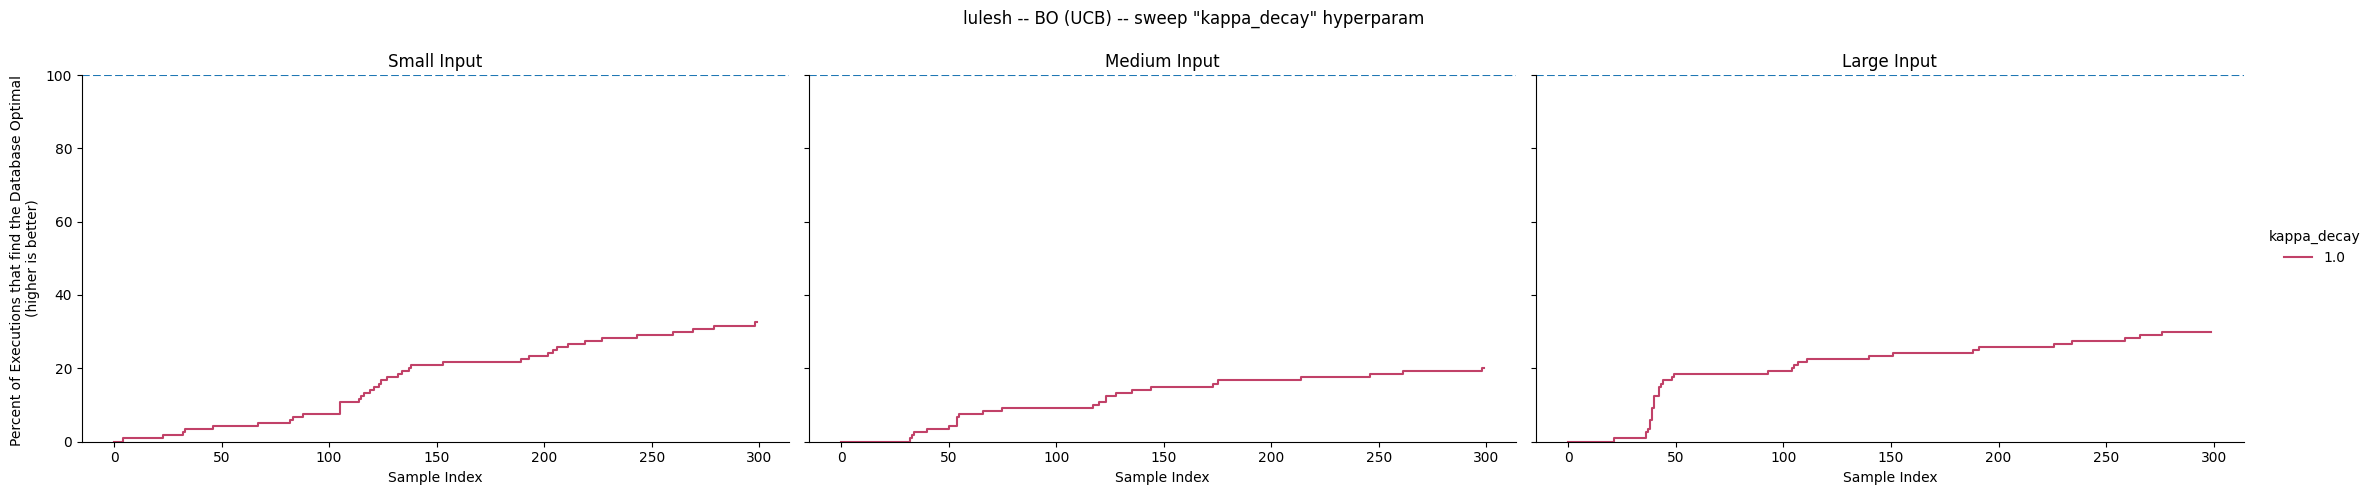

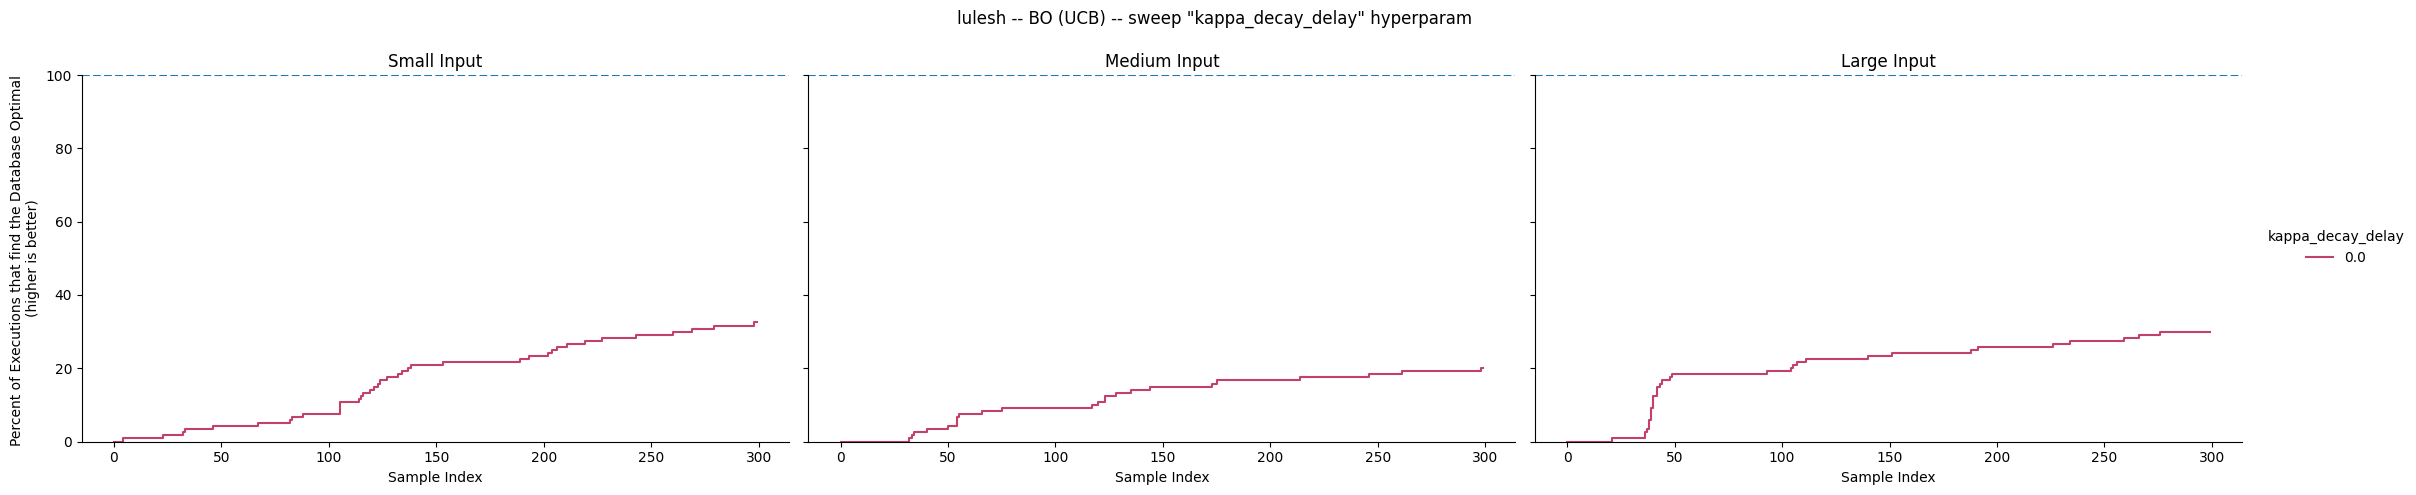

lulesh bo ['xi']


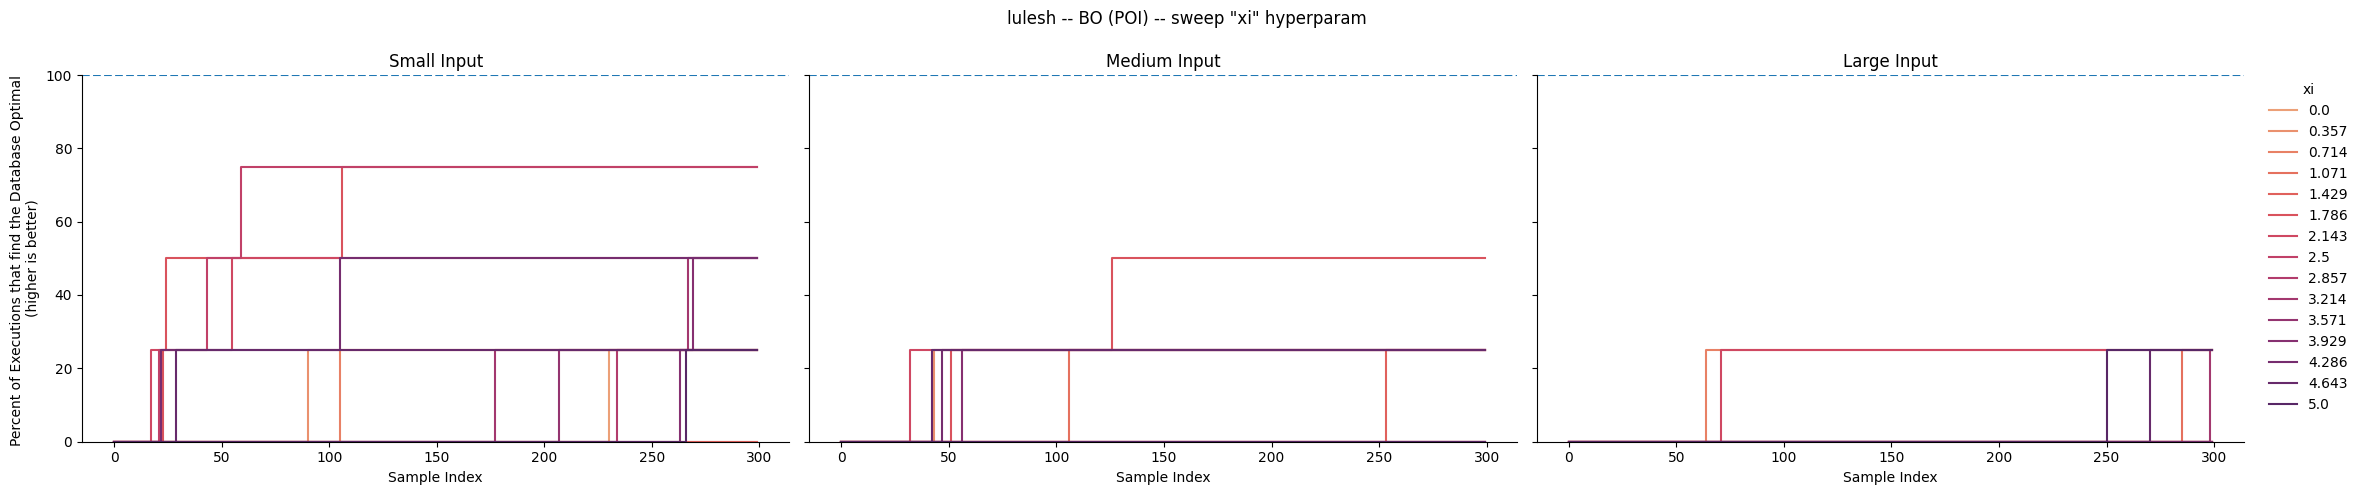

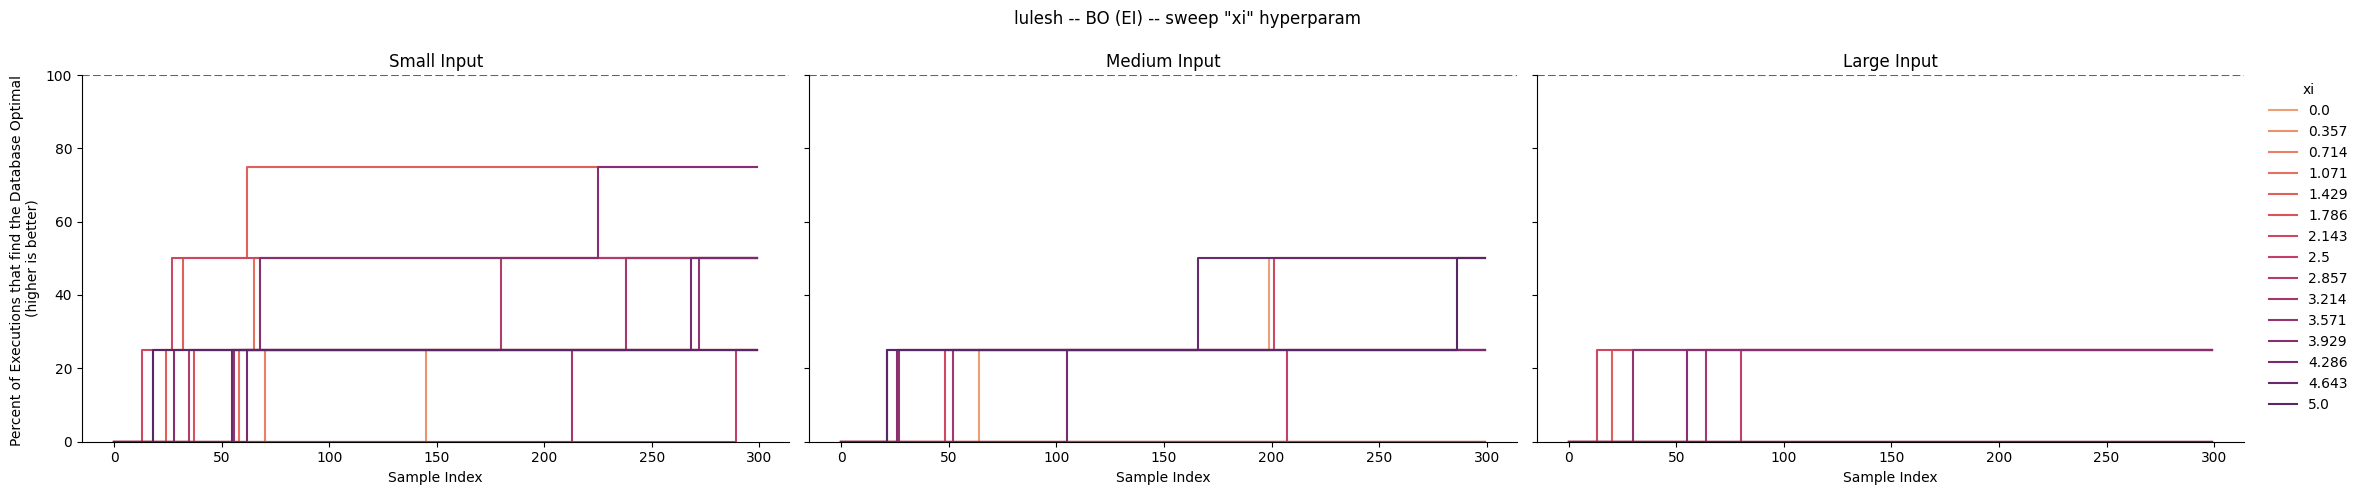

In [11]:
plotIndividualVariablesForAllCodes()

In [12]:
#import itertools
#
## let's make a toy example
#probsize =  ['s', 'm']
#xi = [1.1, 5.5]
#seed = [66,67]
#sampleIdx = [0,1,2,3]
#
#a = [probsize, xi, seed, sampleIdx]
#combos = list(itertools.product(*a))
#
#print(len(combos))
#
#data = [ combo+(0,) for combo in combos]
#
#df = pd.DataFrame(data, columns=['probsize', 'xi', 'seed', 'sampleIdx', 'optimIndic'])
#
#print(df.dtypes)
#
## make all the 0 index indicators to 0
#df.loc[df['sampleIdx'] == 0, 'optimIndic'] = 0
#
#df.loc[(df['xi'] == 1.1) & (df['seed'] == 66) & (df['probsize'] == 's') & (df['sampleIdx'] == 1), 'optimIndic'] = 1
#df.loc[(df['xi'] == 1.1) & (df['seed'] == 67) & (df['probsize'] == 's') & (df['sampleIdx'] == 2), 'optimIndic'] = 1
#
#df.loc[(df['xi'] == 1.1) & (df['seed'] == 66) & (df['probsize'] == 'm') & (df['sampleIdx'] == 2), 'optimIndic'] = 1
#df.loc[(df['xi'] == 5.5) & (df['seed'] == 66) & (df['probsize'] == 'm') & (df['sampleIdx'] == 1), 'optimIndic'] = 1
#
#print(df)
#
#df['sumd'] = df.groupby(['probsize', 'xi', 'seed'])['optimIndic'].cumsum().reset_index(drop=True).apply(lambda x: 1 if x != 0 else 0)
#
#print(df)
#
#newdf = df.groupby(['probsize', 'xi', 'sampleIdx'])['sumd'].mean().reset_index(drop=False)#.apply(lambda x: 100.0*x['sumd'])
#newdf['percD'] = newdf['sumd']*100
#
#print(newdf)
#
#g = sns.FacetGrid(newdf, col='probsize', col_order=['s', 'm'], hue='xi', palette='flare', legend_out=True, height=5, aspect=1.5)
#g.map_dataframe(sns.lineplot, x='sampleIdx', y='percD', drawstyle='steps-post')
#g.add_legend()
#g.set(ylim=(-0.05, 100.05))
#g.fig.subplots_adjust(top=0.85)
#
#

In [13]:
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

In [14]:
#import itertools
#
## let's make a toy example
#probsize =  ['s', 'm']
#popsz = [2,4]
#sigma = [0.1, 0.3]
#seed = [66,67]
#sampleIdx = [0,1,2,3,4,5,6,7]
#
#a = [probsize, seed, sigma, popsz, sampleIdx]
#combos = list(itertools.product(*a))
#
#print(len(combos))
#
#data = [ combo+(0,) for combo in combos]
#
#df = pd.DataFrame(data, columns=['probsize', 'seed', 'sigma', 'popsz', 'sampleIdx', 'optimIndic'])
#
#df.loc[(df['popsz'] == 2) & (df['sigma'] == 0.1) & (df['seed'] == 66) & (df['probsize'] == 's') & (df['sampleIdx'] == 1), 'optimIndic'] = 1
#df.loc[(df['popsz'] == 2) & (df['sigma'] == 0.3) & (df['seed'] == 66) & (df['probsize'] == 's') & (df['sampleIdx'] == 3), 'optimIndic'] = 1
#df.loc[(df['popsz'] == 2) & (df['sigma'] == 0.3) & (df['seed'] == 67) & (df['probsize'] == 's') & (df['sampleIdx'] == 2), 'optimIndic'] = 1
##
#df.loc[(df['popsz'] == 4) & (df['sigma'] == 0.1) & (df['seed'] == 67) & (df['probsize'] == 's') & (df['sampleIdx'] == 2), 'optimIndic'] = 1
#
#df.loc[(df['popsz'] == 4) & (df['sigma'] == 0.3) & (df['seed'] == 66) & (df['probsize'] == 'm') & (df['sampleIdx'] == 3), 'optimIndic'] = 1
#
## first need to mark which population group each sample belongs to
#df['popgrp'] = df['sampleIdx']//df['popsz']
#
##print(df.dtypes)
##print(df.head(20))
#
## for each population group, we want to average out the indicators
##df['grpAvrg'] = df.groupby(['probsize', 'seed', 'sigma', 'popsz', 'popgrp'])['optimIndic'].mean().reset_index(drop=False)
#df['grpAvrg'] = df.groupby(['probsize', 'seed', 'sigma', 'popsz', 'popgrp'])['optimIndic'].transform('mean')
##print('grpAvrg')
##print(test.head(20))
##print(df)
#
#df['sumd'] = df.groupby(['probsize', 'seed', 'sigma', 'popsz'])['grpAvrg'].transform('cumsum').apply(lambda x: min(1, x))
##print('sumd')
##print(df)
#
#newdf = df.groupby(['probsize', 'popsz', 'sampleIdx'])['sumd'].mean().reset_index(drop=False)#.apply(lambda x: 100.0*x['sumd'])
#newdf['percD'] = newdf['sumd']*100
#
##print('newdf')
##print(newdf)
##
##check = newdf[newdf.isna().any(axis=1)] 
##print('check')
##print(check)
#
#g = sns.FacetGrid(newdf, col='probsize', col_order=['s', 'm'], hue='popsz', palette='flare', legend_out=True, height=5, aspect=1.5)
#g.map_dataframe(sns.lineplot, x='sampleIdx', y='percD', drawstyle='steps-post')
#g.add_legend()
#g.set(ylim=(-0.05, 100.05))
#g.fig.subplots_adjust(top=0.85)
#plt.show()
#
#
## make all the 0 index indicators to 0
##df.loc[df['sampleIdx'] == 0, 'optimIndic'] = 0
#
##df.loc[(df['popsz'] == 2) & (df['xi'] == 1.1) & (df['seed'] == 66) & (df['probsize'] == 's') & (df['sampleIdx'] == 1), 'optimIndic'] = 1
##
##print(df)
##
##df['sumd'] = df.groupby(['probsize', 'xi', 'seed'])['optimIndic'].cumsum().reset_index(drop=True).apply(lambda x: 1 if x != 0 else 0)
##
##print(df)
##
##newdf = df.groupby(['probsize', 'xi', 'sampleIdx'])['sumd'].mean().reset_index(drop=False)#.apply(lambda x: 100.0*x['sumd'])
##newdf['percD'] = newdf['sumd']*100
##
##print(newdf)
##
##g = sns.FacetGrid(newdf, col='probsize', col_order=['s', 'm'], hue='xi', palette='flare', legend_out=True, height=5, aspect=1.5)
##g.map_dataframe(sns.lineplot, x='sampleIdx', y='percD', drawstyle='steps-post')
##g.add_legend()
##g.set(ylim=(-0.05, 100.05))
##g.fig.subplots_adjust(top=0.85)
#
#